<a href="https://colab.research.google.com/github/kimwoonggon/SIIM-COVID19-KAGGLE/blob/main/(cvCalCulation_%2B_Ensemble)yolov5_cv_map_calculation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Setting

In [1]:
!pip uninstall pyyaml
#!pip install pyyaml
from google.colab import drive
drive.mount('/content/gdrive/')
import os
from IPython.display import Image, clear_output
root_path = "/content/gdrive/My Drive/Colab Notebooks/KAGGLE_COVID_TORCH_YOLO"

Uninstalling PyYAML-3.13:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/PyYAML-3.13.dist-info/*
    /usr/local/lib/python3.7/dist-packages/yaml/*
Proceed (y/n)? y
  Successfully uninstalled PyYAML-3.13
Mounted at /content/gdrive/


In [2]:
yolo_path = r"/content/gdrive/My\ Drive/Colab\ Notebooks/KAGGLE_COVID_TORCH_YOLO"

In [3]:
!cp {yolo_path}/yolov5_for_colab.zip .

In [4]:
!unzip yolov5_for_colab.zip

Streaming output truncated to the last 5000 lines.
 extracting: train/384de6416f6e.png  
  inflating: train/38556dd92c13.png  
 extracting: train/3855902bcfc6.png  
 extracting: train/3857daee16d2.png  
 extracting: train/3859c4430778.png  
 extracting: train/386dbb567259.png  
 extracting: train/387d752f1af4.png  
 extracting: train/388b0d5fc3a4.png  
 extracting: train/3892dd928d72.png  
 extracting: train/38ab5750fb0f.png  
 extracting: train/38d5134eb588.png  
 extracting: train/38db8a56a857.png  
 extracting: train/38e710e131ef.png  
 extracting: train/38f7e0a0277c.png  
 extracting: train/38fd3c9ace4e.png  
 extracting: train/3904d1650e46.png  
 extracting: train/3909a21dca77.png  
 extracting: train/390ce1f029e7.png  
 extracting: train/390dba6691ee.png  
 extracting: train/390eecc3d067.png  
  inflating: train/3922e7ba8993.png  
 extracting: train/392c3b657bc2.png  
 extracting: train/39429f784da2.png  
 extracting: train/394536fc0dca.png  
 extracting: train/3959ceb9bbce.png  

# Stratify folds considering bbox_counts and unique class distributions

# Settings

In [5]:
fold = 3
IMAGE_SIZE = 640
weight = "yolov5l.pt"
weight_start = "yolov5l"
INFER = True

def read_list_from_file(list_file, comment='#'):
    with open(list_file) as f:
        lines = f.readlines()
    strings = []
    for line in lines:
        if comment is not None:
            s = line.split(comment, 1)[0].strip()
        else:
            s = line.strip()
        if s!= '':
            strings.append(s)
    return strings

import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, GroupKFold
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import warnings


warnings.filterwarnings('ignore')
n_folds = 5
df = pd.read_csv(r'df_annotate.csv')

duplicate = read_list_from_file(r'duplicate.txt')
df = df[~df['image_id'].isin(duplicate)].reset_index(drop=True)

#df = pd.DataFrame(df)
if INFER == False:
    df = df[df['class_id'] != 0]
print(df.shape)
df_meta = pd.read_csv(r'df_meta.csv')

df_meta = df_meta.rename(columns={"image":"image_id"})
df_meta = df_meta[~df_meta['image_id'].isin(duplicate)].reset_index(drop=True)
df = df.merge(df_meta[['image_id','study']], on='image_id', how='left')
df = df.rename(columns={"study":"study_id"})
fold_info = pd.read_csv(r'df_fold_rand830.csv')
fold_info['study'] = fold_info['study_id']
df_meta = df_meta.merge(fold_info, on='study', how='left')
df = df.merge(fold_info, on='study_id', how='left')
df_backup = df.copy()
print(df.shape)


df = df.reset_index(drop=True)

(9786, 12)
(9786, 15)


In [6]:
if INFER:
    dim_df = df_meta.copy()
    dim_df = dim_df[dim_df['set']=='train'].reset_index(drop=True)
    dim_df['id'] = dim_df["image_id"] + '_image'
    image_level_df = pd.read_csv("train_image_level.csv")
    image_level_df = pd.merge(image_level_df, dim_df[['id', 'width', 'height','fold']] , on = 'id', how = 'left')
    image_level_df["none"]=image_level_df.label.apply(lambda x: 0 if x=='none 1 0 0 1 1' else 1)
    
    
    for i in range(image_level_df.shape[0]):
        if image_level_df.loc[i,'label'] == "none 1 0 0 1 1":
            image_level_df.loc[i,'label']='0 1 0 0 1 1'
            continue
        sub_df_split = image_level_df.loc[i,'label'].split()
        sub_df_list = []
        for j in range(int(len(sub_df_split) / 6)):
            sub_df_list.append('1')
            sub_df_list.append(sub_df_split[6 * j + 1])
            sub_df_list.append(sub_df_split[6 * j + 2])
            sub_df_list.append(sub_df_split[6 * j + 3])
            sub_df_list.append(sub_df_split[6 * j + 4])
            sub_df_list.append(sub_df_split[6 * j + 5])
        image_level_df.loc[i,'label'] = ' '.join(sub_df_list)


    image_level_df['image_id'] = image_level_df['id'].map(lambda x: x.split("_")[0])
    image_level_df['class_id'] = image_level_df.apply(lambda x: 1 if x['none']==0 else 0, axis=1)
    df_backup['ncx'] = df_backup['nx'] + df_backup['nw'] /2
    df_backup['ncy'] = df_backup['ny'] + df_backup['nh'] / 2
    image_level_df = pd.merge(image_level_df, df_backup[['image_id', 'ncx', 'ncy', 'nw', 'nh']], on='image_id', how='left')
    #for fold in range(5):
    #    df_valid = image_level_df[image_level_df['fold']==fold]
    #    df_valid = df_valid.reset_index(drop=True)

In [7]:
if (INFER == False):
    df['class_id'] = 0
    df['ncx'] = df['nx'] + df['nw'] /2
    df['ncy'] = df['ny'] + df['nh'] / 2
    df_train = df[df['fold']!=fold]
    df_valid = df[df['fold']==fold]
    df_train = df_train.reset_index(drop=True)
    df_valid = df_valid.reset_index(drop=True)

## Valid data generation for inference

In [8]:
import shutil
from tqdm import tqdm
if INFER:
    for fold in [0,1,2,3,4]:

        df_valid = image_level_df[image_level_df['fold']==fold]
        df_valid = df_valid.reset_index(drop=True)
        #df_valid = pd.merge(df, df_folds[df_folds['fold']==fold], on='image_id')
        for name,mini in tqdm(df_valid.groupby('image_id')):
            path2save = 'valid2017/'
            if not os.path.exists('convertor/fold_{}/labels/'.format(fold)+path2save):
                os.makedirs('convertor/fold_{}/labels/'.format(fold)+path2save)
            with open('convertor/fold_{}/labels/'.format(fold)+path2save+name+".txt", 'w+') as f:
                row = mini[['class_id','ncx','ncy','nw','nh']].astype(float).values
                #row['class_id'] = row['class_id'].astype(int)
                row = row.astype(str)
                for j in range(len(row)):
                    text = ' '.join(row[j])
                    f.write(text)
                    f.write("\n")
            if not os.path.exists('convertor/fold_{}/images/{}'.format(fold,path2save)):
                os.makedirs('convertor/fold_{}/images/{}'.format(fold,path2save))
            shutil.copy("train/{}.png".format(name),'convertor/fold_{}/images/{}/{}.png'.format(fold,path2save,name))

100%|██████████| 1244/1244 [00:03<00:00, 356.70it/s]


# Pure Yolo Save

In [9]:
fold=0
!cp gdrive/My\ Drive/Colab\ Notebooks/covid19-yolo-save/{weight_start}_best_fold{fold}_imsize[{640},\ {640}].pt .
!cp gdrive/My\ Drive/Colab\ Notebooks/covid19-yolo-save/{weight_start}_best_fold{fold}_imsize[{512},\ {512}].pt .
fold=1
!cp gdrive/My\ Drive/Colab\ Notebooks/covid19-yolo-save/{weight_start}_best_fold{fold}_imsize[{640},\ {640}].pt .
!cp gdrive/My\ Drive/Colab\ Notebooks/covid19-yolo-save/{weight_start}_best_fold{fold}_imsize[{512},\ {512}].pt .
fold=2
!cp gdrive/My\ Drive/Colab\ Notebooks/covid19-yolo-save/{weight_start}_best_fold{fold}_imsize[{640},\ {640}].pt .
!cp gdrive/My\ Drive/Colab\ Notebooks/covid19-yolo-save/{weight_start}_best_fold{fold}_imsize[{512},\ {512}].pt .
fold=3    
!cp gdrive/My\ Drive/Colab\ Notebooks/covid19-yolo-save/{weight_start}_best_fold{fold}_imsize[{640},\ {640}].pt .
!cp gdrive/My\ Drive/Colab\ Notebooks/covid19-yolo-save/{weight_start}_best_fold{fold}_imsize[{512},\ {512}].pt .
fold=4    
!cp gdrive/My\ Drive/Colab\ Notebooks/covid19-yolo-save/{weight_start}_best_fold{fold}_imsize[{640},\ {640}].pt .
!cp gdrive/My\ Drive/Colab\ Notebooks/covid19-yolo-save/{weight_start}_best_fold{fold}_imsize[{512},\ {512}].pt .

# Gray Yolo Save

In [10]:
fold=0
!cp gdrive/My\ Drive/Colab\ Notebooks/KAGGLE_COVID_TORCH_YOLO/gray-yolov5m-640/yolov5_fold_{fold}_best_model.pth .
fold=1
!cp gdrive/My\ Drive/Colab\ Notebooks/KAGGLE_COVID_TORCH_YOLO/gray-yolov5m-640/yolov5_fold_{fold}_best_model.pth .
fold=2
!cp gdrive/My\ Drive/Colab\ Notebooks/KAGGLE_COVID_TORCH_YOLO/gray-yolov5m-640/yolov5_fold_{fold}_best_model.pth .
fold=3    
!cp gdrive/My\ Drive/Colab\ Notebooks/KAGGLE_COVID_TORCH_YOLO/gray-yolov5m-640/yolov5_fold_{fold}_best_model.pth .
fold=4    
!cp gdrive/My\ Drive/Colab\ Notebooks/KAGGLE_COVID_TORCH_YOLO/gray-yolov5m-640/yolov5_fold_{fold}_best_model.pth .

In [20]:
!cp gdrive/My\ Drive/Colab\ Notebooks/KAGGLE_COVID_TORCH_YOLO/gray-yolov5m-640/yolov5m.pt .
!cp gdrive/My\ Drive/Colab\ Notebooks/KAGGLE_COVID_TORCH_YOLO/gray-yolov5m-640/yolov5m.yaml .
!cp gdrive/My\ Drive/Colab\ Notebooks/KAGGLE_COVID_TORCH_YOLO/gray-yolov5m-640/yolo.py .

In [24]:
os.path.isfile("yolo.py")

True

In [ ]:
from google.colab import files
files.upload()

Saving test.csv to test.csv


{'test.csv': b'image_id,width,height\n83caa8a85e03606cf57e49147d7ac569,2304,2880\n7550347fa2bb96c2354a3716dfa3a69c,2538,3095\n74b23792db329cff5843e36efb8aa65a,2788,3120\n94568a546be103177cb582d3e91cd2d8,1994,2430\n6da36354fc904b63bc03eb3884e0c35c,2056,2376\n5b3620a56668010877cfafa9322e18b5,2336,2788\n5157d5c9b1f0004b29310652ea54e825,2517,3028\n74897408dcbd69ef7c76cbbbbeb722d6,3072,3072\n271290de7e7e4fb8aa1c31327f48f4b5,2067,2492\ncdb9c0046cc8f9e32fcafc5517000525,3072,3072\neb4c1f7a8fcd7ee076ae9f5eca8d05fc,1994,2430\n366fb4e84d6940ea74267b32edbd1311,3072,3072\nf5f77203f00504c40b45a65d23cd8948,2504,2930\n212dc39b6ba6941b034c2cd92cf97a8d,3072,3072\na5eabc3dd2734b211c9b09205443a2ea,2336,2836\nc374e62c67f8e7a4d460e37d56bfa852,2231,2398\ncb3b210015a31adab114493e1150eaf8,1994,2430\n6cbf4295b5b72bc01ef6fd171ef7733e,2276,2446\n564141a415cfa32841bb2de146faa5eb,3000,3000\nfc28fc9ede2c505c2125343c048124b6,2336,2472\n2f775125346cd62232d8e835794941c0,2321,2742\n1fae839a73abec3f3d7436fa2bce4630,2048,

# Make Gray Yolo Output

In [12]:
import numpy as np, pandas as pd
from glob import glob
import shutil, os
import matplotlib.pyplot as plt
from sklearn.model_selection import GroupKFold
from tqdm.notebook import tqdm
import seaborn as sns
import torch

# torch libs
import torch
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
from torch.utils.data.sampler import *

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.parallel.data_parallel import data_parallel

from torch.nn.utils.rnn import *


def seed_torch(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    return seed

import os
from datetime import datetime

#-----------------------------------

#numerical libs
import math
import numpy as np
import random
import PIL
import cv2
import matplotlib
#matplotlib.use('TkAgg')
#matplotlib.use('WXAgg')
#matplotlib.use('Qt4Agg')
#matplotlib.use('Qt5Agg')
#print('matplotlib.get_backend : ', matplotlib.get_backend())
#print(matplotlib.__version__)


# std libs
import collections
from collections import defaultdict
import copy
import numbers
import inspect
import shutil
from timeit import default_timer as timer
import itertools
from collections import OrderedDict
from multiprocessing import Pool
import multiprocessing as mp

#from pprintpp import pprint, pformat
import json
import zipfile
from shutil import copyfile

import csv
import pandas as pd
import pickle
import glob
import sys
from distutils.dir_util import copy_tree
import time

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [13]:
study_name_to_predict_string = {
    'Negative for Pneumonia'  :'negative',
    'Typical Appearance'      :'typical',
    'Indeterminate Appearance':'indeterminate',
    'Atypical Appearance'     :'atypical',
}

study_name_to_label = {
    'Negative for Pneumonia'  :0,
    'Typical Appearance'      :1,
    'Indeterminate Appearance':2,
    'Atypical Appearance'     :3,
}
study_label_to_name = { v:k for k,v in study_name_to_label.items()}
num_study_label = len(study_name_to_label)

In [14]:
total_valid_df = image_level_df[['image_id','width','height','fold']].drop_duplicates().reset_index(drop=True)

In [84]:
##########################################
# Imput으로 df_annotate과 df_test가 들어감 #
##########################################

def null_augment(r):
    image = r['image']
    # if image[:2].shape != (image_size, image_size):
    #     r['image'] = cv2.resize(image, dsize=(image_size, image_size), interpolation=cv2.INTER_AREA)
    return r

class YoloSiimDataset(Dataset):
    def __init__(self, df_annotate, df, image_size = 640, augment=null_augment):
        super().__init__()
        self.gb = df_annotate.groupby('image_id') #9eb725cdb713
        self.df = df
        self.augment = augment
        self.length = len(df)
        self.image_size = image_size

    def __len__(self):
        return self.length

    def __getitem__(self, index):
        d = self.df.iloc[index]
        #df = self.gb.get_group(d.image).copy()
        g = self.gb.get_group(d.image_id)
        #annotate = g[['class_id', 'ncx', 'ncy', 'nw', 'nh', ]].values
        #annotate = annotate[annotate[:, 0] == 1]

        #image_file = data_dir + '/%s_640/%s/%s/%s.png' % (d.set, d.study, d.series, d.image)
        image_file = f'train/' + d['image_id'] + ".png"
        image  = cv2.imread(image_file,cv2.IMREAD_GRAYSCALE)
        image  = cv2.resize(image, (self.image_size, self.image_size))

        r = {
            'd'  : d,
            #'df' : df,
             'image_info' : {"id": d.image_id, "width" : d.width, "height" : d.height},
            #'annotate' : annotate,
            'image'  : image,
             'image_size' : self.image_size
        }
        if self.augment is not None: r = self.augment(r)
        return r

def yolo_null_collate(batch):
    collate = defaultdict(list)
    for b,r in enumerate(batch):
        for k, v in r.items():
            if k=='annotate':
                collate[k].append(np.hstack(
                    [np.full((len(v),1),b),v]
                ))
            else:
                collate[k].append(v)

    # ---
    batch_size = len(batch)

    image = np.stack(collate['image'])
    image = image.reshape(batch_size, 1, collate['image_size'][0],collate['image_size'][0]).repeat(3,1)
    image = np.ascontiguousarray(image)
    image = image.astype(np.float32) / 255
    collate['image'] = torch.from_numpy(image)

    #annotate = np.concatenate(collate['annotate'])
    #collate['annotate'] = torch.from_numpy(annotate).float()
    return collate

In [85]:
test_valid_dataset = YoloSiimDataset(image_level_df, total_valid_df, image_size = 640, augment = null_augment)
test_valid_loader = DataLoader(
                test_valid_dataset,
                sampler = SequentialSampler(test_valid_dataset),
                batch_size  = 8,#128, #
                drop_last   = False,
                num_workers = 0,
                pin_memory  = True,
                collate_fn  = yolo_null_collate,
            )

# Load Gray Torch Network Load

In [17]:
os.remove("models/yolo.py")

In [28]:
!cp yolo.py models

In [32]:
pip install pyyaml

     |████████████████████████████████| 645kB 7.4MB/s 


In [33]:
from models.yolo import *
from utils.torch_utils import *
from utils.general import xywh2xyxy

In [34]:
pretrained_model = "yolov5m.pt"
pre_model_cfg_file = "yolov5m.yaml"

#############################################################
################### Configuration ###########################
#############################################################
import numpy as np


num_class = 1

# yolo net
num_head = 3
image_size = 640
feature_size = [
    80, 40, 20
]
feature_stride = [
    8, 16, 32
]

anchor_size = [
    [[ 10,13], [ 16, 30], [ 33, 23]],  # P3/8
    [[ 30,61], [ 62, 45], [ 59,119]],  # P4/16
    [[116,90], [156,198], [373,326]],  # P5/32
]
num_anchor = 3 #per head

def make_norm_anchor_size():
    norm_anchor_size = np.array(anchor_size)/np.array(feature_stride).reshape(3,1,1)
    norm_anchor_size = norm_anchor_size.tolist()
    return norm_anchor_size


#----------------------------------------------

# yolo loss
anchor_match_ratio_threshold = 4
loss_level_balance = [4.0, 1.0, 0.4]
loss_obj_balance = 100
loss_cls_balance = 1
loss_box_balance = 0.05

#nms
nms_objectness_threshold = 0.001
nms_iou_threshold = 0.5
nms_pre_max_num   = 3000
nms_post_max_num  = 100

class YoloNet(nn.Module):
    def __init__(self):
        super(YoloNet, self).__init__()

        model_cfg_file = pre_model_cfg_file
        pretrain_file  = pretrained_model
        e = Model(
            cfg=model_cfg_file,
            ch=3,
            nc=1,
            anchors=np.array(anchor_size).reshape(num_head,-1).tolist(),
        )
        state_dict = torch.load(pretrain_file, map_location=lambda storage, loc: storage)['model'].float().state_dict()
        state_dict = intersect_dicts(state_dict, e.state_dict(), exclude=['anchor'])  # intersect
        e.load_state_dict(state_dict, strict=False)

        #---
        # remove detect layer
        assert (e.save[-3:] == e.model[-1].f)
        removed = list(e.model.children())[:-1]
        self.backbone = torch.nn.Sequential(*removed)
        self.index = e.save
        #print(self.index)

        #---
        self.head = nn.ModuleList([
            nn.Conv2d(192, num_anchor*6, kernel_size=1),
            nn.Conv2d(384, num_anchor*6, kernel_size=1),
            nn.Conv2d(768, num_anchor*6, kernel_size=1),
        ])

        #---
        #<todo> add image classification head
        # self.index.append( ... add feature layer no to use ...)
        #self.logit=nn.Sequential(
        #    nn.Conv2d(768, 1, kernel_size=1),
        #)


    def forward(self, image):
        batch_size = len(image)
        x = 2*image-1

        # yolov5 backbone ----------------------
        # predict = self.e(x)
        z = []
        for m in self.backbone:
            if m.f != -1:  # if not from previous layer
                if isinstance(m.f, int):
                    x = z[m.f]
                else:
                    x = [x if i == -1 else z[i] for i in m.f]
            x = m(x)  # run
            z.append(x if m.i in self.index else None)  # cache output
        z = [z[i] for i in self.index[-3:]]
        #--------------------------------------
        predict = []
        for n in range(num_head):
            p = self.head[n](z[n])
            batch_size, num_anchor_dim, h, w = p.shape
            dim = num_anchor_dim//num_anchor
            p = p.reshape(batch_size, num_anchor, dim, h, w).permute(0, 1, 3, 4, 2).contiguous()
            predict.append(p)

        return predict

In [35]:
yolo_pretrained_path = ["./"+x for x in os.listdir("./") if x.startswith("yolov5_fold")]

In [37]:
def yolo_get_pretrained_model(path):
    yolonet = YoloNet()
    if torch.cuda.is_available():
        yolonet.load_state_dict(torch.load(path)['state_dict'], strict=True)
        yolonet.cuda()
    else:
        yolonet.load_state_dict(torch.load(path, map_location=torch.device('cpu'))['state_dict'], strict=True)
    return yolonet

In [38]:
yolonet0 = yolo_get_pretrained_model(yolo_pretrained_path[0])
yolonet1 = yolo_get_pretrained_model(yolo_pretrained_path[1])
yolonet2 = yolo_get_pretrained_model(yolo_pretrained_path[2])
yolonet3 = yolo_get_pretrained_model(yolo_pretrained_path[3])
yolonet4 = yolo_get_pretrained_model(yolo_pretrained_path[4])

In [39]:
def do_non_max_suppression(
    predict_flat,
    nms_objectness_threshold = nms_objectness_threshold,
    nms_iou_threshold = nms_iou_threshold,
    nms_pre_max_num   = nms_pre_max_num,
    nms_post_max_num  = nms_post_max_num,
):
    batch_size = len(predict_flat)
    detection = []
    for b in range(batch_size):
        p = predict_flat[b]

        i = p[..., 4] > nms_objectness_threshold
        p = p[i]
        num = len(p)
        if num==0:
            det = np.zeros((0,5),np.float32) #None
            detection.append(det)
            continue

        box = xywh2xyxy(p[:, :4])
        score = p[:,4]
        #<todo> x[:, 5:] *= x[:, 4:5]  #conf = obj_conf * cls_conf

        if num > nms_pre_max_num:  # excess boxes
            i = score.argsort(descending=True)[:nms_pre_max_num]  # sort by confidence
            box = box[i]
            score = score[i]

        i = torchvision.ops.nms(box, score, nms_iou_threshold)
        if len(i) > nms_post_max_num:
            i = i[:nms_post_max_num]

        #<todo> merge NMS (boxes merged using weighted mean)  # sort by confidence
        box = box[i]
        score = score[i]
        det = torch.cat([box,score[:,None]],-1)
        det = det.data.cpu().numpy()
        detection.append(det)

    return detection


def pyramid_to_flat(data):
    flat = []
    for n in range(num_head):
        p = data[n]
        batch_size, num_anchor, w, h, dim = p.shape
        flat.append(p.reshape(batch_size, -1, dim))
    flat = torch.cat(flat, 1)
    return flat

def infer_prediction(predict):
    device = predict[0].device

    z = []  # inference output
    for n in range(num_head):
        p = predict[n]
        batch_size, num_anchor, w, h, dim = p.shape

        # inference
        aa = torch.FloatTensor(anchor_size[n]).to(device)
        yy, xx = torch.meshgrid([torch.arange(h), torch.arange(w)])
        grid = torch.stack((xx, yy), 2).reshape((1, 1, h, w, 2)).float().to(device)

        d = p.sigmoid()  #objectivesness and class also use sigmoid ...
        d[..., 0:2] = (d[..., 0:2] * 2 - 0.5 + grid) * feature_stride[n]  # xy
        d[..., 2:4] = (d[..., 2:4] * 2) ** 2 * aa.reshape(1, num_anchor, 1, 1, 2)  # wh

        z.append(d)
    return z

In [41]:
!pip install ensemble-boxes

In [157]:
from ensemble_boxes import *
def do_ensemble_predict(net, valid_loader, tta=[]): #flip

    valid_detection = []
    image_infos = []
    start_timer = timer()
    for t, batch in enumerate(valid_loader):
        if torch.cuda.is_available():
            image  = batch['image'].cuda()
            image_info = batch['image_info']
        else:
            image = batch['image']
            image_info = batch['image_info']

        #<todo> TTA
        net.eval()
        with torch.no_grad():
            
            ensemble_detection = []
        
            predict_flip = net(torch.flip(image, dims=(3,)))
            predict_flip = infer_prediction(predict_flip)
            predict_flip_flat = pyramid_to_flat(predict_flip)


            detection_flip = do_non_max_suppression(
                        predict_flip_flat,
                        nms_objectness_threshold=0.01,
                        nms_iou_threshold=0.4,
                        nms_pre_max_num=500,
                        nms_post_max_num=25)
            
            predict = net(image)
            predict = infer_prediction(predict)
            predict_flat = pyramid_to_flat(predict)

            #print(predict_flat)
            #print(predict_flat.shape)
            detection = do_non_max_suppression(
                        predict_flat,
                        nms_objectness_threshold=0.01,
                        nms_iou_threshold=0.4,
                        nms_pre_max_num=500,
                        nms_post_max_num=25)
            
            
            for i, (det0, det1) in enumerate(zip(detection_flip, detection)):
                iou_thr = 0.5
                skip_box_thr = 0.0001
                boxes_list = []
                scores_list = []
                weights = [1,1]
                labels_list = [[1]*det0.shape[0], [1]*det1.shape[0]]

                conf0 = det0[:,4].tolist()
                conf1 = det1[:,4].tolist()
                
                det0 = det0.astype(int)
                det1 = det1.astype(int)
                tmp = det0[:,0].copy()
                det0[:,0] = (image_size) - det0[:,2].astype(int)               
                det0[:,2] = (image_size) - tmp.astype(int)

                det0 = np.where(det0<0,0,det0)
                det1 = np.where(det1<0,0,det1)
                det0 = np.where(det0>640,1,det0)
                det1 = np.where(det1>640,1,det1)
                box0 = (det0[:,:4]/image_size).tolist()
                box1 = (det1[:,:4]/image_size).tolist()
                
                
                boxes_list.append(box0)
                boxes_list.append(box1)

                scores_list.append(conf0)
                scores_list.append(conf1)

                boxes, scores, labels = weighted_boxes_fusion(boxes_list,
                                                  scores_list,
                                                  labels_list,
                                                  weights=weights,
                                                  iou_thr = iou_thr,
                                                  skip_box_thr = skip_box_thr)
                processed_det0 = np.zeros(shape=(len(boxes), 5))
                processed_det0[:,:4] = np.array(boxes)*image_size
                processed_det0[:,4] = np.array(scores)
                ensemble_detection.append(processed_det0)

            

        valid_detection.extend(ensemble_detection)
        image_infos.extend(image_info)


    detection = valid_detection
    return detection, image_infos

In [91]:
def do_predict(net, valid_loader, tta=[]): #flip

    valid_detection = []
    image_infos = []
    start_timer = timer()
    for t, batch in enumerate(valid_loader):
        if torch.cuda.is_available():
            image  = batch['image'].cuda()
            image_info = batch['image_info']
        else:
            image = batch['image']
            image_info = batch['image_info']
        #print(image_id)
        #<todo> TTA
        net.eval()
        with torch.no_grad():
            predict = net(image)
            predict = infer_prediction(predict)
            predict_flat = pyramid_to_flat(predict)

            detection = do_non_max_suppression(
                    predict_flat,
                    nms_objectness_threshold=0.01,
                    nms_iou_threshold=0.5,
                    nms_pre_max_num=500,
                    nms_post_max_num=25,
            )

            

        valid_detection.extend(detection)
        image_infos.extend(image_info)

    detection = valid_detection
    return detection, image_infos

In [158]:
valid0 = image_level_df.loc[image_level_df['fold']==0][['image_id','width','height']].drop_duplicates().reset_index(drop=True)
valid1 = image_level_df.loc[image_level_df['fold']==1][['image_id','width','height']].drop_duplicates().reset_index(drop=True)
valid2 = image_level_df.loc[image_level_df['fold']==2][['image_id','width','height']].drop_duplicates().reset_index(drop=True)
valid3 = image_level_df.loc[image_level_df['fold']==3][['image_id','width','height']].drop_duplicates().reset_index(drop=True)
valid4 = image_level_df.loc[image_level_df['fold']==4][['image_id','width','height']].drop_duplicates().reset_index(drop=True)

In [159]:
valid_dataset_fold0 = YoloSiimDataset(valid0,
                                      valid0, image_size = 640, augment = null_augment)
valid_loader_fold0 = DataLoader(
                valid_dataset_fold0,
                sampler = SequentialSampler(valid_dataset_fold0),
                batch_size  = 8,#128, #
                drop_last   = False,
                num_workers = 0,
                pin_memory  = True,
                collate_fn  = yolo_null_collate,
            )
valid_dataset_fold1 = YoloSiimDataset(valid1,
                                      valid1, image_size = 640, augment = null_augment)
valid_loader_fold1 = DataLoader(
                valid_dataset_fold1,
                sampler = SequentialSampler(valid_dataset_fold1),
                batch_size  = 8,#128, #
                drop_last   = False,
                num_workers = 0,
                pin_memory  = True,
                collate_fn  = yolo_null_collate,
            )
valid_dataset_fold2 = YoloSiimDataset(valid2,
                                      valid2, image_size = 640, augment = null_augment)
valid_loader_fold2 = DataLoader(
                valid_dataset_fold2,
                sampler = SequentialSampler(valid_dataset_fold2),
                batch_size  = 8,#128, #
                drop_last   = False,
                num_workers = 0,
                pin_memory  = True,
                collate_fn  = yolo_null_collate,
            )
valid_dataset_fold3 = YoloSiimDataset(valid3,
                                      valid3, image_size = 640, augment = null_augment)
valid_loader_fold3 = DataLoader(
                valid_dataset_fold3,
                sampler = SequentialSampler(valid_dataset_fold3),
                batch_size  = 8,#128, #
                drop_last   = False,
                num_workers = 0,
                pin_memory  = True,
                collate_fn  = yolo_null_collate,
            )
valid_dataset_fold4 = YoloSiimDataset(valid4,
                                      valid4, image_size = 640, augment = null_augment)
valid_loader_fold4 = DataLoader(
                valid_dataset_fold4,
                sampler = SequentialSampler(valid_dataset_fold4),
                batch_size  = 8,#128, #
                drop_last   = False,
                num_workers = 0,
                pin_memory  = True,
                collate_fn  = yolo_null_collate,
            )


In [160]:
image_size = 640

detection0, image_infos0 = do_predict(yolonet0, valid_loader_fold0)

detection1, image_infos1 = do_predict(yolonet1, valid_loader_fold1)


detection2, image_infos2 = do_predict(yolonet2, valid_loader_fold2)

detection3, image_infos3 = do_predict(yolonet3, valid_loader_fold3)

detection4, image_infos4 = do_predict(yolonet4, valid_loader_fold4)


KeyboardInterrupt: ignored

# Ensemble Prediction

In [173]:
image_size = 640

detection0, image_infos0 = do_ensemble_predict(yolonet0, valid_loader_fold0)

detection1, image_infos1 = do_ensemble_predict(yolonet1, valid_loader_fold1)


detection2, image_infos2 = do_ensemble_predict(yolonet2, valid_loader_fold2)

detection3, image_infos3 = do_ensemble_predict(yolonet3, valid_loader_fold3)

detection4, image_infos4 = do_ensemble_predict(yolonet4, valid_loader_fold4)


In [174]:
def make_df_image(df_valid, detection):
    df_image = pd.DataFrame()
    df_image.loc[:,'id'] = df_valid.image_id + '_image'
    #df_image.loc[:, 'PredictionString']=''

    predict_string = []
    for i,det in enumerate(detection):
        d = df_valid.iloc[i]

        s = ''
        for x0, y0, x1, y1, c in det:
            x0 = int(x0/image_size*d.width )
            y0 = int(y0/image_size*d.height)
            x1 = int(x1/image_size*d.width )
            y1 = int(y1/image_size*d.height)
            s += ' 1 %0.5f %4d %4d %4d %4d'%(c,x0,y0,x1,y1)
        predict_string.append(s)

    df_image.loc[:, 'PredictionString'] = predict_string
    #df_image = df_image[['id','PredictionString']]
    return df_image

In [175]:
fold0_preds = make_df_image(valid0, detection0)
fold1_preds = make_df_image(valid1, detection1)
fold2_preds = make_df_image(valid2, detection2)
fold3_preds = make_df_image(valid3, detection3)
fold4_preds = make_df_image(valid4, detection4)

In [164]:
fold_preds = [fold0_preds, fold1_preds, fold2_preds, fold3_preds, fold4_preds]

In [ ]:
from google.colab import files
files.upload()

In [176]:
twoclass0 = pd.read_csv("binary2class_fold0_map894.csv")
twoclass1 = pd.read_csv("binary2class_fold1_map912.csv")
twoclass2 = pd.read_csv("binary2class_fold2_map882.csv")
twoclass3 = pd.read_csv("binary2class_fold3_map874.csv")
twoclass4 = pd.read_csv("binary2class_fold4_map893.csv")


total_twoclass = pd.concat([twoclass0,twoclass1,twoclass2,twoclass3,twoclass4])

total_twoclass = total_twoclass[['image_id','none1']].reset_index(drop=True)
total_twoclass['image_id'] = total_twoclass['image_id']+"_image"
total_twoclass = total_twoclass.rename(columns={"none1":"twoclass_none"})

total_twoclass['id'] = total_twoclass['image_id']
two_class_df = total_twoclass.copy()

In [177]:
preds_df_all = []
for fold in range(5):
    full_df = image_level_df[image_level_df['fold']==fold].copy().reset_index(drop=True)
    #preds_df = pd.DataFrame({'id':image_ids,'PredictionString':PredictionStrings}).reset_index(drop=True)
    preds_df = fold_preds[fold].reset_index(drop=True)
    preds_df_full = pd.merge(full_df, preds_df, on = 'id', how = 'left').fillna("none 1 0 0 1 1")
    preds_df_full = preds_df_full.drop_duplicates().reset_index(drop=True)
    preds_df_full['class_id'] = preds_df_full['none']
    preds_df_all.append(preds_df_full)

In [178]:
twoclass = True
#del preds_df_all[fold]['none']
for fold in [0,1,2,3,4]:
    
    preds_df_all[fold] = pd.merge(preds_df_all[fold], two_class_df[['id', 'twoclass_none']] , on = 'id', how = 'left')
    
    for i in tqdm(range(preds_df_all[fold].shape[0])):
        if preds_df_all[fold].loc[i,'PredictionString'] == "none 1 0 0 1 1":
            preds_df_all[fold].loc[i,'PredictionString']='0 1 0 0 1 1'
            continue
        sub_df_split = preds_df_all[fold].loc[i,'PredictionString'].strip().split()
        twoclass_none = preds_df_all[fold].loc[i,'twoclass_none']
        sub_df_list = []
        final_sub_df_list = []
        for j in range(int(len(sub_df_split) / 6)):
            
            sub_df_list.append(['1',
                                        (float(sub_df_split[6 * j + 1])**0.84)*(1-twoclass_none)**0.16,
                                        sub_df_split[6 * j + 2],
                                        sub_df_split[6 * j + 3],
                                        sub_df_split[6 * j + 4],
                                        sub_df_split[6 * j + 5]]
                                    )
            
        #print("before sub_df_list : ", sub_df_list)
        sub_df_list = sorted(sub_df_list, key = lambda x: x[1], reverse=True)
        for zz in range(len(sub_df_list)):
            sub_df_list[zz][1] = str(sub_df_list[zz][1])
            final_sub_df_list.extend(sub_df_list[zz])

        preds_df_all[fold].loc[i,'PredictionString'] = ' '.join(final_sub_df_list)

        if twoclass:
            preds_df_all[fold].loc[i,'PredictionString'] = preds_df_all[fold].loc[i,'PredictionString'] + ' 0 ' + \
            str(preds_df_all[fold].loc[i,'twoclass_none']) + ' 0 0 1 1'
        else:
            pass

# Make Yolo Output

In [ ]:
import glob
def deletetext():
  for fold in range(5):
    for x in glob.glob(f'runs{fold}/detect/exp/labels/*txt'):
        os.remove(x)
        print(f"{x} is deleted...")
    for x in glob.glob(f'runs{fold}/detect/exp/*png'):
        os.remove(x)
        print(f"{x} is deleted...")
deletetext()

Streaming output truncated to the last 5000 lines.
runs2/detect/exp/705648e1e51a.png is deleted...
runs2/detect/exp/077f7a878b5f.png is deleted...
runs2/detect/exp/a1a1617c0671.png is deleted...
runs2/detect/exp/c6518cc021fa.png is deleted...
runs2/detect/exp/d0e579948a79.png is deleted...
runs2/detect/exp/5bbc12c5236d.png is deleted...
runs2/detect/exp/a9db22dc73e5.png is deleted...
runs2/detect/exp/a118217749bb.png is deleted...
runs2/detect/exp/5276667c0574.png is deleted...
runs2/detect/exp/8f2960c590a4.png is deleted...
runs2/detect/exp/8cc308497a69.png is deleted...
runs2/detect/exp/d887fdb6099e.png is deleted...
runs2/detect/exp/808c6d6f6aba.png is deleted...
runs2/detect/exp/aa242582e259.png is deleted...
runs2/detect/exp/73368068ce90.png is deleted...
runs2/detect/exp/9d0c91bd716b.png is deleted...
runs2/detect/exp/d220b3a6c538.png is deleted...
runs2/detect/exp/7087bcc1f1f6.png is deleted...
runs2/detect/exp/ae8fecc25309.png is deleted...
runs2/detect/exp/9eff5c508036.png is 

In [168]:
import gc
gc.collect()

272

In [ ]:
fold=0
!python detect.py --weights {weight_start}_best_fold{fold}_imsize[{640},\ {640}].pt {weight_start}_best_fold{fold}_imsize[{512},\ {512}].pt --img {640} --conf 0.001 --iou 0.5 --source convertor/fold_{fold}/images/valid2017 --save-txt --save-conf --exist-ok --project runs{fold}/detect/ --augment
fold=1    
!python detect.py --weights {weight_start}_best_fold{fold}_imsize[{640},\ {640}].pt {weight_start}_best_fold{fold}_imsize[{512},\ {512}].pt --img {640} --conf 0.001 --iou 0.5 --source convertor/fold_{fold}/images/valid2017 --save-txt --save-conf --exist-ok --project runs{fold}/detect/ --augment
fold=2
!python detect.py --weights {weight_start}_best_fold{fold}_imsize[{640},\ {640}].pt {weight_start}_best_fold{fold}_imsize[{512},\ {512}].pt --img {640} --conf 0.001 --iou 0.5 --source convertor/fold_{fold}/images/valid2017 --save-txt --save-conf --exist-ok --project runs{fold}/detect/ --augment
fold=3    
!python detect.py --weights {weight_start}_best_fold{fold}_imsize[{640},\ {640}].pt {weight_start}_best_fold{fold}_imsize[{512},\ {512}].pt --img {640} --conf 0.001 --iou 0.5 --source convertor/fold_{fold}/images/valid2017 --save-txt --save-conf --exist-ok --project runs{fold}/detect/ --augment
fold=4    
!python detect.py --weights {weight_start}_best_fold{fold}_imsize[{640},\ {640}].pt {weight_start}_best_fold{fold}_imsize[{512},\ {512}].pt --img {640} --conf 0.001 --iou 0.5 --source convertor/fold_{fold}/images/valid2017 --save-txt --save-conf --exist-ok --project runs{fold}/detect/ --augment

Streaming output truncated to the last 5000 lines.
image 26/1247 /content/convertor/fold_1/images/valid2017/04bfc50a592b.png: 640x640 136 0. opacitys, Done. (0.080s)
image 27/1247 /content/convertor/fold_1/images/valid2017/04d1774c080a.png: 640x640 148 0. opacitys, Done. (0.075s)
image 28/1247 /content/convertor/fold_1/images/valid2017/04f41a8958f7.png: 640x640 89 0. opacitys, Done. (0.075s)
image 29/1247 /content/convertor/fold_1/images/valid2017/0515910ab239.png: 640x640 149 0. opacitys, Done. (0.078s)
image 30/1247 /content/convertor/fold_1/images/valid2017/052a3d6d08de.png: 640x640 113 0. opacitys, Done. (0.076s)
image 31/1247 /content/convertor/fold_1/images/valid2017/052f53733165.png: 640x640 108 0. opacitys, Done. (0.076s)
image 32/1247 /content/convertor/fold_1/images/valid2017/05c34e480f64.png: 640x640 123 0. opacitys, Done. (0.077s)
image 33/1247 /content/convertor/fold_1/images/valid2017/05d9bb69dbb2.png: 640x640 114 0. opacitys, Done. (0.078s)
image 34/1247 /content/convert

# Just 512, Yolo Large


In [ ]:
fold=0
!python detect.py --weights {weight_start}_best_fold{fold}_imsize[{512},\ {512}].pt --img {512} --conf 0.001 --iou 0.5 --source convertor/fold_{fold}/images/valid2017 --save-txt --save-conf --exist-ok --project runs{fold}/detect/ --augment
fold=1    
!python detect.py --weights {weight_start}_best_fold{fold}_imsize[{512},\ {512}].pt --img {512} --conf 0.001 --iou 0.5 --source convertor/fold_{fold}/images/valid2017 --save-txt --save-conf --exist-ok --project runs{fold}/detect/ --augment
fold=2
!python detect.py --weights {weight_start}_best_fold{fold}_imsize[{512},\ {512}].pt --img {512} --conf 0.001 --iou 0.5 --source convertor/fold_{fold}/images/valid2017 --save-txt --save-conf --exist-ok --project runs{fold}/detect/ --augment
fold=3    
!python detect.py --weights {weight_start}_best_fold{fold}_imsize[{512},\ {512}].pt --img {512} --conf 0.001 --iou 0.5 --source convertor/fold_{fold}/images/valid2017 --save-txt --save-conf --exist-ok --project runs{fold}/detect/ --augment
fold=4    
!python detect.py --weights {weight_start}_best_fold{fold}_imsize[{512},\ {512}].pt --img {512} --conf 0.001 --iou 0.5 --source convertor/fold_{fold}/images/valid2017 --save-txt --save-conf --exist-ok --project runs{fold}/detect/ --augment

Streaming output truncated to the last 5000 lines.
image 14/1247 /content/convertor/fold_1/images/valid2017/02c054cac191.png: 512x512 79 0. opacitys, Done. (0.038s)
image 15/1247 /content/convertor/fold_1/images/valid2017/030729b6b204.png: 512x512 76 0. opacitys, Done. (0.034s)
image 16/1247 /content/convertor/fold_1/images/valid2017/032edff0990f.png: 512x512 86 0. opacitys, Done. (0.034s)
image 17/1247 /content/convertor/fold_1/images/valid2017/036fe057963a.png: 512x512 68 0. opacitys, Done. (0.035s)
image 18/1247 /content/convertor/fold_1/images/valid2017/03ef29864757.png: 512x512 106 0. opacitys, Done. (0.034s)
image 19/1247 /content/convertor/fold_1/images/valid2017/03f542bf62bb.png: 512x512 97 0. opacitys, Done. (0.034s)
image 20/1247 /content/convertor/fold_1/images/valid2017/041c956d9bd7.png: 512x512 94 0. opacitys, Done. (0.034s)
image 21/1247 /content/convertor/fold_1/images/valid2017/042e8fe12700.png: 512x512 71 0. opacitys, Done. (0.035s)
image 22/1247 /content/convertor/fol

In [ ]:
fold=0
!python detect.py --weights {weight_start}_best_fold{fold}_imsize[{640},\ {640}].pt {weight_start}_best_fold{fold}_imsize[{512},\ {512}].pt --img {512} --conf 0.001 --iou 0.5 --source convertor/fold_{fold}/images/valid2017 --save-txt --save-conf --exist-ok --project runs{fold}/detect/ --augment
fold=1    
!python detect.py --weights {weight_start}_best_fold{fold}_imsize[{640},\ {640}].pt {weight_start}_best_fold{fold}_imsize[{512},\ {512}].pt --img {512} --conf 0.001 --iou 0.5 --source convertor/fold_{fold}/images/valid2017 --save-txt --save-conf --exist-ok --project runs{fold}/detect/ --augment
fold=2
!python detect.py --weights {weight_start}_best_fold{fold}_imsize[{640},\ {640}].pt {weight_start}_best_fold{fold}_imsize[{512},\ {512}].pt --img {512} --conf 0.001 --iou 0.5 --source convertor/fold_{fold}/images/valid2017 --save-txt --save-conf --exist-ok --project runs{fold}/detect/ --augment
fold=3    
!python detect.py --weights {weight_start}_best_fold{fold}_imsize[{640},\ {640}].pt {weight_start}_best_fold{fold}_imsize[{512},\ {512}].pt --img {512} --conf 0.001 --iou 0.5 --source convertor/fold_{fold}/images/valid2017 --save-txt --save-conf --exist-ok --project runs{fold}/detect/ --augment
fold=4    
!python detect.py --weights {weight_start}_best_fold{fold}_imsize[{640},\ {640}].pt {weight_start}_best_fold{fold}_imsize[{512},\ {512}].pt --img {512} --conf 0.001 --iou 0.5 --source convertor/fold_{fold}/images/valid2017 --save-txt --save-conf --exist-ok --project runs{fold}/detect/ --augment

Streaming output truncated to the last 5000 lines.
image 26/1247 /content/convertor/fold_1/images/valid2017/04bfc50a592b.png: 512x512 108 0. opacitys, Done. (0.063s)
image 27/1247 /content/convertor/fold_1/images/valid2017/04d1774c080a.png: 512x512 126 0. opacitys, Done. (0.065s)
image 28/1247 /content/convertor/fold_1/images/valid2017/04f41a8958f7.png: 512x512 77 0. opacitys, Done. (0.066s)
image 29/1247 /content/convertor/fold_1/images/valid2017/0515910ab239.png: 512x512 127 0. opacitys, Done. (0.066s)
image 30/1247 /content/convertor/fold_1/images/valid2017/052a3d6d08de.png: 512x512 90 0. opacitys, Done. (0.063s)
image 31/1247 /content/convertor/fold_1/images/valid2017/052f53733165.png: 512x512 100 0. opacitys, Done. (0.070s)
image 32/1247 /content/convertor/fold_1/images/valid2017/05c34e480f64.png: 512x512 100 0. opacitys, Done. (0.066s)
image 33/1247 /content/convertor/fold_1/images/valid2017/05d9bb69dbb2.png: 512x512 85 0. opacitys, Done. (0.063s)
image 34/1247 /content/convertor

In [ ]:
import cv2
test = cv2.imread('runs3/detect/exp/6e27eafb467c.png')

In [ ]:
test = np.array(test, dtype='float32')/255

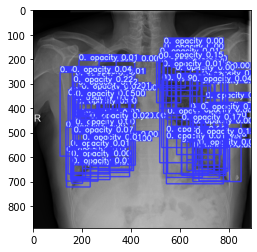

In [ ]:
plt.imshow(test)

In [ ]:
def yolo2voc(image_height, image_width, bboxes):
    """
    yolo => [xmid, ymid, w, h] (normalized)
    voc  => [x1, y1, x2, y2]

    """ 
    bboxes = bboxes.copy().astype(float) # otherwise all value will be 0 as voc_pascal dtype is np.int

    bboxes[..., [0, 2]] = bboxes[..., [0, 2]]* image_width
    bboxes[..., [1, 3]] = bboxes[..., [1, 3]]* image_height

    bboxes[..., [0, 1]] = bboxes[..., [0, 1]] - bboxes[..., [2, 3]]/2
    bboxes[..., [2, 3]] = bboxes[..., [0, 1]] + bboxes[..., [2, 3]]

    return bboxes

# Naive Yolov5 Inference

In [184]:
import glob
from tqdm import tqdm
preds_df_all = []

for fold in [0,1,2,3,4]:

    image_ids = []
    PredictionStrings = []

    for file_path in tqdm(glob.glob(f'runs{fold}/detect/exp/labels/*.txt')):
        #print(file_path)
        image_id = file_path.split('/')[-1].split('.')[0]
        #print(image_id)
        w, h = image_level_df.loc[image_level_df.id==image_id +"_image"][['width', 'height']].values[0]
        f = open(file_path, 'r')
        data = np.array(f.read().replace('\n', ' ').strip().split(' ')).astype(np.float32).reshape(-1, 6)
        data = data[:, [0, 5, 1, 2, 3, 4]]
        #print(data.shape[0])
        #print(data)
        bboxes = list(np.round(np.concatenate((data[:, :2], np.round(yolo2voc(h, w, data[:, 2:]))), axis =1).reshape(-1), 12).astype(str))
        for idx in range(len(bboxes)):
            bboxes[idx] = str(int(float(bboxes[idx]))) if idx%6!=1 else bboxes[idx]
        image_ids.append(image_id+"_image")
        PredictionStrings.append(' '.join(bboxes))


    full_df = image_level_df[image_level_df['fold']==fold].copy().reset_index(drop=True)
    preds_df = pd.DataFrame({'id':image_ids,'PredictionString':PredictionStrings}).reset_index(drop=True)
    preds_df_full = pd.merge(full_df, preds_df, on = 'id', how = 'left').fillna("none 1 0 0 1 1")
    preds_df_full = preds_df_full.drop_duplicates().reset_index(drop=True)
    preds_df_full['class_id'] = preds_df_full['none']
    preds_df_all.append(preds_df_full)


100%|██████████| 1247/1247 [00:04<00:00, 301.90it/s]

100%|██████████| 1247/1247 [00:04<00:00, 277.48it/s]

100%|██████████| 1243/1243 [00:03<00:00, 315.74it/s]

100%|██████████| 1246/1246 [00:05<00:00, 237.01it/s]

100%|██████████| 1244/1244 [00:04<00:00, 300.48it/s]


In [110]:
from google.colab import files
files.upload()

Saving binary2class_fold0_map894.csv to binary2class_fold0_map894.csv
Saving binary2class_fold1_map912.csv to binary2class_fold1_map912.csv
Saving binary2class_fold2_map882.csv to binary2class_fold2_map882.csv
Saving binary2class_fold3_map874.csv to binary2class_fold3_map874.csv
Saving binary2class_fold4_map893.csv to binary2class_fold4_map893.csv


{'binary2class_fold0_map894.csv': b'study_id,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance,fold,set,study,series,image,image_id,class_id,none1,none2\r\n00292f8c37bd,1,0,0,0,0,train,00292f8c37bd,73120b4a13cb,f6293b1c49e2,f6293b1c49e2,0,0.7163215,0.28375065\r\n00b33b3eb8d9,0,1,0,0,0,train,00b33b3eb8d9,6c8b814c685b,12a2dfb55b6f,12a2dfb55b6f,1,0.15885328,0.8408723\r\n00c74279c5b7,1,0,0,0,0,train,00c74279c5b7,ca867739fd1b,136af218f8df,136af218f8df,0,0.8557944,0.14515293\r\n00c83e33588f,0,0,1,0,0,train,00c83e33588f,2892280fbaaf,7e7d3afebf5d,7e7d3afebf5d,1,0.67618644,0.3241867\r\n00ccd633fb0e,1,0,0,0,0,train,00ccd633fb0e,8b7844d2b357,45742200dd51,45742200dd51,0,0.6189145,0.38189197\r\n0135d267f462,0,1,0,0,0,train,0135d267f462,9be6bcd43520,31376011baec,31376011baec,1,0.0057870746,0.9941677\r\n0142feaef82f,0,0,1,0,0,train,0142feaef82f,6d7d1d8bb1a6,f5451a98d684,f5451a98d684,0,0.4647308,0.5348103\r\n0142feaef82f,0,0,1,0,0,train,0142feaef82f,8f0c767d4e3f,55

In [111]:
twoclass0 = pd.read_csv("binary2class_fold0_map894.csv")
twoclass1 = pd.read_csv("binary2class_fold1_map912.csv")
twoclass2 = pd.read_csv("binary2class_fold2_map882.csv")
twoclass3 = pd.read_csv("binary2class_fold3_map874.csv")
twoclass4 = pd.read_csv("binary2class_fold4_map893.csv")


total_twoclass = pd.concat([twoclass0,twoclass1,twoclass2,twoclass3,twoclass4])

total_twoclass = total_twoclass[['image_id','none1']].reset_index(drop=True)
total_twoclass['image_id'] = total_twoclass['image_id']+"_image"
total_twoclass = total_twoclass.rename(columns={"none1":"twoclass_none"})

total_twoclass['id'] = total_twoclass['image_id']
two_class_df = total_twoclass.copy()

# More realistic version

In [ ]:
twoclass = True
#del preds_df_all[fold]['none']
for fold in [0,1,2,3,4]:
    
    preds_df_all[fold] = pd.merge(preds_df_all[fold], two_class_df[['id', 'twoclass_none']] , on = 'id', how = 'left')
    
    for i in tqdm(range(preds_df_all[fold].shape[0])):
        if preds_df_all[fold].loc[i,'PredictionString'] == "none 1 0 0 1 1":
            preds_df_all[fold].loc[i,'PredictionString']='0 1 0 0 1 1'
            continue
        sub_df_split = preds_df_all[fold].loc[i,'PredictionString'].split()
        #print(preds_df_all[fold].loc[i,'twoclass_none'])
        twoclass_none = preds_df_all[fold].loc[i,'twoclass_none']
        sub_df_list = []
        for j in range(int(len(sub_df_split) / 6)):
            sub_df_list.append('1')
            sub_df_list.append(str((float(sub_df_split[6 * j + 1])**0.84)*(1-twoclass_none)**0.16))
            sub_df_list.append(sub_df_split[6 * j + 2])
            sub_df_list.append(sub_df_split[6 * j + 3])
            sub_df_list.append(sub_df_split[6 * j + 4])
            sub_df_list.append(sub_df_split[6 * j + 5])
        preds_df_all[fold].loc[i,'PredictionString'] = ' '.join(sub_df_list)
        if twoclass:
            preds_df_all[fold].loc[i,'PredictionString'] = preds_df_all[fold].loc[i,'PredictionString'] + ' 0 ' + \
            str(preds_df_all[fold].loc[i,'twoclass_none']) + ' 0 0 1 1'
        else:
            pass

# More realistic + Sorting Version

In [187]:
twoclass = True
#del preds_df_all[fold]['none']
for fold in [0,1,2,3,4]:
    
    preds_df_all[fold] = pd.merge(preds_df_all[fold], two_class_df[['id', 'twoclass_none']] , on = 'id', how = 'left')
    
    for i in tqdm(range(preds_df_all[fold].shape[0])):
        if preds_df_all[fold].loc[i,'PredictionString'] == "none 1 0 0 1 1":
            preds_df_all[fold].loc[i,'PredictionString']='0 1 0 0 1 1'
            continue
        sub_df_split = preds_df_all[fold].loc[i,'PredictionString'].split()
        twoclass_none = preds_df_all[fold].loc[i,'twoclass_none']
        sub_df_list = []
        final_sub_df_list = []
        for j in range(int(len(sub_df_split) / 6)):
            
            sub_df_list.append(['1',
                                        (float(sub_df_split[6 * j + 1])**0.80)*(1-twoclass_none)**0.20,
                                        sub_df_split[6 * j + 2],
                                        sub_df_split[6 * j + 3],
                                        sub_df_split[6 * j + 4],
                                        sub_df_split[6 * j + 5]]
                                    )
            
        #print("before sub_df_list : ", sub_df_list)
        sub_df_list = sorted(sub_df_list, key = lambda x: x[1], reverse=True)
        for zz in range(len(sub_df_list)):
            sub_df_list[zz][1] = str(sub_df_list[zz][1])
            final_sub_df_list.extend(sub_df_list[zz])

        preds_df_all[fold].loc[i,'PredictionString'] = ' '.join(final_sub_df_list)

        if twoclass:
            preds_df_all[fold].loc[i,'PredictionString'] = preds_df_all[fold].loc[i,'PredictionString'] + ' 0 ' + \
            str(preds_df_all[fold].loc[i,'twoclass_none']) + ' 0 0 1 1'
        else:
            pass


100%|██████████| 1956/1956 [00:03<00:00, 614.34it/s]

100%|██████████| 1962/1962 [00:03<00:00, 628.10it/s]

100%|██████████| 1960/1960 [00:02<00:00, 701.03it/s]

100%|██████████| 1960/1960 [00:03<00:00, 540.06it/s]

100%|██████████| 1948/1948 [00:02<00:00, 671.29it/s]


# Just Adding

In [ ]:
twoclass = True
#del preds_df_all[fold]['none']
for fold in [0,1,2,3,4]:
    
    preds_df_all[fold] = pd.merge(preds_df_all[fold], two_class_df[['id', 'twoclass_none']] , on = 'id', how = 'left')
    
    for i in tqdm(range(preds_df_all[fold].shape[0])):
        if preds_df_all[fold].loc[i,'PredictionString'] == "none 1 0 0 1 1":
            preds_df_all[fold].loc[i,'PredictionString']='0 1 0 0 1 1'
            continue
        sub_df_split = preds_df_all[fold].loc[i,'PredictionString'].split()
        sub_df_list = []
        for j in range(int(len(sub_df_split) / 6)):
            sub_df_list.append('1')
            sub_df_list.append(sub_df_split[6 * j + 1])
            sub_df_list.append(sub_df_split[6 * j + 2])
            sub_df_list.append(sub_df_split[6 * j + 3])
            sub_df_list.append(sub_df_split[6 * j + 4])
            sub_df_list.append(sub_df_split[6 * j + 5])
        preds_df_all[fold].loc[i,'PredictionString'] = ' '.join(sub_df_list)
        if twoclass:
            preds_df_all[fold].loc[i,'PredictionString'] = preds_df_all[fold].loc[i,'PredictionString'] + ' 0 ' + \
            str(preds_df_all[fold].loc[i,'twoclass_none']) + ' 0 0 1 1'
        else:
            pass

100%|██████████| 1948/1948 [00:01<00:00, 985.25it/s]


In [179]:
!pip install pycocotools -q
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
class CovidDataEval:
    """Helper class for calculating the competition metric.
    
    You should remove the duplicated annoatations from the `true_df` dataframe
    before using this script. Otherwise it may give incorrect results.

        >>> covideval = CovidDataEval(valid_df)
        >>> cocoEvalResults = covideval.evaluate(pred_df)

    Arguments:
        true_df: pd.DataFrame Clean (no duplication) Training/Validating dataframe.

    Authors:
        Peter (https://kaggle.com/pestipeti)

    See:
        https://www.kaggle.com/pestipeti/competition-metric-map-0-4

    Returns: None
    
    """
    def __init__(self, true_df, study=False):
        
        self.true_df = true_df
        self.study = study

        self.image_ids = true_df["id"].unique()
        self.annotations = {
            "type": "instances",
            "images": self.__gen_images(self.image_ids),
            "categories": self.__gen_categories(self.true_df),
            "annotations": self.__gen_annotations(self.true_df, self.image_ids)
        }
        
        self.predictions = {
            "images": self.annotations["images"].copy(),
            "categories": self.annotations["categories"].copy(),
            "annotations": None
        }

        
    def __gen_images(self, image_ids):
        print("Generating image data...")
        results = []

        for idx, image_id in enumerate(image_ids):

            # Add image identification.
            results.append({
                "id": idx,
            })
            
        return results
    
    
    def __gen_categories(self, df):
        print("Generating category data...")
        
        if self.study:
        
            if "class_name" not in df.columns:
                df["class_name"] = df["class_id"]

            cats = df[["class_name", "class_id"]]
            cats = cats.drop_duplicates().sort_values(by='class_id').values

            results = []

            for cat in cats:
                results.append({
                    "id": cat[1],
                    "name": cat[0],
                    "supercategory": "none",
                })

            return results
        
        else:
            results = []
            
            cats = df[["label","none"]]
            cats = cats.drop_duplicates().sort_values(by='label').values
            for cat in cats:
                results.append({
                    "id": cat[1],
                    "name": cat[0].split(" ")[0],
                    "supercategory": " ",
                })
            return results
        
    def __decode_prediction_string(self, pred_str):
        data = np.array(list(pred_str.split(" ")))
        return data.reshape(-1, 6)    
    
    def __gen_annotations(self, df, image_ids):
        print("Generating annotation data...")
        k = 0
        results = []
        
        for i, row in df.iterrows():
            
            image_id = row["id"]
            preds = self.__decode_prediction_string(row["label"])

            for j, pred in enumerate(preds):

                results.append({
                    "id": k,
                    "image_id": int(np.where(image_ids == image_id)[0]),
                    "category_id": int(pred[0]),
                    "bbox": np.array([
                        float(pred[2]), float(pred[3]), float(pred[4]), float(pred[5])
                    ]),
                    "segmentation": [],
                    "ignore": 0,
                    "area": (float(pred[4]) - float(pred[2])) * (float(pred[5]) - float(pred[3])),
                    "iscrowd": 0,
                    "score": float(pred[1])
                })

                k += 1
                
        return results
                
    
    def __gen_predictions(self, df, image_ids):
        print("Generating prediction data...")
        k = 0
        results = []
        
        for i, row in df.iterrows():
            
            image_id = row["id"]
            preds = self.__decode_prediction_string(row["PredictionString"])
            for j, pred in enumerate(preds):

                results.append({
                    "id": k,
                    "image_id": int(np.where(image_ids == image_id)[0]),
                    "category_id": int(pred[0]),
                    "bbox": np.array([
                        float(pred[2]), float(pred[3]), float(pred[4]), float(pred[5])
                    ]),
                    "segmentation": [],
                    "ignore": 0,
                    "area": (float(pred[4]) - float(pred[2])) * (float(pred[5]) - float(pred[3])),
                    "iscrowd": 0,
                    "score": float(pred[1])
                })

                k += 1
                
        return results
                
    def evaluate(self, pred_df, n_imgs = -1):
        """Evaluating your results
        
        Arguments:
            pred_df: pd.DataFrame your predicted results in the
                     competition output format.

            n_imgs:  int Number of images use for calculating the
                     result.All of the images if `n_imgs` <= 0
                     
        Returns:
            COCOEval object
        """
        
        if pred_df is not None:
            self.predictions["annotations"] = self.__gen_predictions(pred_df, self.image_ids)

        coco_ds = COCO()
        coco_ds.dataset = self.annotations
        coco_ds.createIndex()
        
        coco_dt = COCO()
        coco_dt.dataset = self.predictions
        coco_dt.createIndex()
        
        imgIds=sorted(coco_ds.getImgIds())
        
        if n_imgs > 0:
            imgIds = np.random.choice(imgIds, n_imgs)

        cocoEval = COCOeval(coco_ds, coco_dt, 'bbox')
        cocoEval.params.imgIds  = imgIds
        cocoEval.params.useCats = True
        cocoEval.params.iouType = "bbox"
        cocoEval.params.iouThrs = np.array([0.5])

        cocoEval.evaluate()
        cocoEval.accumulate()
        cocoEval.summarize()
        
        return cocoEval

In [180]:
study_scores=[
0.385,
0.385,
0.385,
0.385,
0.385]

In [ ]:
#preds_df_all[fold]['id'] = preds_df_all[fold]['id'] +"_image"
#image_level_df['id'] = image_level_df['id'] + "_image"

In [181]:
fold_mAP=[]
for fold in [0,1,2,3,4]:
    covideval=CovidDataEval(image_level_df[image_level_df["fold"]==fold].drop_duplicates().reset_index(drop=True))
    cocoEvalRes = covideval.evaluate(preds_df_all[fold].drop_duplicates().reset_index(drop=True))
    fold_mAP.append(cocoEvalRes.stats[1]*1/3)

Generating image data...
Generating category data...
Generating annotation data...
Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.65s).
Accumulating evaluation results...
DONE (t=0.22s).
 Average Precision  (AP) @[ IoU=0.50:0.50 | area=   all | maxDets=100 ] = 0.784
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.784
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.50 | area= small | maxDets=100 ] = 0.737
 Average Precision  (AP) @[ IoU=0.50:0.50 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.50 | area= large | maxDets=100 ] = 0.830
 Average Recall     (AR) @[ IoU=0.50:0.50 | area=   all | maxDets=  1 ] = 0.622
 Average Recall     (AR) @[ IoU=0.50:0.50 | area=   all | maxDets= 10 ] = 0.964
 Average Recall     (AR) @[ IoU=0.50:0.50 | area

# just add

In [ ]:
for fold in [0,1,2,3,4]:
    print(f"\nStudy Level mAP Score fold {fold+1}: {study_scores[fold]}\nImage Level mAP Score fold {fold+1}: {fold_mAP[fold]}")
    
print(f"\nStudy Level mAP Score: {np.array(study_scores).mean()}\nImage Level mAP Score: {np.array(fold_mAP).mean()}\n\nOverall mAP: {np.array(study_scores).mean()+np.array(fold_mAP).mean()}")


Study Level mAP Score fold 1: 0.385
Image Level mAP Score fold 1: 0.24411920546657306

Study Level mAP Score fold 2: 0.385
Image Level mAP Score fold 2: 0.24907480997007425

Study Level mAP Score fold 3: 0.385
Image Level mAP Score fold 3: 0.24085841005215858

Study Level mAP Score fold 4: 0.385
Image Level mAP Score fold 4: 0.23788494486015718

Study Level mAP Score fold 5: 0.385
Image Level mAP Score fold 5: 0.24658568907903974

Study Level mAP Score: 0.385
Image Level mAP Score: 0.24370461188560055

Overall mAP: 0.6287046118856006


# More realistic

In [ ]:
for fold in [0,1,2,3,4]:
    print(f"\nStudy Level mAP Score fold {fold+1}: {study_scores[fold]}\nImage Level mAP Score fold {fold+1}: {fold_mAP[fold]}")
    
print(f"\nStudy Level mAP Score: {np.array(study_scores).mean()}\nImage Level mAP Score: {np.array(fold_mAP).mean()}\n\nOverall mAP: {np.array(study_scores).mean()+np.array(fold_mAP).mean()}")


Study Level mAP Score fold 1: 0.385
Image Level mAP Score fold 1: 0.24581191493361776

Study Level mAP Score fold 2: 0.385
Image Level mAP Score fold 2: 0.2510184668089013

Study Level mAP Score fold 3: 0.385
Image Level mAP Score fold 3: 0.2428340110708199

Study Level mAP Score fold 4: 0.385
Image Level mAP Score fold 4: 0.23932407414347226

Study Level mAP Score fold 5: 0.385
Image Level mAP Score fold 5: 0.2492640162847454

Study Level mAP Score: 0.385
Image Level mAP Score: 0.24565049664831135

Overall mAP: 0.6306504966483113


# After Sorting

In [ ]:
for fold in [0,1,2,3,4]:
    print(f"\nStudy Level mAP Score fold {fold+1}: {study_scores[fold]}\nImage Level mAP Score fold {fold+1}: {fold_mAP[fold]}")
    
print(f"\nStudy Level mAP Score: {np.array(study_scores).mean()}\nImage Level mAP Score: {np.array(fold_mAP).mean()}\n\nOverall mAP: {np.array(study_scores).mean()+np.array(fold_mAP).mean()}")


Study Level mAP Score fold 1: 0.385
Image Level mAP Score fold 1: 0.24581191493361776

Study Level mAP Score fold 2: 0.385
Image Level mAP Score fold 2: 0.25117302788385093

Study Level mAP Score fold 3: 0.385
Image Level mAP Score fold 3: 0.2429564234812358

Study Level mAP Score fold 4: 0.385
Image Level mAP Score fold 4: 0.23932407414347226

Study Level mAP Score fold 5: 0.385
Image Level mAP Score fold 5: 0.24928180412138787

Study Level mAP Score: 0.385
Image Level mAP Score: 0.2457094489127129

Overall mAP: 0.630709448912713


# yolo 512로 훈련한  것을 640으로 예측(large) 640으로 훈련한 것을 640으로 예측 ensemble

In [ ]:
for fold in [0,1,2,3,4]:
    print(f"\nStudy Level mAP Score fold {fold+1}: {study_scores[fold]}\nImage Level mAP Score fold {fold+1}: {fold_mAP[fold]}")
    
print(f"\nStudy Level mAP Score: {np.array(study_scores).mean()}\nImage Level mAP Score: {np.array(fold_mAP).mean()}\n\nOverall mAP: {np.array(study_scores).mean()+np.array(fold_mAP).mean()}")


Study Level mAP Score fold 1: 0.385
Image Level mAP Score fold 1: 0.2458492834823887

Study Level mAP Score fold 2: 0.385
Image Level mAP Score fold 2: 0.2513948366712562

Study Level mAP Score fold 3: 0.385
Image Level mAP Score fold 3: 0.24301810469878204

Study Level mAP Score fold 4: 0.385
Image Level mAP Score fold 4: 0.2379399727988668

Study Level mAP Score fold 5: 0.385
Image Level mAP Score fold 5: 0.24982997114350958

Study Level mAP Score: 0.385
Image Level mAP Score: 0.24560643375896066

Overall mAP: 0.6306064337589606


# yolo 512로 훈련한  것을 640으로 예측(large) 640으로 훈련한 것을 640으로 예측 ensemble + augment

In [ ]:
for fold in [0,1,2,3,4]:
    print(f"\nStudy Level mAP Score fold {fold+1}: {study_scores[fold]}\nImage Level mAP Score fold {fold+1}: {fold_mAP[fold]}")
    
print(f"\nStudy Level mAP Score: {np.array(study_scores).mean()}\nImage Level mAP Score: {np.array(fold_mAP).mean()}\n\nOverall mAP: {np.array(study_scores).mean()+np.array(fold_mAP).mean()}")


Study Level mAP Score fold 1: 0.385
Image Level mAP Score fold 1: 0.24927640344874924

Study Level mAP Score fold 2: 0.385
Image Level mAP Score fold 2: 0.2534635262850052

Study Level mAP Score fold 3: 0.385
Image Level mAP Score fold 3: 0.24670861837964406

Study Level mAP Score fold 4: 0.385
Image Level mAP Score fold 4: 0.23946222689556243

Study Level mAP Score fold 5: 0.385
Image Level mAP Score fold 5: 0.25311880217787297

Study Level mAP Score: 0.385
Image Level mAP Score: 0.2484059154373668

Overall mAP: 0.6334059154373668


# yolo 512로 훈련한  것을 512으로 예측(large) 640으로 훈련한 것을 512으로 예측 ensemble + augment

In [ ]:
for fold in [0,1,2,3,4]:
    print(f"\nStudy Level mAP Score fold {fold+1}: {study_scores[fold]}\nImage Level mAP Score fold {fold+1}: {fold_mAP[fold]}")
    
print(f"\nStudy Level mAP Score: {np.array(study_scores).mean()}\nImage Level mAP Score: {np.array(fold_mAP).mean()}\n\nOverall mAP: {np.array(study_scores).mean()+np.array(fold_mAP).mean()}")


Study Level mAP Score fold 1: 0.385
Image Level mAP Score fold 1: 0.2489913813292032

Study Level mAP Score fold 2: 0.385
Image Level mAP Score fold 2: 0.2525448221535464

Study Level mAP Score fold 3: 0.385
Image Level mAP Score fold 3: 0.24714005665077668

Study Level mAP Score fold 4: 0.385
Image Level mAP Score fold 4: 0.2381499692825412

Study Level mAP Score fold 5: 0.385
Image Level mAP Score fold 5: 0.25533171605069965

Study Level mAP Score: 0.385
Image Level mAP Score: 0.24843158909335342

Overall mAP: 0.6334315890933534


# Just 512 size Version

In [189]:
for fold in [0,1,2,3,4]:
    print(f"\nStudy Level mAP Score fold {fold+1}: {study_scores[fold]}\nImage Level mAP Score fold {fold+1}: {fold_mAP[fold]}")
    
print(f"\nStudy Level mAP Score: {np.array(study_scores).mean()}\nImage Level mAP Score: {np.array(fold_mAP).mean()}\n\nOverall mAP: {np.array(study_scores).mean()+np.array(fold_mAP).mean()}")


Study Level mAP Score fold 1: 0.385
Image Level mAP Score fold 1: 0.24884727223289962

Study Level mAP Score fold 2: 0.385
Image Level mAP Score fold 2: 0.2539249755640223

Study Level mAP Score fold 3: 0.385
Image Level mAP Score fold 3: 0.24699589604514485

Study Level mAP Score fold 4: 0.385
Image Level mAP Score fold 4: 0.23719219899896063

Study Level mAP Score fold 5: 0.385
Image Level mAP Score fold 5: 0.25589842399933466

Study Level mAP Score: 0.385
Image Level mAP Score: 0.2485717533680724

Overall mAP: 0.6335717533680725


# Gray Version

In [149]:
for fold in [0,1,2,3,4]:
    print(f"\nStudy Level mAP Score fold {fold+1}: {study_scores[fold]}\nImage Level mAP Score fold {fold+1}: {fold_mAP[fold]}")
    
print(f"\nStudy Level mAP Score: {np.array(study_scores).mean()}\nImage Level mAP Score: {np.array(fold_mAP).mean()}\n\nOverall mAP: {np.array(study_scores).mean()+np.array(fold_mAP).mean()}")


Study Level mAP Score fold 1: 0.385
Image Level mAP Score fold 1: 0.2611794752569865

Study Level mAP Score fold 2: 0.385
Image Level mAP Score fold 2: 0.2671935703513693

Study Level mAP Score fold 3: 0.385
Image Level mAP Score fold 3: 0.24705254323989978

Study Level mAP Score fold 4: 0.385
Image Level mAP Score fold 4: 0.25289783656709325

Study Level mAP Score fold 5: 0.385
Image Level mAP Score fold 5: 0.2644973671886228

Study Level mAP Score: 0.385
Image Level mAP Score: 0.25856415852079434

Overall mAP: 0.6435641585207943


# Gray Ensemble Version

In [172]:
for fold in [0,1,2,3,4]:
    print(f"\nStudy Level mAP Score fold {fold+1}: {study_scores[fold]}\nImage Level mAP Score fold {fold+1}: {fold_mAP[fold]}")
    
print(f"\nStudy Level mAP Score: {np.array(study_scores).mean()}\nImage Level mAP Score: {np.array(fold_mAP).mean()}\n\nOverall mAP: {np.array(study_scores).mean()+np.array(fold_mAP).mean()}")


Study Level mAP Score fold 1: 0.385
Image Level mAP Score fold 1: 0.2609751077061056

Study Level mAP Score fold 2: 0.385
Image Level mAP Score fold 2: 0.26802582615097054

Study Level mAP Score fold 3: 0.385
Image Level mAP Score fold 3: 0.24964156315155225

Study Level mAP Score fold 4: 0.385
Image Level mAP Score fold 4: 0.2522900699003597

Study Level mAP Score fold 5: 0.385
Image Level mAP Score fold 5: 0.26448512830208865

Study Level mAP Score: 0.385
Image Level mAP Score: 0.25908353904221537

Overall mAP: 0.6440835390422154


# Gray Ensemble 84 16 Version

In [182]:
for fold in [0,1,2,3,4]:
    print(f"\nStudy Level mAP Score fold {fold+1}: {study_scores[fold]}\nImage Level mAP Score fold {fold+1}: {fold_mAP[fold]}")
    
print(f"\nStudy Level mAP Score: {np.array(study_scores).mean()}\nImage Level mAP Score: {np.array(fold_mAP).mean()}\n\nOverall mAP: {np.array(study_scores).mean()+np.array(fold_mAP).mean()}")


Study Level mAP Score fold 1: 0.385
Image Level mAP Score fold 1: 0.2611966359546469

Study Level mAP Score fold 2: 0.385
Image Level mAP Score fold 2: 0.2683609817381625

Study Level mAP Score fold 3: 0.385
Image Level mAP Score fold 3: 0.24979807573987678

Study Level mAP Score fold 4: 0.385
Image Level mAP Score fold 4: 0.2528468190434528

Study Level mAP Score fold 5: 0.385
Image Level mAP Score fold 5: 0.2647993887464861

Study Level mAP Score: 0.385
Image Level mAP Score: 0.259400380244525

Overall mAP: 0.6444003802445251


In [ ]:
import gc
gc.collect()

94

# Inference Plot

In [ ]:
import glob
image_ids = []
PredictionStrings = []

for file_path in tqdm(glob.glob('runs2/detect/exp/labels/*txt')):
    image_id = file_path.split('/')[-1].split('.')[0]
    w, h = test_df.loc[test_df.image_id==image_id,['width', 'height']].values[0]
    f = open(file_path, 'r')
    data = np.array(f.read().replace('\n', ' ').strip().split(' ')).astype(np.float32).reshape(-1, 6)
    data = data[:, [0, 5, 1, 2, 3, 4]]
    bboxes = list(np.round(np.concatenate((data[:, :2], np.round(yolo2voc(h, w, data[:, 2:]))), axis =1).reshape(-1), 1).astype(str))
    for idx in range(len(bboxes)):
        bboxes[idx] = str(int(float(bboxes[idx]))) if idx%6!=1 else bboxes[idx]
    image_ids.append(image_id)
    PredictionStrings.append(' '.join(bboxes))

100%|██████████| 3000/3000 [00:06<00:00, 460.14it/s]


In [ ]:
test_df

image_id  width  height
0     83caa8a85e03606cf57e49147d7ac569   2304    2880
1     7550347fa2bb96c2354a3716dfa3a69c   2538    3095
2     74b23792db329cff5843e36efb8aa65a   2788    3120
3     94568a546be103177cb582d3e91cd2d8   1994    2430
4     6da36354fc904b63bc03eb3884e0c35c   2056    2376
...                                ...    ...     ...
2995  7f5503caa936a623b4388fbd88e890c5   2642    3170
2996  c97e54a78bab9c05ce2e04fe6c284bcd   3072    3072
2997  33218cf183c1224a74ccfb514e827e15   2336    2836
2998  04b700c4815f088728db9f093c739707   2484    3064
2999  14da9051525bd2504dd56938f92644ef   1994    2430

[3000 rows x 3 columns]

# For NMS IOU THRESHOLD AT 0.5

In [ ]:
def yolo2xyxy(image_height, image_width, bboxes):
    bboxes = bboxes.copy().astype(float)
    bboxes[..., [0, 2]] = bboxes[..., [0, 2]] * image_width
    bboxes[..., [1, 3]] = bboxes[..., [1, 3]] * image_height

    bboxes[..., [0, 1]] = bboxes[..., [0, 1]] - (bboxes[..., [2, 3]] / 2)
    bboxes[..., [2, 3]] = bboxes[..., [0, 1]] + bboxes[..., [2, 3]]

    return bboxes

In [ ]:
import glob
image_ids = []
PredictionStrings = []
total_concat = pd.DataFrame({'image_id':[], 'class_id':[], 'pred':[], 'x_min':[], 'y_min':[], 'x_max':[], 'y_max':[]})
for fold in range(5):

  for i, file_path in enumerate(glob.glob(f'runs{fold}/detect/exp/labels/*txt')):
    image_id = file_path.split('/')[-1].split('.')[0]
    w, h = test_df.loc[test_df.image_id==image_id,['width', 'height']].values[0]
    f = open(file_path, 'r')
    data = np.array(f.read().replace('\n', ' ').strip().split(' ')).astype(np.float32).reshape(-1, 6)
    data = data[:, [0, 5, 1, 2, 3, 4]]
    data = np.concatenate((data[:, :2], np.round(yolo2xyxy(IMAGE_SIZE, IMAGE_SIZE, data[:, 2:]))), axis =1)
    temp_concat = pd.DataFrame({'image_id':[image_id]*len(data), 'class_id':data[:,0], 'pred':data[:,1], 'x_min':data[:,2], 'y_min':data[:,3], 'x_max':data[:,4], 'y_max':data[:,5]})
    total_concat = pd.concat([total_concat, temp_concat], axis=0)
    
print(total_concat)
    #data[:,2:] = data[:,2:]
    #bboxes = list(np.round(np.concatenate((data[:, :2], np.round(yolo2voc(h, w, data[:, 2:]))), axis =1).reshape(-1), 1).astype(str))
    #for idx in range(len(bboxes)):
    #    bboxes[idx] = str(int(float(bboxes[idx]))) if idx%6!=1 else bboxes[idx]
    #image_ids.append(image_id)
    #PredictionStrings.append(' '.join(bboxes))

                            image_id  class_id      pred  ...  y_min   x_max  y_max
0   12202997d3fc0d506d2514a4c1995d15       7.0  0.001103  ...  344.0   757.0  461.0
1   12202997d3fc0d506d2514a4c1995d15       8.0  0.001352  ...  208.0  1000.0  808.0
2   12202997d3fc0d506d2514a4c1995d15       6.0  0.001379  ...  208.0  1000.0  808.0
3   12202997d3fc0d506d2514a4c1995d15       5.0  0.001502  ...  208.0  1000.0  808.0
4   12202997d3fc0d506d2514a4c1995d15      11.0  0.002132  ...  201.0   441.0  226.0
..                               ...       ...       ...  ...    ...     ...    ...
6   4d2071baccfd994701c3a5ceb3f64f6f      11.0  0.010170  ...   94.0   742.0  139.0
7   4d2071baccfd994701c3a5ceb3f64f6f      11.0  0.030655  ...  104.0   399.0  130.0
8   4d2071baccfd994701c3a5ceb3f64f6f      11.0  0.032867  ...  104.0   336.0  149.0
9   4d2071baccfd994701c3a5ceb3f64f6f      11.0  0.035614  ...   96.0   714.0  123.0
10  4d2071baccfd994701c3a5ceb3f64f6f       3.0  0.758789  ...  450.0   814.0

In [ ]:
total_concat['x_max'].max()

1024.0

# Ensemble NMS

In [ ]:
!pip install ensemble_boxes
from ensemble_boxes import *
import warnings
from collections import Counter
from tqdm import tqdm

from path import Path
test_imagepaths = ("test/" + total_concat['image_id'] + ".png").unique()
print("Number of Images with abnormalities:",len(test_imagepaths))
anno_count = df_for_plot.shape[0]
print("Number of Annotations with abnormalities:", anno_count)
Path("train/" + imagepaths[0] + ".png").stem

iou_thr = 0.4
skip_box_thr = 0.0001
viz_images = []
paths = []
total_boxes = []
total_labels = []
total_scores = []
for i, path in tqdm(enumerate(test_imagepaths)):

    #img_array  = cv2.imread(path)
    image_basename = Path(path).stem
    #print(f"(\'{image_basename}\', \'{path}\')")
    img_annotations = total_concat[total_concat.image_id==image_basename]

    boxes_viz = img_annotations[['x_min', 'y_min', 'x_max', 'y_max']].to_numpy().tolist()
    labels_viz = img_annotations['class_id'].to_numpy().tolist()
    
    print("Bboxes before nms:\n", len(boxes_viz))
    #print("Labels before nms:\n", labels_viz)
    
    ## Visualize Original Bboxes
    #img_before = img_array.copy()
    for box, label in zip(boxes_viz, labels_viz):
        x_min, y_min, x_max, y_max = (box[0], box[1], box[2], box[3])
        color = label2color[int(label)]
        #img_before = draw_bbox(img_before, list(np.int_(box)), viz_labels[label], color)
    #viz_images.append(img_before)
    
    boxes_list = []
    scores_list = []
    labels_list = []
    weights = []
    
    boxes_single = []
    labels_single = []
    scores_single = []

    cls_ids = img_annotations['class_id'].unique().tolist()
    count_dict = Counter(img_annotations['class_id'].tolist())
    #print(count_dict)

    for cid in cls_ids:       
        ## Performing Fusing operation only for multiple bboxes with the same label
        if count_dict[cid]==1:
            labels_single.append(cid)
            boxes_single.append(img_annotations[img_annotations.class_id==cid][['x_min', 'y_min', 'x_max', 'y_max']].to_numpy().squeeze().tolist())
            scores_single.append(img_annotations[img_annotations.class_id==cid][['pred']].to_numpy().squeeze().tolist())

        else:
            cls_list =img_annotations[img_annotations.class_id==cid]['class_id'].tolist()
            labels_list.append(cls_list)
            bbox = img_annotations[img_annotations.class_id==cid][['x_min', 'y_min', 'x_max', 'y_max']].to_numpy()
            ## Normalizing Bbox by Image Width and Height
            bbox = bbox/(IMAGE_SIZE, IMAGE_SIZE, IMAGE_SIZE, IMAGE_SIZE)
            bbox = np.clip(bbox, 0, 1)
            score = img_annotations[img_annotations.class_id==cid][['pred']].to_numpy().squeeze().tolist()
            #print(scores)
            #print(bbox, scores)
            boxes_list.append(bbox.tolist())
            scores_list.append(score)

            weights.append(1)
            
    # Perform NMS
    #print(boxes)
    if len(boxes_list) > 0:
        #print("boxes", boxes, "scores",scores, 'box_labels',box_labels)
        #print("before", labels_list)
        #print(scores_list)
        #print(boxes_list)
        boxes, scores, box_labels = nms(boxes_list, scores_list, labels_list, weights=None, iou_thr=iou_thr)
        #print("after", box_labels, scores, boxes)
        #print(len(boxes), len(scores))
        boxes = boxes*(IMAGE_SIZE, IMAGE_SIZE, IMAGE_SIZE, IMAGE_SIZE)
        boxes = boxes.round(1).tolist()
        box_labels = box_labels.astype(int).tolist()
        scores = scores.tolist()

    boxes.extend(boxes_single)

    box_labels.extend(labels_single)
    scores.extend(scores_single)
    
    paths.extend([path]*len(boxes))
    total_boxes.extend(boxes)
    total_labels.extend(box_labels)
    total_scores.extend(scores)
    print("Bboxes after nms:\n", len(boxes))

1it [00:00,  8.46it/s]

Number of Images with abnormalities: 3000
Number of Annotations with abnormalities: 36096
Bboxes before nms:
 362
Bboxes after nms:
 75
Bboxes before nms:
 617


3it [00:00,  8.79it/s]

Bboxes after nms:
 133
Bboxes before nms:
 233
Bboxes after nms:
 56
Bboxes before nms:
 254


5it [00:00,  8.59it/s]

Bboxes after nms:
 78
Bboxes before nms:
 1083
Bboxes after nms:
 270
Bboxes before nms:
 696


7it [00:00,  8.64it/s]

Bboxes after nms:
 145
Bboxes before nms:
 226
Bboxes after nms:
 55
Bboxes before nms:
 188


10it [00:01,  8.98it/s]

Bboxes after nms:
 60
Bboxes before nms:
 807
Bboxes after nms:
 164
Bboxes before nms:
 179
Bboxes after nms:
 47


13it [00:01,  9.55it/s]

Bboxes before nms:
 136
Bboxes after nms:
 30
Bboxes before nms:
 314
Warning. Removed 1 boxes with zero area!
Bboxes after nms:
 81
Bboxes before nms:
 278
Bboxes after nms:
 75


15it [00:01,  9.16it/s]

Bboxes before nms:
 304
Bboxes after nms:
 77
Bboxes before nms:
 933
Bboxes after nms:
 208
Bboxes before nms:
 129


18it [00:01,  9.35it/s]

Bboxes after nms:
 52
Bboxes before nms:
 491
Bboxes after nms:
 119
Bboxes before nms:
 227
Bboxes after nms:
 58


20it [00:02,  8.98it/s]

Bboxes before nms:
 284
Bboxes after nms:
 97
Bboxes before nms:
 1179
Bboxes after nms:
 251
Bboxes before nms:
 1117


22it [00:02,  8.75it/s]

Bboxes after nms:
 281
Bboxes before nms:
 989
Bboxes after nms:
 210
Bboxes before nms:
 326


23it [00:02,  8.83it/s]

Bboxes after nms:
 100
Bboxes before nms:
 269
Bboxes after nms:
 63
Bboxes before nms:
 224


25it [00:02,  9.06it/s]

Bboxes after nms:
 63
Bboxes before nms:
 134
Bboxes after nms:
 39
Bboxes before nms:
 983


28it [00:03,  9.15it/s]

Bboxes after nms:
 214
Bboxes before nms:
 384
Bboxes after nms:
 82
Bboxes before nms:
 1066


30it [00:03,  8.94it/s]

Bboxes after nms:
 222
Bboxes before nms:
 965
Bboxes after nms:
 197
Bboxes before nms:
 246


33it [00:03,  9.53it/s]

Bboxes after nms:
 76
Bboxes before nms:
 148
Bboxes after nms:
 47
Bboxes before nms:
 132
Bboxes after nms:
 45


35it [00:03,  9.56it/s]

Bboxes before nms:
 153
Bboxes after nms:
 58
Bboxes before nms:
 206
Bboxes after nms:
 48
Bboxes before nms:
 599


36it [00:03,  9.23it/s]

Bboxes after nms:
 113
Bboxes before nms:
 124
Bboxes after nms:
 39
Bboxes before nms:
 468


39it [00:04,  9.34it/s]

Bboxes after nms:
 102
Bboxes before nms:
 221
Bboxes after nms:
 65
Bboxes before nms:
 526


41it [00:04,  9.19it/s]

Bboxes after nms:
 118
Bboxes before nms:
 318
Bboxes after nms:
 112
Bboxes before nms:
 736


43it [00:04,  8.79it/s]

Bboxes after nms:
 164
Bboxes before nms:
 1396
Bboxes after nms:
 316
Bboxes before nms:
 487


45it [00:04,  8.92it/s]

Bboxes after nms:
 121
Bboxes before nms:
 1057
Bboxes after nms:
 238
Bboxes before nms:
 311


47it [00:05,  8.93it/s]

Bboxes after nms:
 81
Bboxes before nms:
 578
Bboxes after nms:
 162
Bboxes before nms:
 170


50it [00:05,  9.37it/s]

Bboxes after nms:
 40
Bboxes before nms:
 367
Bboxes after nms:
 101
Bboxes before nms:
 398
Bboxes after nms:
 105


52it [00:05,  9.59it/s]

Bboxes before nms:
 248
Bboxes after nms:
 64
Bboxes before nms:
 427
Bboxes after nms:
 107
Bboxes before nms:
 179


54it [00:05,  9.68it/s]

Bboxes after nms:
 48
Bboxes before nms:
 249
Bboxes after nms:
 69
Bboxes before nms:
 430


57it [00:06,  9.67it/s]

Bboxes after nms:
 113
Bboxes before nms:
 243
Bboxes after nms:
 69
Bboxes before nms:
 183
Bboxes after nms:
 62


58it [00:06,  9.34it/s]

Bboxes before nms:
 661
Bboxes after nms:
 132
Bboxes before nms:
 234
Bboxes after nms:
 75


61it [00:06,  9.07it/s]

Bboxes before nms:
 278
Bboxes after nms:
 72
Bboxes before nms:
 762
Bboxes after nms:
 163


63it [00:06,  9.11it/s]

Bboxes before nms:
 2261
Bboxes after nms:
 494
Bboxes before nms:
 345
Bboxes after nms:
 104


65it [00:06,  9.42it/s]

Bboxes before nms:
 104
Bboxes after nms:
 34
Bboxes before nms:
 240
Bboxes after nms:
 70
Bboxes before nms:
 166
Bboxes after nms:
 47


67it [00:07,  9.42it/s]

Bboxes before nms:
 1076
Bboxes after nms:
 236
Bboxes before nms:
 292
Bboxes after nms:
 72


71it [00:07, 10.02it/s]

Bboxes before nms:
 107
Bboxes after nms:
 28
Bboxes before nms:
 228
Bboxes after nms:
 52
Bboxes before nms:
 374
Bboxes after nms:
 87


73it [00:07,  9.82it/s]

Bboxes before nms:
 849
Bboxes after nms:
 189
Bboxes before nms:
 158
Bboxes after nms:
 44


75it [00:07,  9.78it/s]

Bboxes before nms:
 207
Bboxes after nms:
 52
Bboxes before nms:
 477
Bboxes after nms:
 122


77it [00:08,  9.32it/s]

Bboxes before nms:
 918
Bboxes after nms:
 219
Bboxes before nms:
 365
Bboxes after nms:
 90
Bboxes before nms:
 239


79it [00:08,  8.99it/s]

Bboxes after nms:
 70
Bboxes before nms:
 219
Bboxes after nms:
 71
Bboxes before nms:
 611


81it [00:08,  8.89it/s]

Bboxes after nms:
 161
Bboxes before nms:
 1122
Bboxes after nms:
 254
Bboxes before nms:
 430


83it [00:08,  8.99it/s]

Bboxes after nms:
 113
Bboxes before nms:
 331
Bboxes after nms:
 109
Bboxes before nms:
 150


86it [00:09,  9.25it/s]

Bboxes after nms:
 37
Bboxes before nms:
 415
Bboxes after nms:
 111
Bboxes before nms:
 243
Bboxes after nms:
 69


87it [00:09,  9.10it/s]

Bboxes before nms:
 935
Bboxes after nms:
 213
Bboxes before nms:
 291
Bboxes after nms:
 84


90it [00:09,  9.39it/s]

Bboxes before nms:
 129
Bboxes after nms:
 44
Bboxes before nms:
 467
Bboxes after nms:
 110
Bboxes before nms:
 144


92it [00:09,  9.46it/s]

Bboxes after nms:
 47
Bboxes before nms:
 195
Bboxes after nms:
 52
Bboxes before nms:
 159


94it [00:10,  9.70it/s]

Bboxes after nms:
 43
Bboxes before nms:
 160
Bboxes after nms:
 37
Bboxes before nms:
 180
Bboxes after nms:
 69
Bboxes before nms:
 504


97it [00:10,  9.75it/s]

Bboxes after nms:
 116
Bboxes before nms:
 227
Bboxes after nms:
 54
Bboxes before nms:
 308
Bboxes after nms:
 72


100it [00:10,  9.77it/s]

Bboxes before nms:
 349
Bboxes after nms:
 94
Bboxes before nms:
 233
Bboxes after nms:
 53
Bboxes before nms:
 528


102it [00:10,  9.38it/s]

Bboxes after nms:
 141
Bboxes before nms:
 717
Bboxes after nms:
 154
Bboxes before nms:
 271


104it [00:11,  9.47it/s]

Bboxes after nms:
 76
Bboxes before nms:
 153
Bboxes after nms:
 53
Bboxes before nms:
 268
Bboxes after nms:
 68


106it [00:11,  9.78it/s]

Bboxes before nms:
 210
Bboxes after nms:
 55
Bboxes before nms:
 132
Bboxes after nms:
 36
Bboxes before nms:
 507


109it [00:11,  9.38it/s]

Bboxes after nms:
 111
Bboxes before nms:
 327
Bboxes after nms:
 85
Bboxes before nms:
 320


111it [00:11,  9.36it/s]

Bboxes after nms:
 83
Bboxes before nms:
 236
Bboxes after nms:
 55
Bboxes before nms:
 169


113it [00:12,  9.44it/s]

Bboxes after nms:
 50
Bboxes before nms:
 336
Bboxes after nms:
 85
Bboxes before nms:
 243
Bboxes after nms:
 64


116it [00:12,  9.75it/s]

Bboxes before nms:
 219
Bboxes after nms:
 45
Bboxes before nms:
 204
Bboxes after nms:
 63
Bboxes before nms:
 1675


118it [00:12,  9.13it/s]

Bboxes after nms:
 334
Bboxes before nms:
 480
Bboxes after nms:
 116
Bboxes before nms:
 299


120it [00:12,  8.93it/s]

Bboxes after nms:
 69
Bboxes before nms:
 1258
Bboxes after nms:
 326
Bboxes before nms:
 377


122it [00:12,  8.79it/s]

Bboxes after nms:
 98
Bboxes before nms:
 1209
Bboxes after nms:
 287
Bboxes before nms:
 945


123it [00:13,  8.60it/s]

Bboxes after nms:
 201
Bboxes before nms:
 212
Bboxes after nms:
 59
Bboxes before nms:
 1020


127it [00:13,  9.34it/s]

Bboxes after nms:
 221
Bboxes before nms:
 250
Bboxes after nms:
 68
Bboxes before nms:
 266
Bboxes after nms:
 78


129it [00:13,  9.39it/s]

Bboxes before nms:
 491
Bboxes after nms:
 122
Bboxes before nms:
 157
Bboxes after nms:
 48
Bboxes before nms:
 193


131it [00:13,  9.33it/s]

Bboxes after nms:
 51
Bboxes before nms:
 432
Bboxes after nms:
 103
Bboxes before nms:
 375


133it [00:14,  9.04it/s]

Bboxes after nms:
 102
Bboxes before nms:
 1418
Bboxes after nms:
 302
Bboxes before nms:
 315


135it [00:14,  9.28it/s]

Bboxes after nms:
 88
Bboxes before nms:
 204
Bboxes after nms:
 43
Bboxes before nms:
 523


137it [00:14,  8.98it/s]

Bboxes after nms:
 128
Bboxes before nms:
 245
Bboxes after nms:
 61
Bboxes before nms:
 142


139it [00:14,  9.02it/s]

Bboxes after nms:
 47
Bboxes before nms:
 930
Bboxes after nms:
 191
Bboxes before nms:
 131


142it [00:15,  8.95it/s]

Bboxes after nms:
 42
Bboxes before nms:
 212
Bboxes after nms:
 45
Bboxes before nms:
 622
Bboxes after nms:
 163


143it [00:15,  8.73it/s]

Bboxes before nms:
 676
Bboxes after nms:
 148
Bboxes before nms:
 161
Bboxes after nms:
 44
Bboxes before nms:
 290


147it [00:15,  9.39it/s]

Bboxes after nms:
 71
Bboxes before nms:
 162
Bboxes after nms:
 42
Bboxes before nms:
 392
Bboxes after nms:
 99


149it [00:15,  9.30it/s]

Bboxes before nms:
 468
Bboxes after nms:
 109
Bboxes before nms:
 174
Bboxes after nms:
 69
Bboxes before nms:
 399


152it [00:16,  9.65it/s]

Bboxes after nms:
 101
Bboxes before nms:
 180
Bboxes after nms:
 51
Bboxes before nms:
 124
Bboxes after nms:
 34


154it [00:16,  9.69it/s]

Bboxes before nms:
 227
Bboxes after nms:
 65
Bboxes before nms:
 944
Bboxes after nms:
 186
Bboxes before nms:
 89


156it [00:16, 10.03it/s]

Bboxes after nms:
 41
Bboxes before nms:
 186
Bboxes after nms:
 47
Bboxes before nms:
 163
Bboxes after nms:
 46
Bboxes before nms:
 310


159it [00:16,  9.69it/s]

Bboxes after nms:
 78
Bboxes before nms:
 410
Bboxes after nms:
 95
Bboxes before nms:
 223


161it [00:17,  9.52it/s]

Bboxes after nms:
 60
Bboxes before nms:
 339
Bboxes after nms:
 89
Bboxes before nms:
 269


163it [00:17,  8.97it/s]

Bboxes after nms:
 80
Bboxes before nms:
 844
Bboxes after nms:
 211
Bboxes before nms:
 372


164it [00:17,  8.95it/s]

Bboxes after nms:
 94
Bboxes before nms:
 194
Bboxes after nms:
 52
Bboxes before nms:
 749


167it [00:17,  9.15it/s]

Bboxes after nms:
 164
Bboxes before nms:
 704
Bboxes after nms:
 127
Bboxes before nms:
 334


168it [00:17,  9.15it/s]

Bboxes after nms:
 84
Bboxes before nms:
 143
Bboxes after nms:
 47
Bboxes before nms:
 1058


171it [00:18,  9.15it/s]

Bboxes after nms:
 264
Bboxes before nms:
 390
Bboxes after nms:
 81
Bboxes before nms:
 341


173it [00:18,  9.04it/s]

Bboxes after nms:
 94
Bboxes before nms:
 429
Bboxes after nms:
 125
Bboxes before nms:
 243


175it [00:18,  9.24it/s]

Bboxes after nms:
 62
Bboxes before nms:
 239
Bboxes after nms:
 55
Bboxes before nms:
 189
Bboxes after nms:
 64


178it [00:18,  9.54it/s]

Bboxes before nms:
 187
Bboxes after nms:
 61
Bboxes before nms:
 315
Bboxes after nms:
 74
Bboxes before nms:
 235


180it [00:19,  9.43it/s]

Bboxes after nms:
 65
Bboxes before nms:
 147
Bboxes after nms:
 52
Bboxes before nms:
 624


182it [00:19,  9.11it/s]

Bboxes after nms:
 146
Bboxes before nms:
 438
Bboxes after nms:
 109
Bboxes before nms:
 209


184it [00:19,  9.36it/s]

Bboxes after nms:
 50
Bboxes before nms:
 604
Bboxes after nms:
 143
Bboxes before nms:
 866


187it [00:19,  9.52it/s]

Bboxes after nms:
 231
Bboxes before nms:
 220
Bboxes after nms:
 53
Bboxes before nms:
 241
Bboxes after nms:
 49


189it [00:20,  9.17it/s]

Bboxes before nms:
 364
Bboxes after nms:
 89
Bboxes before nms:
 700
Bboxes after nms:
 161
Bboxes before nms:
 369


191it [00:20,  8.85it/s]

Bboxes after nms:
 89
Bboxes before nms:
 1120
Bboxes after nms:
 252
Bboxes before nms:
 818


193it [00:20,  8.83it/s]

Bboxes after nms:
 194
Bboxes before nms:
 411
Bboxes after nms:
 131
Bboxes before nms:
 216


196it [00:20,  9.28it/s]

Bboxes after nms:
 57
Bboxes before nms:
 159
Bboxes after nms:
 45
Bboxes before nms:
 210
Bboxes after nms:
 56


198it [00:21,  9.13it/s]

Bboxes before nms:
 450
Bboxes after nms:
 94
Bboxes before nms:
 320
Warning. Removed 1 boxes with zero area!
Bboxes after nms:
 81


200it [00:21,  8.97it/s]

Bboxes before nms:
 491
Bboxes after nms:
 115
Bboxes before nms:
 258
Bboxes after nms:
 80


202it [00:21,  8.87it/s]

Bboxes before nms:
 224
Bboxes after nms:
 58
Bboxes before nms:
 775
Bboxes after nms:
 188


203it [00:21,  9.04it/s]

Bboxes before nms:
 287
Bboxes after nms:
 66
Bboxes before nms:
 90
Bboxes after nms:
 33
Bboxes before nms:
 161


206it [00:21,  9.45it/s]

Bboxes after nms:
 49
Bboxes before nms:
 324
Bboxes after nms:
 83
Bboxes before nms:
 234


208it [00:22,  9.37it/s]

Bboxes after nms:
 76
Bboxes before nms:
 319
Bboxes after nms:
 91
Bboxes before nms:
 265


211it [00:22,  9.66it/s]

Bboxes after nms:
 72
Bboxes before nms:
 185
Bboxes after nms:
 62
Bboxes before nms:
 153
Bboxes after nms:
 44


213it [00:22,  9.76it/s]

Bboxes before nms:
 167
Bboxes after nms:
 51
Bboxes before nms:
 364
Bboxes after nms:
 96


215it [00:22,  9.25it/s]

Bboxes before nms:
 200
Bboxes after nms:
 58
Bboxes before nms:
 733
Bboxes after nms:
 171


217it [00:23,  8.98it/s]

Bboxes before nms:
 1039
Bboxes after nms:
 214
Bboxes before nms:
 306
Bboxes after nms:
 110


219it [00:23,  9.00it/s]

Bboxes before nms:
 144
Bboxes after nms:
 36
Bboxes before nms:
 843
Bboxes after nms:
 166


221it [00:23,  9.07it/s]

Bboxes before nms:
 232
Bboxes after nms:
 67
Bboxes before nms:
 468
Bboxes after nms:
 118
Bboxes before nms:
 308


222it [00:23,  8.86it/s]

Bboxes after nms:
 69
Bboxes before nms:
 177
Bboxes after nms:
 41
Bboxes before nms:
 1001


225it [00:23,  9.10it/s]

Bboxes after nms:
 256
Bboxes before nms:
 383
Bboxes after nms:
 90
Bboxes before nms:
 273


228it [00:24,  9.07it/s]

Bboxes after nms:
 75
Bboxes before nms:
 601
Bboxes after nms:
 152
Bboxes before nms:
 330
Bboxes after nms:
 92


230it [00:24,  9.16it/s]

Bboxes before nms:
 168
Bboxes after nms:
 55
Bboxes before nms:
 1243
Bboxes after nms:
 319


232it [00:24,  9.28it/s]

Bboxes before nms:
 323
Bboxes after nms:
 89
Bboxes before nms:
 413
Bboxes after nms:
 95
Bboxes before nms:
 216


235it [00:25,  9.29it/s]

Bboxes after nms:
 55
Bboxes before nms:
 540
Bboxes after nms:
 161
Bboxes before nms:
 820
Bboxes after nms:
 190


237it [00:25,  9.20it/s]

Bboxes before nms:
 941
Bboxes after nms:
 212
Bboxes before nms:
 249
Bboxes after nms:
 70


240it [00:25,  9.03it/s]

Bboxes before nms:
 169
Bboxes after nms:
 48
Bboxes before nms:
 211
Bboxes after nms:
 50
Bboxes before nms:
 951
Bboxes after nms:
 216


242it [00:25,  8.78it/s]

Bboxes before nms:
 404
Bboxes after nms:
 123
Bboxes before nms:
 1701
Bboxes after nms:
 392
Bboxes before nms:
 213


244it [00:26,  8.82it/s]

Bboxes after nms:
 51
Bboxes before nms:
 604
Bboxes after nms:
 163
Bboxes before nms:
 201


247it [00:26,  9.63it/s]

Bboxes after nms:
 48
Bboxes before nms:
 147
Bboxes after nms:
 37
Bboxes before nms:
 187
Bboxes after nms:
 49


249it [00:26,  9.52it/s]

Bboxes before nms:
 274
Warning. Removed 2 boxes with zero area!
Bboxes after nms:
 88
Bboxes before nms:
 253
Bboxes after nms:
 64
Bboxes before nms:
 691


252it [00:26,  9.49it/s]

Bboxes after nms:
 153
Bboxes before nms:
 186
Bboxes after nms:
 55
Bboxes before nms:
 534
Bboxes after nms:
 150


254it [00:27,  9.19it/s]

Bboxes before nms:
 180
Bboxes after nms:
 51
Bboxes before nms:
 357
Bboxes after nms:
 96


256it [00:27,  9.40it/s]

Bboxes before nms:
 144
Bboxes after nms:
 48
Bboxes before nms:
 888
Bboxes after nms:
 188
Bboxes before nms:
 148
Bboxes after nms:
 40


258it [00:27,  9.48it/s]

Bboxes before nms:
 1630
Bboxes after nms:
 312
Bboxes before nms:
 234
Bboxes after nms:
 51


261it [00:27,  9.68it/s]

Bboxes before nms:
 1008
Bboxes after nms:
 218
Bboxes before nms:
 169
Bboxes after nms:
 55


263it [00:28,  9.39it/s]

Bboxes before nms:
 179
Bboxes after nms:
 51
Bboxes before nms:
 282
Bboxes after nms:
 90
Bboxes before nms:
 177


265it [00:28,  9.47it/s]

Bboxes after nms:
 54
Bboxes before nms:
 243
Bboxes after nms:
 73
Bboxes before nms:
 197


267it [00:28,  9.63it/s]

Bboxes after nms:
 51
Bboxes before nms:
 618
Bboxes after nms:
 153
Bboxes before nms:
 244


269it [00:28,  8.98it/s]

Bboxes after nms:
 68
Bboxes before nms:
 1411
Bboxes after nms:
 296
Bboxes before nms:
 591


271it [00:28,  8.68it/s]

Bboxes after nms:
 155
Bboxes before nms:
 1251
Bboxes after nms:
 274
Bboxes before nms:
 686


273it [00:29,  8.90it/s]

Bboxes after nms:
 157
Bboxes before nms:
 195
Bboxes after nms:
 68
Bboxes before nms:
 401


275it [00:29,  8.77it/s]

Bboxes after nms:
 100
Bboxes before nms:
 667
Bboxes after nms:
 168
Bboxes before nms:
 153


277it [00:29,  9.20it/s]

Bboxes after nms:
 55
Bboxes before nms:
 131
Bboxes after nms:
 33
Bboxes before nms:
 98
Bboxes after nms:
 24
Bboxes before nms:
 512


280it [00:29,  9.09it/s]

Bboxes after nms:
 130
Bboxes before nms:
 455
Bboxes after nms:
 109
Bboxes before nms:
 589


282it [00:30,  8.87it/s]

Bboxes after nms:
 169
Bboxes before nms:
 346
Bboxes after nms:
 81
Bboxes before nms:
 179


285it [00:30,  8.93it/s]

Bboxes after nms:
 42
Bboxes before nms:
 217
Bboxes after nms:
 61
Bboxes before nms:
 776
Bboxes after nms:
 199


286it [00:30,  8.86it/s]

Bboxes before nms:
 519
Bboxes after nms:
 146
Bboxes before nms:
 202
Bboxes after nms:
 49


289it [00:30,  9.22it/s]

Bboxes before nms:
 254
Bboxes after nms:
 61
Bboxes before nms:
 209
Bboxes after nms:
 63


291it [00:31,  9.11it/s]

Bboxes before nms:
 206
Bboxes after nms:
 52
Bboxes before nms:
 205
Bboxes after nms:
 52


293it [00:31,  9.30it/s]

Bboxes before nms:
 282
Bboxes after nms:
 70
Bboxes before nms:
 361
Bboxes after nms:
 86
Bboxes before nms:
 224


295it [00:31,  9.50it/s]

Bboxes after nms:
 62
Bboxes before nms:
 243
Bboxes after nms:
 72
Bboxes before nms:
 94
Bboxes after nms:
 28


298it [00:31,  9.19it/s]

Bboxes before nms:
 272
Bboxes after nms:
 64
Bboxes before nms:
 365
Warning. Removed 1 boxes with zero area!
Bboxes after nms:
 82
Bboxes before nms:
 763


300it [00:32,  9.12it/s]

Bboxes after nms:
 180
Bboxes before nms:
 185
Bboxes after nms:
 53
Bboxes before nms:
 438


302it [00:32,  8.96it/s]

Bboxes after nms:
 98
Bboxes before nms:
 330
Bboxes after nms:
 77
Bboxes before nms:
 215


305it [00:32,  9.24it/s]

Bboxes after nms:
 52
Bboxes before nms:
 138
Bboxes after nms:
 34
Bboxes before nms:
 994
Bboxes after nms:
 239


306it [00:32,  9.11it/s]

Bboxes before nms:
 353
Bboxes after nms:
 84
Bboxes before nms:
 157
Bboxes after nms:
 44


308it [00:32,  9.51it/s]

Bboxes before nms:
 142
Bboxes after nms:
 39
Bboxes before nms:
 157
Bboxes after nms:
 48
Bboxes before nms:
 902


311it [00:33,  9.37it/s]

Bboxes after nms:
 196
Bboxes before nms:
 209
Bboxes after nms:
 64
Bboxes before nms:
 685


313it [00:33,  9.13it/s]

Bboxes after nms:
 168
Bboxes before nms:
 132
Bboxes after nms:
 37
Bboxes before nms:
 399


315it [00:33,  9.15it/s]

Bboxes after nms:
 101
Bboxes before nms:
 346
Bboxes after nms:
 96
Bboxes before nms:
 495


317it [00:33,  8.98it/s]

Bboxes after nms:
 106
Bboxes before nms:
 1170
Bboxes after nms:
 260
Bboxes before nms:
 264


320it [00:34,  9.60it/s]

Bboxes after nms:
 64
Bboxes before nms:
 105
Bboxes after nms:
 25
Bboxes before nms:
 160
Bboxes after nms:
 41


322it [00:34,  9.20it/s]

Bboxes before nms:
 423
Bboxes after nms:
 99
Bboxes before nms:
 916
Bboxes after nms:
 216
Bboxes before nms:
 253


324it [00:34,  9.14it/s]

Bboxes after nms:
 74
Bboxes before nms:
 196
Bboxes after nms:
 52
Bboxes before nms:
 123


327it [00:34,  9.49it/s]

Bboxes after nms:
 46
Bboxes before nms:
 510
Bboxes after nms:
 120
Bboxes before nms:
 292
Bboxes after nms:
 76


329it [00:35,  9.01it/s]

Bboxes before nms:
 922
Bboxes after nms:
 235
Bboxes before nms:
 195
Bboxes after nms:
 52


331it [00:35,  8.89it/s]

Bboxes before nms:
 206
Bboxes after nms:
 58
Bboxes before nms:
 325
Bboxes after nms:
 95
Bboxes before nms:
 740


332it [00:35,  8.73it/s]

Bboxes after nms:
 146
Bboxes before nms:
 194
Bboxes after nms:
 46
Bboxes before nms:
 373
Bboxes after nms:
 84

336it [00:35,  9.32it/s]


Bboxes before nms:
 119
Bboxes after nms:
 41
Bboxes before nms:
 227
Bboxes after nms:
 65
Bboxes before nms:
 320


338it [00:36,  9.29it/s]

Bboxes after nms:
 74
Bboxes before nms:
 513
Bboxes after nms:
 133
Bboxes before nms:
 507


340it [00:36,  9.36it/s]

Bboxes after nms:
 137
Bboxes before nms:
 190
Bboxes after nms:
 42
Bboxes before nms:
 624


342it [00:36,  9.18it/s]

Bboxes after nms:
 147
Bboxes before nms:
 359
Bboxes after nms:
 88
Bboxes before nms:
 156


345it [00:36,  9.56it/s]

Bboxes after nms:
 49
Bboxes before nms:
 138
Bboxes after nms:
 35
Bboxes before nms:
 199
Bboxes after nms:
 55
Bboxes before nms:
 259


347it [00:37,  9.13it/s]

Bboxes after nms:
 70
Bboxes before nms:
 273
Bboxes after nms:
 67
Bboxes before nms:
 288


349it [00:37,  9.05it/s]

Bboxes after nms:
 90
Bboxes before nms:
 1094
Bboxes after nms:
 241
Bboxes before nms:
 270


352it [00:37,  9.25it/s]

Bboxes after nms:
 66
Bboxes before nms:
 145
Bboxes after nms:
 48
Bboxes before nms:
 168
Bboxes after nms:
 60


354it [00:37,  9.50it/s]

Bboxes before nms:
 130
Bboxes after nms:
 39
Bboxes before nms:
 239
Warning. Removed 1 boxes with zero area!
Bboxes after nms:
 66
Bboxes before nms:
 756


356it [00:38,  9.33it/s]

Bboxes after nms:
 190
Bboxes before nms:
 164
Bboxes after nms:
 45
Bboxes before nms:
 374


358it [00:38,  9.04it/s]

Bboxes after nms:
 98
Bboxes before nms:
 1009
Bboxes after nms:
 220
Bboxes before nms:
 359


360it [00:38,  8.72it/s]

Bboxes after nms:
 104
Bboxes before nms:
 1081
Bboxes after nms:
 273
Bboxes before nms:
 871


362it [00:38,  8.74it/s]

Bboxes after nms:
 181
Bboxes before nms:
 540
Bboxes after nms:
 155
Bboxes before nms:
 197


364it [00:38,  9.16it/s]

Bboxes after nms:
 57
Bboxes before nms:
 189
Bboxes after nms:
 60
Bboxes before nms:
 229


366it [00:39,  9.39it/s]

Bboxes after nms:
 73
Bboxes before nms:
 272
Bboxes after nms:
 78
Bboxes before nms:
 324


368it [00:39,  9.18it/s]

Bboxes after nms:
 94
Bboxes before nms:
 370
Bboxes after nms:
 103
Bboxes before nms:
 1019


370it [00:39,  8.92it/s]

Bboxes after nms:
 234
Bboxes before nms:
 562
Bboxes after nms:
 130
Bboxes before nms:
 316


372it [00:39,  8.80it/s]

Bboxes after nms:
 80
Bboxes before nms:
 301
Bboxes after nms:
 86
Bboxes before nms:
 193


375it [00:40,  9.24it/s]

Bboxes after nms:
 60
Bboxes before nms:
 421
Bboxes after nms:
 102
Bboxes before nms:
 333
Bboxes after nms:
 83


377it [00:40,  8.82it/s]

Bboxes before nms:
 189
Bboxes after nms:
 58
Bboxes before nms:
 531
Bboxes after nms:
 125
Bboxes before nms:
 210


378it [00:40,  9.10it/s]

Bboxes after nms:
 56
Bboxes before nms:
 160
Bboxes after nms:
 48
Bboxes before nms:
 1194


381it [00:40,  9.18it/s]

Bboxes after nms:
 273
Bboxes before nms:
 263
Bboxes after nms:
 73
Bboxes before nms:
 237


384it [00:41,  9.53it/s]

Bboxes after nms:
 63
Bboxes before nms:
 158
Bboxes after nms:
 45
Bboxes before nms:
 227
Bboxes after nms:
 61
Bboxes before nms:
 214


386it [00:41,  9.34it/s]

Bboxes after nms:
 62
Bboxes before nms:
 189
Bboxes after nms:
 53
Bboxes before nms:
 216


388it [00:41,  9.40it/s]

Bboxes after nms:
 53
Bboxes before nms:
 181
Bboxes after nms:
 52
Bboxes before nms:
 262
Bboxes after nms:


391it [00:41,  9.63it/s]

 68
Bboxes before nms:
 190
Bboxes after nms:
 61
Bboxes before nms:
 246
Bboxes after nms:
 61
Bboxes before nms:
 270


393it [00:42,  9.39it/s]

Bboxes after nms:
 64
Bboxes before nms:
 198
Bboxes after nms:
 48
Bboxes before nms:
 673


395it [00:42,  9.18it/s]

Bboxes after nms:
 149
Bboxes before nms:
 371
Bboxes after nms:
 93
Bboxes before nms:
 184


397it [00:42,  9.10it/s]

Bboxes after nms:
 65
Bboxes before nms:
 550
Bboxes after nms:
 114
Bboxes before nms:
 230


399it [00:42,  8.94it/s]

Bboxes after nms:
 50
Bboxes before nms:
 821
Bboxes after nms:
 198
Bboxes before nms:
 100


402it [00:42,  9.46it/s]

Bboxes after nms:
 36
Bboxes before nms:
 213
Bboxes after nms:
 72
Bboxes before nms:
 442
Bboxes after nms:
 108


404it [00:43,  9.58it/s]

Bboxes before nms:
 152
Warning. Removed 1 boxes with zero area!
Bboxes after nms:
 39
Bboxes before nms:
 366
Bboxes after nms:
 89
Bboxes before nms:
 162


406it [00:43,  9.63it/s]

Bboxes after nms:
 47
Bboxes before nms:
 492
Bboxes after nms:
 120
Bboxes before nms:
 472


408it [00:43,  9.19it/s]

Bboxes after nms:
 112
Bboxes before nms:
 710
Bboxes after nms:
 155
Bboxes before nms:
 242


410it [00:43,  9.24it/s]

Bboxes after nms:
 85
Bboxes before nms:
 385
Bboxes after nms:
 76
Bboxes before nms:
 532


412it [00:44,  8.93it/s]

Bboxes after nms:
 115
Bboxes before nms:
 659
Bboxes after nms:
 139
Bboxes before nms:
 261


415it [00:44,  8.91it/s]

Bboxes after nms:
 73
Bboxes before nms:
 362
Bboxes after nms:
 89
Bboxes before nms:
 775
Bboxes after nms:
 159


418it [00:44,  9.43it/s]

Bboxes before nms:
 141
Bboxes after nms:
 39
Bboxes before nms:
 154
Bboxes after nms:
 41
Bboxes before nms:
 260
Bboxes after nms:
 79


421it [00:44,  9.79it/s]

Bboxes before nms:
 315
Bboxes after nms:
 85
Bboxes before nms:
 210
Bboxes after nms:
 64
Bboxes before nms:
 108
Bboxes after nms:
 32


423it [00:45,  9.54it/s]

Bboxes before nms:
 185
Bboxes after nms:
 51
Bboxes before nms:
 206
Bboxes after nms:
 62
Bboxes before nms:
 1147


425it [00:45,  8.75it/s]

Bboxes after nms:
 275
Bboxes before nms:
 851
Bboxes after nms:
 175
Bboxes before nms:
 224


427it [00:45,  9.00it/s]

Bboxes after nms:
 58
Bboxes before nms:
 404
Bboxes after nms:
 97
Bboxes before nms:
 1092


430it [00:45,  9.35it/s]

Bboxes after nms:
 265
Bboxes before nms:
 67
Bboxes after nms:
 23
Bboxes before nms:
 190
Bboxes after nms:
 57


431it [00:46,  9.31it/s]

Bboxes before nms:
 275
Bboxes after nms:
 68
Bboxes before nms:
 205
Bboxes after nms:
 63
Bboxes before nms:
 210


434it [00:46,  8.99it/s]

Warning. Removed 1 boxes with zero area!
Bboxes after nms:
 61
Bboxes before nms:
 652
Bboxes after nms:
 134
Bboxes before nms:
 491


436it [00:46,  8.78it/s]

Bboxes after nms:
 124
Bboxes before nms:
 271
Bboxes after nms:
 73
Bboxes before nms:
 229


438it [00:46,  8.70it/s]

Bboxes after nms:
 83
Bboxes before nms:
 725
Bboxes after nms:
 157
Bboxes before nms:
 312


440it [00:47,  8.92it/s]

Bboxes after nms:
 119
Bboxes before nms:
 342
Bboxes after nms:
 85
Bboxes before nms:
 340


443it [00:47,  9.35it/s]

Bboxes after nms:
 99
Bboxes before nms:
 179
Bboxes after nms:
 45
Bboxes before nms:
 541
Bboxes after nms:
 104


445it [00:47,  9.17it/s]

Bboxes before nms:
 199
Bboxes after nms:
 61
Bboxes before nms:
 308
Bboxes after nms:
 91


447it [00:47,  9.10it/s]

Bboxes before nms:
 318
Bboxes after nms:
 65
Bboxes before nms:
 562
Bboxes after nms:
 139
Bboxes before nms:
 153


450it [00:48,  9.47it/s]

Bboxes after nms:
 31
Bboxes before nms:
 172
Bboxes after nms:
 55
Bboxes before nms:
 124
Bboxes after nms:
 44


452it [00:48,  9.25it/s]

Bboxes before nms:
 309
Bboxes after nms:
 82
Bboxes before nms:
 273
Bboxes after nms:
 74
Bboxes before nms:
 1398


454it [00:48,  8.59it/s]

Bboxes after nms:
 307
Bboxes before nms:
 706
Bboxes after nms:
 156
Bboxes before nms:
 256


456it [00:48,  8.88it/s]

Bboxes after nms:
 79
Bboxes before nms:
 223
Bboxes after nms:
 51
Bboxes before nms:
 200


458it [00:49,  9.03it/s]

Bboxes after nms:
 51
Bboxes before nms:
 380
Bboxes after nms:
 91
Bboxes before nms:
 318


460it [00:49,  9.31it/s]

Bboxes after nms:
 86
Bboxes before nms:
 119
Bboxes after nms:
 39
Bboxes before nms:
 241


462it [00:49,  9.17it/s]

Bboxes after nms:
 54
Bboxes before nms:
 830
Bboxes after nms:
 185
Bboxes before nms:
 266


465it [00:49,  9.58it/s]

Bboxes after nms:
 75
Bboxes before nms:
 153
Bboxes after nms:
 41
Bboxes before nms:
 404
Bboxes after nms:
 102


467it [00:50,  9.40it/s]

Bboxes before nms:
 339
Bboxes after nms:
 83
Bboxes before nms:
 312
Bboxes after nms:
 81


469it [00:50,  9.56it/s]

Bboxes before nms:
 133
Bboxes after nms:
 47
Bboxes before nms:
 284
Bboxes after nms:
 81
Bboxes before nms:
 237


471it [00:50,  9.38it/s]

Bboxes after nms:
 61
Bboxes before nms:
 759
Bboxes after nms:
 170
Bboxes before nms:
 364


473it [00:50,  8.76it/s]

Bboxes after nms:
 84
Bboxes before nms:
 2166
Bboxes after nms:
 484
Bboxes before nms:
 231


476it [00:51,  8.49it/s]

Bboxes after nms:
 78
Bboxes before nms:
 962
Bboxes after nms:
 210
Bboxes before nms:
 729
Bboxes after nms:
 176


478it [00:51,  8.94it/s]

Bboxes before nms:
 180
Bboxes after nms:
 47
Bboxes before nms:
 95
Bboxes after nms:
 29
Bboxes before nms:
 272


480it [00:51,  9.02it/s]

Bboxes after nms:
 70
Bboxes before nms:
 225
Bboxes after nms:
 61
Bboxes before nms:
 648


482it [00:51,  8.86it/s]

Bboxes after nms:
 186
Bboxes before nms:
 221
Bboxes after nms:
 57
Bboxes before nms:
 454


484it [00:51,  9.00it/s]

Bboxes after nms:
 132
Bboxes before nms:
 270
Bboxes after nms:
 74
Bboxes before nms:
 201


487it [00:52,  9.27it/s]

Bboxes after nms:
 67
Bboxes before nms:
 158
Bboxes after nms:
 40
Bboxes before nms:
 264
Bboxes after nms:
 58


488it [00:52,  9.23it/s]

Bboxes before nms:
 210
Bboxes after nms:
 55
Bboxes before nms:
 164
Bboxes after nms:
 49


491it [00:52,  8.98it/s]

Bboxes before nms:
 151
Bboxes after nms:
 42
Bboxes before nms:
 939
Bboxes after nms:
 187
Bboxes before nms:
 468


493it [00:52,  8.86it/s]

Bboxes after nms:
 98
Bboxes before nms:
 193
Warning. Removed 1 boxes with zero area!
Bboxes after nms:
 52
Bboxes before nms:
 118
Bboxes after nms:
 34


495it [00:53,  9.19it/s]

Bboxes before nms:
 378
Bboxes after nms:
 91
Bboxes before nms:
 125
Bboxes after nms:
 33


498it [00:53,  9.03it/s]

Bboxes before nms:
 754
Bboxes after nms:
 171
Bboxes before nms:
 390
Bboxes after nms:
 104


500it [00:53,  9.00it/s]

Bboxes before nms:
 281
Bboxes after nms:
 76
Bboxes before nms:
 349
Bboxes after nms:
 90
Bboxes before nms:
 503


502it [00:53,  8.78it/s]

Bboxes after nms:
 131
Bboxes before nms:
 550
Bboxes after nms:
 121
Bboxes before nms:
 215


504it [00:54,  8.98it/s]

Bboxes after nms:
 58
Bboxes before nms:
 252
Bboxes after nms:
 67
Bboxes before nms:
 307


506it [00:54,  9.01it/s]

Bboxes after nms:
 78
Bboxes before nms:
 272
Bboxes after nms:
 67
Bboxes before nms:
 321


508it [00:54,  9.09it/s]

Bboxes after nms:
 90
Bboxes before nms:
 247
Bboxes after nms:
 66
Bboxes before nms:
 162


510it [00:54,  8.88it/s]

Bboxes after nms:
 47
Bboxes before nms:
 275
Bboxes after nms:
 73
Bboxes before nms:
 1024


512it [00:54,  8.93it/s]

Bboxes after nms:
 245
Bboxes before nms:
 434
Bboxes after nms:
 81
Bboxes before nms:
 306


514it [00:55,  8.88it/s]

Bboxes after nms:
 91
Bboxes before nms:
 748
Bboxes after nms:
 191
Bboxes before nms:
 370


516it [00:55,  9.02it/s]

Bboxes after nms:
 90
Bboxes before nms:
 394
Warning. Removed 1 boxes with zero area!
Bboxes after nms:
 107
Bboxes before nms:
 149
Bboxes after nms:
 39


519it [00:55,  9.53it/s]

Bboxes before nms:
 134
Bboxes after nms:
 46
Bboxes before nms:
 171
Bboxes after nms:
 51
Bboxes before nms:
 143


521it [00:55,  9.21it/s]

Bboxes after nms:
 42
Bboxes before nms:
 398
Bboxes after nms:
 124
Bboxes before nms:
 322


522it [00:56,  9.07it/s]

Bboxes after nms:
 80
Bboxes before nms:
 164
Bboxes after nms:
 42
Bboxes before nms:
 1036


525it [00:56,  9.09it/s]

Bboxes after nms:
 234
Bboxes before nms:
 242
Bboxes after nms:
 79
Bboxes before nms:
 422


527it [00:56,  9.16it/s]

Bboxes after nms:
 112
Bboxes before nms:
 158
Bboxes after nms:
 53
Bboxes before nms:
 342


529it [00:56,  9.11it/s]

Bboxes after nms:
 83
Bboxes before nms:
 214
Bboxes after nms:
 67
Bboxes before nms:
 967


531it [00:57,  8.74it/s]

Bboxes after nms:
 200
Bboxes before nms:
 415
Bboxes after nms:
 107
Bboxes before nms:
 177


532it [00:57,  9.00it/s]

Bboxes after nms:
 50
Bboxes before nms:
 184
Bboxes after nms:
 43
Bboxes before nms:
 409


535it [00:57,  9.11it/s]

Bboxes after nms:
 109
Bboxes before nms:
 156
Bboxes after nms:
 46
Bboxes before nms:
 147


537it [00:57,  8.86it/s]

Bboxes after nms:
 45
Bboxes before nms:
 518
Bboxes after nms:
 142
Bboxes before nms:
 117


540it [00:57,  9.26it/s]

Bboxes after nms:
 32
Bboxes before nms:
 308
Bboxes after nms:
 77
Bboxes before nms:
 449
Bboxes after nms:
 102


542it [00:58,  9.22it/s]

Bboxes before nms:
 143
Bboxes after nms:
 50
Bboxes before nms:
 284
Bboxes after nms:
 92
Bboxes before nms:
 764


545it [00:58,  9.25it/s]

Bboxes after nms:
 186
Bboxes before nms:
 189
Bboxes after nms:
 46
Bboxes before nms:
 284
Bboxes after nms:
 105


547it [00:58,  9.37it/s]

Bboxes before nms:
 178
Bboxes after nms:
 43
Bboxes before nms:
 108
Bboxes after nms:
 31
Bboxes before nms:
 171
Bboxes after nms:
 47


550it [00:59,  9.25it/s]

Bboxes before nms:
 210
Bboxes after nms:
 70
Bboxes before nms:
 353
Bboxes after nms:
 105


552it [00:59,  9.20it/s]

Bboxes before nms:
 143
Bboxes after nms:
 47
Bboxes before nms:
 450
Bboxes after nms:
 138
Bboxes before nms:
 230


554it [00:59,  9.29it/s]

Bboxes after nms:
 63
Bboxes before nms:
 414
Bboxes after nms:
 97
Bboxes before nms:
 728


555it [00:59,  9.01it/s]

Bboxes after nms:
 177
Bboxes before nms:
 188
Bboxes after nms:
 39
Bboxes before nms:
 192


558it [00:59,  9.26it/s]

Bboxes after nms:
 55
Bboxes before nms:
 189
Bboxes after nms:
 54
Bboxes before nms:
 519


559it [01:00,  8.84it/s]

Bboxes after nms:
 128


561it [01:00,  7.16it/s]

Bboxes before nms:
 142
Bboxes after nms:
 39
Bboxes before nms:
 148
Bboxes after nms:
 51
Bboxes before nms:
 355


563it [01:00,  8.20it/s]

Bboxes after nms:
 97
Bboxes before nms:
 385
Bboxes after nms:
 121
Bboxes before nms:
 119
Bboxes after nms:
 37


565it [01:00,  8.78it/s]

Bboxes before nms:
 237
Bboxes after nms:
 71
Bboxes before nms:
 209
Bboxes after nms:
 53
Bboxes before nms:
 192


567it [01:00,  9.12it/s]

Bboxes after nms:
 62
Bboxes before nms:
 111
Bboxes after nms:
 26
Bboxes before nms:
 567
Bboxes after nms:
 141

570it [01:01,  9.28it/s]


Bboxes before nms:
 238
Bboxes after nms:
 64
Bboxes before nms:
 1396


572it [01:01,  9.04it/s]

Warning. Removed 1 boxes with zero area!
Bboxes after nms:
 359
Bboxes before nms:
 230
Bboxes after nms:
 54
Bboxes before nms:
 381


574it [01:01,  8.57it/s]

Bboxes after nms:
 108
Bboxes before nms:
 1280
Bboxes after nms:
 257
Bboxes before nms:
 1232


576it [01:01,  8.50it/s]

Bboxes after nms:
 277
Bboxes before nms:
 431
Bboxes after nms:
 124
Bboxes before nms:
 190


578it [01:02,  8.90it/s]

Bboxes after nms:
 52
Bboxes before nms:
 176
Bboxes after nms:
 54
Bboxes before nms:
 262
Bboxes after nms:
 75


580it [01:02,  8.90it/s]

Bboxes before nms:
 551
Bboxes after nms:
 145
Bboxes before nms:
 264
Bboxes after nms:
 77


582it [01:02,  9.14it/s]

Bboxes before nms:
 389
Bboxes after nms:
 99
Bboxes before nms:
 133
Bboxes after nms:
 33
Bboxes before nms:
 202


585it [01:02,  9.26it/s]

Bboxes after nms:
 63
Bboxes before nms:
 246
Bboxes after nms:
 75
Bboxes before nms:
 188


588it [01:03,  9.33it/s]

Bboxes after nms:
 48
Bboxes before nms:
 633
Bboxes after nms:
 167
Bboxes before nms:
 201
Bboxes after nms:
 52


590it [01:03,  9.19it/s]

Bboxes before nms:
 211
Bboxes after nms:
 73
Bboxes before nms:
 283
Bboxes after nms:
 67
Bboxes before nms:
 506


592it [01:03,  9.07it/s]

Bboxes after nms:
 118
Bboxes before nms:
 474
Bboxes after nms:
 112
Bboxes before nms:
 265


595it [01:04,  9.44it/s]

Bboxes after nms:
 60
Bboxes before nms:
 280
Bboxes after nms:
 66
Bboxes before nms:
 186
Bboxes after nms:
 54


597it [01:04,  9.39it/s]

Bboxes before nms:
 272
Bboxes after nms:
 67
Bboxes before nms:
 548
Bboxes after nms:
 148
Bboxes before nms:
 299


599it [01:04,  9.04it/s]

Bboxes after nms:
 86
Bboxes before nms:
 327
Bboxes after nms:
 74
Bboxes before nms:
 271


601it [01:04,  9.15it/s]

Bboxes after nms:
 80
Bboxes before nms:
 240
Bboxes after nms:
 62
Bboxes before nms:
 331


603it [01:04,  9.30it/s]

Bboxes after nms:
 101
Bboxes before nms:
 234
Bboxes after nms:
 60
Bboxes before nms:
 366


605it [01:05,  8.78it/s]

Bboxes after nms:
 100
Bboxes before nms:
 1102
Bboxes after nms:
 237
Bboxes before nms:
 190


607it [01:05,  8.68it/s]

Bboxes after nms:
 58
Bboxes before nms:
 309
Bboxes after nms:
 88
Bboxes before nms:
 405


609it [01:05,  8.75it/s]

Bboxes after nms:
 106
Bboxes before nms:
 154
Bboxes after nms:
 57
Bboxes before nms:
 143


611it [01:05,  8.73it/s]

Bboxes after nms:
 43
Bboxes before nms:
 677
Bboxes after nms:
 174
Bboxes before nms:
 504


613it [01:06,  9.17it/s]

Bboxes after nms:
 124
Bboxes before nms:
 161
Bboxes after nms:
 44
Bboxes before nms:
 873


615it [01:06,  8.87it/s]

Bboxes after nms:
 198
Bboxes before nms:
 268
Bboxes after nms:
 78
Bboxes before nms:
 495


617it [01:06,  9.04it/s]

Bboxes after nms:
 126
Bboxes before nms:
 397
Bboxes after nms:
 109
Bboxes before nms:
 240


619it [01:06,  9.20it/s]

Bboxes after nms:
 72
Bboxes before nms:
 243
Bboxes after nms:
 62
Bboxes before nms:
 161
Bboxes after nms:


622it [01:06,  9.44it/s]

 43
Bboxes before nms:
 113
Bboxes after nms:
 31
Bboxes before nms:
 529
Bboxes after nms:
 126


624it [01:07,  9.34it/s]

Bboxes before nms:
 165
Bboxes after nms:
 43
Bboxes before nms:
 253
Bboxes after nms:
 65
Bboxes before nms:
 449


626it [01:07,  9.13it/s]

Bboxes after nms:
 129
Bboxes before nms:
 508
Bboxes after nms:
 132
Bboxes before nms:
 404


628it [01:07,  8.78it/s]

Bboxes after nms:
 110
Bboxes before nms:
 624
Bboxes after nms:
 139
Bboxes before nms:
 297


630it [01:07,  8.89it/s]

Bboxes after nms:
 74
Bboxes before nms:
 234
Bboxes after nms:
 71
Bboxes before nms:
 363


632it [01:08,  8.99it/s]

Bboxes after nms:
 76
Bboxes before nms:
 790
Bboxes after nms:
 183
Bboxes before nms:
 328


633it [01:08,  8.98it/s]

Bboxes after nms:
 71
Bboxes before nms:
 141
Bboxes after nms:
 42
Bboxes before nms:
 541


636it [01:08,  8.97it/s]

Bboxes after nms:
 122
Bboxes before nms:
 786
Bboxes after nms:
 159
Bboxes before nms:
 171


638it [01:08,  9.20it/s]

Bboxes after nms:
 44
Bboxes before nms:
 244
Bboxes after nms:
 78
Bboxes before nms:
 107
Bboxes after nms:
 35
Bboxes before nms:
 131


640it [01:08,  9.49it/s]

Bboxes after nms:
 45
Bboxes before nms:
 277
Bboxes after nms:
 80
Bboxes before nms:
 458


643it [01:09,  9.32it/s]

Bboxes after nms:
 92
Bboxes before nms:
 502
Bboxes after nms:
 121
Bboxes before nms:
 397


645it [01:09,  9.45it/s]

Bboxes after nms:
 97
Bboxes before nms:
 211
Bboxes after nms:
 59
Bboxes before nms:
 218
Bboxes after nms:
 55


648it [01:09,  9.12it/s]

Bboxes before nms:
 221
Bboxes after nms:
 72
Bboxes before nms:
 372
Bboxes after nms:
 103


650it [01:10,  9.03it/s]

Bboxes before nms:
 220
Bboxes after nms:
 63
Bboxes before nms:
 587
Bboxes after nms:
 139
Bboxes before nms:
 167


652it [01:10,  8.50it/s]

Bboxes after nms:
 36
Bboxes before nms:
 686
Bboxes after nms:
 169
Bboxes before nms:
 267


653it [01:10,  8.74it/s]

Bboxes after nms:
 76
Bboxes before nms:
 143
Bboxes after nms:
 35
Bboxes before nms:
 821


656it [01:10,  9.09it/s]

Bboxes after nms:
 147
Bboxes before nms:
 311
Bboxes after nms:
 75
Bboxes before nms:
 326


658it [01:10,  8.71it/s]

Bboxes after nms:
 90
Bboxes before nms:
 351
Bboxes after nms:
 80
Bboxes before nms:
 249


660it [01:11,  8.99it/s]

Bboxes after nms:
 75
Bboxes before nms:
 1401
Bboxes after nms:
 299
Bboxes before nms:
 191
Bboxes after nms:
 44


663it [01:11,  9.41it/s]

Bboxes before nms:
 178
Bboxes after nms:
 55
Bboxes before nms:
 190
Bboxes after nms:
 73
Bboxes before nms:
 223


666it [01:11,  9.39it/s]

Bboxes after nms:
 60
Bboxes before nms:
 214
Bboxes after nms:
 60
Bboxes before nms:
 171
Bboxes after nms:
 45


668it [01:11,  9.15it/s]

Bboxes before nms:
 902
Bboxes after nms:
 223
Bboxes before nms:
 230
Bboxes after nms:
 67


670it [01:12,  8.69it/s]

Bboxes before nms:
 910
Bboxes after nms:
 220
Bboxes before nms:
 791
Bboxes after nms:
 173


672it [01:12,  8.87it/s]

Bboxes before nms:
 1107
Bboxes after nms:
 251
Bboxes before nms:
 180
Bboxes after nms:
 48


674it [01:12,  8.75it/s]

Bboxes before nms:
 306
Bboxes after nms:
 106
Bboxes before nms:
 284
Bboxes after nms:
 80


675it [01:12,  8.53it/s]

Bboxes before nms:
 619
Bboxes after nms:
 152
Bboxes before nms:
 162
Bboxes after nms:
 48


678it [01:13,  8.84it/s]

Bboxes before nms:
 641
Bboxes after nms:
 144
Bboxes before nms:
 237
Bboxes after nms:
 68


680it [01:13,  9.31it/s]

Bboxes before nms:
 307
Bboxes after nms:
 80
Bboxes before nms:
 161
Bboxes after nms:
 41
Bboxes before nms:
 863


682it [01:13,  8.75it/s]

Bboxes after nms:
 208
Bboxes before nms:
 164
Bboxes after nms:
 55
Bboxes before nms:
 396


684it [01:13,  8.62it/s]

Bboxes after nms:
 65
Bboxes before nms:
 389
Bboxes after nms:
 110
Bboxes before nms:
 176


686it [01:13,  9.17it/s]

Bboxes after nms:
 50
Bboxes before nms:
 179
Bboxes after nms:
 46
Bboxes before nms:
 285


688it [01:14,  9.49it/s]

Bboxes after nms:
 76
Bboxes before nms:
 134
Bboxes after nms:
 45
Bboxes before nms:
 349


689it [01:14,  9.11it/s]

Warning. Removed 1 boxes with zero area!
Bboxes after nms:
 109
Bboxes before nms:
 225
Bboxes after nms:
 74
Bboxes before nms:
 224


692it [01:14,  9.17it/s]

Bboxes after nms:
 63
Bboxes before nms:
 488
Bboxes after nms:
 97
Bboxes before nms:
 229


694it [01:14,  9.22it/s]

Bboxes after nms:
 66
Bboxes before nms:
 149
Bboxes after nms:
 42
Bboxes before nms:
 184


696it [01:15,  9.05it/s]

Bboxes after nms:
 53
Bboxes before nms:
 380
Bboxes after nms:
 108
Bboxes before nms:
 207


698it [01:15,  9.21it/s]

Bboxes after nms:
 65
Bboxes before nms:
 372
Bboxes after nms:
 98
Bboxes before nms:
 304


701it [01:15,  9.50it/s]

Bboxes after nms:
 71
Bboxes before nms:
 93
Bboxes after nms:
 31
Bboxes before nms:
 234
Bboxes after nms:
 70


703it [01:15,  9.34it/s]

Bboxes before nms:
 388
Warning. Removed 1 boxes with zero area!
Bboxes after nms:
 100
Bboxes before nms:
 302
Bboxes after nms:
 87


705it [01:16,  9.28it/s]

Bboxes before nms:
 470
Bboxes after nms:
 111
Bboxes before nms:
 187
Bboxes after nms:
 46
Bboxes before nms:
 244


707it [01:16,  9.04it/s]

Bboxes after nms:
 71
Bboxes before nms:
 553
Bboxes after nms:
 134
Bboxes before nms:
 213


709it [01:16,  8.80it/s]

Bboxes after nms:
 62
Bboxes before nms:
 1202
Bboxes after nms:
 299
Bboxes before nms:
 174


711it [01:16,  8.85it/s]

Bboxes after nms:
 50
Bboxes before nms:
 352
Bboxes after nms:
 81
Bboxes before nms:
 434


713it [01:16,  8.92it/s]

Bboxes after nms:
 108
Bboxes before nms:
 316
Bboxes after nms:
 65
Bboxes before nms:
 175


715it [01:17,  8.80it/s]

Bboxes after nms:
 47
Bboxes before nms:
 587
Bboxes after nms:
 144
Bboxes before nms:
 388


717it [01:17,  8.74it/s]

Bboxes after nms:
 94
Bboxes before nms:
 765
Bboxes after nms:
 162
Bboxes before nms:
 188


719it [01:17,  8.91it/s]

Bboxes after nms:
 54
Bboxes before nms:
 493
Bboxes after nms:
 111
Bboxes before nms:
 537


721it [01:17,  9.08it/s]

Bboxes after nms:
 133
Bboxes before nms:
 163
Bboxes after nms:
 48
Bboxes before nms:
 107
Bboxes after nms:
 30


724it [01:18,  8.91it/s]

Bboxes before nms:
 1222
Bboxes after nms:
 311
Bboxes before nms:
 296
Bboxes after nms:
 74


726it [01:18,  8.71it/s]

Bboxes before nms:
 644
Bboxes after nms:
 152
Bboxes before nms:
 189
Bboxes after nms:
 48


728it [01:18,  8.76it/s]

Bboxes before nms:
 292
Bboxes after nms:
 78
Bboxes before nms:
 312
Bboxes after nms:
 77


730it [01:18,  8.71it/s]

Bboxes before nms:
 213
Bboxes after nms:
 55
Bboxes before nms:
 777
Bboxes after nms:
 174
Bboxes before nms:
 293


733it [01:19,  9.19it/s]

Bboxes after nms:
 65
Bboxes before nms:
 216
Bboxes after nms:
 55
Bboxes before nms:
 113
Bboxes after nms:
 46


736it [01:19,  9.43it/s]

Bboxes before nms:
 391
Bboxes after nms:
 106
Bboxes before nms:
 105
Bboxes after nms:
 38
Bboxes before nms:
 283
Bboxes after nms:
 63


738it [01:19,  9.58it/s]

Bboxes before nms:
 214
Bboxes after nms:
 72
Bboxes before nms:
 995
Bboxes after nms:
 212
Bboxes before nms:
 270


740it [01:19,  9.42it/s]

Bboxes after nms:
 78
Bboxes before nms:
 232
Bboxes after nms:
 65
Bboxes before nms:
 307


742it [01:20,  8.73it/s]

Bboxes after nms:
 73
Bboxes before nms:
 959
Bboxes after nms:
 221
Bboxes before nms:
 588


744it [01:20,  8.87it/s]

Bboxes after nms:
 141
Bboxes before nms:
 367
Bboxes after nms:
 99
Bboxes before nms:
 320


746it [01:20,  8.42it/s]

Bboxes after nms:
 86
Bboxes before nms:
 529
Bboxes after nms:
 129
Bboxes before nms:
 954


748it [01:20,  8.62it/s]

Bboxes after nms:
 233
Bboxes before nms:
 541
Bboxes after nms:
 113
Bboxes before nms:
 133


750it [01:21,  8.85it/s]

Bboxes after nms:
 36
Bboxes before nms:
 599
Bboxes after nms:
 139
Bboxes before nms:
 237
Bboxes after nms:
 56


753it [01:21,  9.37it/s]

Bboxes before nms:
 205
Bboxes after nms:
 60
Bboxes before nms:
 415
Bboxes after nms:
 105
Bboxes before nms:
 119
Bboxes after nms:
 26


755it [01:21,  9.54it/s]

Bboxes before nms:
 439
Bboxes after nms:
 115
Bboxes before nms:
 145
Bboxes after nms:
 42


758it [01:21,  9.18it/s]

Bboxes before nms:
 620
Bboxes after nms:
 137
Bboxes before nms:
 613
Bboxes after nms:
 178


760it [01:22,  9.14it/s]

Bboxes before nms:
 232
Bboxes after nms:
 51
Bboxes before nms:
 267
Bboxes after nms:
 54
Bboxes before nms:
 224


762it [01:22,  9.23it/s]

Bboxes after nms:
 64
Bboxes before nms:
 213
Bboxes after nms:
 69
Bboxes before nms:
 416


764it [01:22,  9.45it/s]

Bboxes after nms:
 92
Bboxes before nms:
 191
Bboxes after nms:
 67
Bboxes before nms:
 517


766it [01:22,  8.98it/s]

Bboxes after nms:
 145
Bboxes before nms:
 1286
Bboxes after nms:
 293
Bboxes before nms:
 234


769it [01:23,  9.15it/s]

Bboxes after nms:
 56
Bboxes before nms:
 1199
Bboxes after nms:
 259
Bboxes before nms:
 281
Bboxes after nms:
 79


771it [01:23,  8.78it/s]

Bboxes before nms:
 214
Bboxes after nms:
 60
Bboxes before nms:
 1509
Bboxes after nms:
 377
Bboxes before nms:
 281


773it [01:23,  9.07it/s]

Bboxes after nms:
 62
Bboxes before nms:
 293
Bboxes after nms:
 83
Bboxes before nms:
 747


775it [01:23,  8.41it/s]

Bboxes after nms:
 210
Bboxes before nms:
 1363
Bboxes after nms:
 280
Bboxes before nms:
 336


778it [01:24,  8.95it/s]

Bboxes after nms:
 86
Bboxes before nms:
 165
Bboxes after nms:
 45
Bboxes before nms:
 269
Bboxes after nms:
 65


780it [01:24,  9.37it/s]

Bboxes before nms:
 337
Bboxes after nms:
 82
Bboxes before nms:
 180
Bboxes after nms:
 61
Bboxes before nms:
 137


782it [01:24,  9.32it/s]

Bboxes after nms:
 39
Bboxes before nms:
 232
Bboxes after nms:
 57
Bboxes before nms:
 143


784it [01:24,  9.36it/s]

Bboxes after nms:
 43
Bboxes before nms:
 603
Bboxes after nms:
 147
Bboxes before nms:
 539


786it [01:24,  8.97it/s]

Bboxes after nms:
 132
Bboxes before nms:
 246
Bboxes after nms:
 80
Bboxes before nms:
 179


788it [01:25,  9.04it/s]

Bboxes after nms:
 50
Bboxes before nms:
 473
Bboxes after nms:
 125
Bboxes before nms:
 733


789it [01:25,  8.86it/s]

Bboxes after nms:
 206
Bboxes before nms:
 189
Bboxes after nms:
 57
Bboxes before nms:
 1181


792it [01:25,  9.08it/s]

Bboxes after nms:
 269
Bboxes before nms:
 405
Bboxes after nms:
 90
Bboxes before nms:
 406


794it [01:25,  8.92it/s]

Bboxes after nms:
 106
Bboxes before nms:
 701
Bboxes after nms:
 157
Bboxes before nms:
 171


796it [01:26,  9.01it/s]

Bboxes after nms:
 46
Bboxes before nms:
 364
Bboxes after nms:
 88
Bboxes before nms:
 379


798it [01:26,  8.63it/s]

Bboxes after nms:
 85
Bboxes before nms:
 620
Bboxes after nms:
 155
Bboxes before nms:
 484


800it [01:26,  8.39it/s]

Bboxes after nms:
 117
Bboxes before nms:
 900
Bboxes after nms:
 215
Bboxes before nms:
 313


802it [01:26,  8.87it/s]

Bboxes after nms:
 93
Bboxes before nms:
 530
Bboxes after nms:
 137
Bboxes before nms:
 426


804it [01:26,  8.66it/s]

Bboxes after nms:
 97
Bboxes before nms:
 283
Bboxes after nms:
 74
Bboxes before nms:
 149


807it [01:27,  9.09it/s]

Bboxes after nms:
 38
Bboxes before nms:
 122
Bboxes after nms:
 39
Bboxes before nms:
 289
Bboxes after nms:
 83


809it [01:27,  8.87it/s]

Bboxes before nms:
 974
Bboxes after nms:
 191
Bboxes before nms:
 247
Bboxes after nms:
 81


811it [01:27,  8.81it/s]

Bboxes before nms:
 208
Bboxes after nms:
 61
Bboxes before nms:
 414
Bboxes after nms:
 86


813it [01:27,  8.56it/s]

Bboxes before nms:
 248
Bboxes after nms:
 58
Bboxes before nms:
 501
Bboxes after nms:
 136
Bboxes before nms:
 223


816it [01:28,  8.93it/s]

Bboxes after nms:
 47
Bboxes before nms:
 754
Bboxes after nms:
 181
Bboxes before nms:
 351
Bboxes after nms:
 91


818it [01:28,  8.89it/s]

Bboxes before nms:
 1112
Bboxes after nms:
 225
Bboxes before nms:
 299
Bboxes after nms:
 78


820it [01:28,  8.76it/s]

Bboxes before nms:
 307
Bboxes after nms:
 91
Bboxes before nms:
 2383
Bboxes after nms:
 522
Bboxes before nms:
 234


822it [01:28,  8.67it/s]

Bboxes after nms:
 63
Bboxes before nms:
 1223
Bboxes after nms:
 266
Bboxes before nms:
 204


825it [01:29,  8.90it/s]

Bboxes after nms:
 53
Bboxes before nms:
 255
Bboxes after nms:
 74
Bboxes before nms:
 321
Bboxes after nms:
 75


827it [01:29,  8.97it/s]

Bboxes before nms:
 434
Bboxes after nms:
 115
Bboxes before nms:
 284
Bboxes after nms:
 70
Bboxes before nms:
 109


830it [01:29,  8.95it/s]

Bboxes after nms:
 41
Bboxes before nms:
 157
Bboxes after nms:
 49
Bboxes before nms:
 630
Bboxes after nms:
 133


832it [01:30,  9.24it/s]

Bboxes before nms:
 222
Bboxes after nms:
 58
Bboxes before nms:
 151
Bboxes after nms:
 39


834it [01:30,  9.26it/s]

Bboxes before nms:
 208
Bboxes after nms:
 69
Bboxes before nms:
 318
Bboxes after nms:
 71
Bboxes before nms:
 570


836it [01:30,  9.05it/s]

Bboxes after nms:
 125
Bboxes before nms:
 221
Bboxes after nms:
 61
Bboxes before nms:
 387


837it [01:30,  9.00it/s]

Bboxes after nms:
 99
Bboxes before nms:
 165
Bboxes after nms:
 38
Bboxes before nms:
 345


839it [01:30,  9.18it/s]

Bboxes after nms:
 92
Bboxes before nms:
 115
Bboxes after nms:
 35
Bboxes before nms:
 258


842it [01:31,  9.16it/s]

Bboxes after nms:
 66
Bboxes before nms:
 269
Bboxes after nms:
 72
Bboxes before nms:
 246


844it [01:31,  9.36it/s]

Bboxes after nms:
 72
Bboxes before nms:
 215
Bboxes after nms:
 68
Bboxes before nms:
 262


846it [01:31,  9.66it/s]

Bboxes after nms:
 68
Bboxes before nms:
 276
Bboxes after nms:
 81
Bboxes before nms:
 222


848it [01:31,  9.21it/s]

Bboxes after nms:
 63
Bboxes before nms:
 536
Bboxes after nms:
 130
Bboxes before nms:
 469


850it [01:31,  9.01it/s]

Bboxes after nms:
 117
Bboxes before nms:
 291
Bboxes after nms:
 68
Bboxes before nms:
 248


852it [01:32,  8.84it/s]

Bboxes after nms:
 65
Bboxes before nms:
 425
Bboxes after nms:
 131
Bboxes before nms:
 99
Bboxes after nms:


855it [01:32,  9.21it/s]

 26
Bboxes before nms:
 1360
Bboxes after nms:
 274
Bboxes before nms:
 144
Bboxes after nms:
 37


857it [01:32,  8.92it/s]

Bboxes before nms:
 613
Bboxes after nms:
 151
Bboxes before nms:
 305
Bboxes after nms:
 91
Bboxes before nms:
 266


859it [01:32,  9.02it/s]

Bboxes after nms:
 76
Bboxes before nms:
 236
Bboxes after nms:
 77
Bboxes before nms:
 135


861it [01:33,  9.27it/s]

Bboxes after nms:
 44
Bboxes before nms:
 309
Bboxes after nms:
 88
Bboxes before nms:
 206
Bboxes after nms:
 57
Bboxes before nms:
 1007


864it [01:33,  9.40it/s]

Bboxes after nms:
 244
Bboxes before nms:
 154
Bboxes after nms:
 52
Bboxes before nms:
 237


866it [01:33,  9.38it/s]

Bboxes after nms:
 69
Bboxes before nms:
 177
Bboxes after nms:
 44
Bboxes before nms:
 153


868it [01:33,  9.25it/s]

Bboxes after nms:
 46
Bboxes before nms:
 458
Bboxes after nms:
 98
Bboxes before nms:
 711


870it [01:34,  8.97it/s]

Bboxes after nms:
 157
Bboxes before nms:
 203
Bboxes after nms:
 58
Bboxes before nms:
 271


872it [01:34,  9.11it/s]

Bboxes after nms:
 93
Bboxes before nms:
 402
Bboxes after nms:
 91
Bboxes before nms:
 244


874it [01:34,  9.27it/s]

Bboxes after nms:
 65
Bboxes before nms:
 232
Bboxes after nms:
 68
Bboxes before nms:
 872


876it [01:34,  9.00it/s]

Bboxes after nms:
 164
Bboxes before nms:
 250
Bboxes after nms:
 67
Bboxes before nms:
 190


878it [01:35,  9.30it/s]

Bboxes after nms:
 49
Bboxes before nms:
 160
Bboxes after nms:
 51
Bboxes before nms:
 444


881it [01:35,  9.23it/s]

Bboxes after nms:
 80
Bboxes before nms:
 120
Bboxes after nms:
 37
Bboxes before nms:
 385
Bboxes after nms:
 90
Bboxes before nms:
 358


883it [01:35,  9.18it/s]

Bboxes after nms:
 92
Bboxes before nms:
 321
Bboxes after nms:
 84
Bboxes before nms:
 267


885it [01:35,  8.94it/s]

Bboxes after nms:
 70
Bboxes before nms:
 233
Bboxes after nms:
 62
Bboxes before nms:
 234


887it [01:36,  8.60it/s]

Bboxes after nms:
 65
Bboxes before nms:
 1192
Bboxes after nms:
 271
Bboxes before nms:
 235


889it [01:36,  8.63it/s]

Bboxes after nms:
 68
Bboxes before nms:
 382
Bboxes after nms:
 83
Bboxes before nms:
 1096


891it [01:36,  8.79it/s]

Bboxes after nms:
 227
Bboxes before nms:
 211
Bboxes after nms:
 58
Bboxes before nms:
 399


893it [01:36,  8.94it/s]

Bboxes after nms:
 111
Bboxes before nms:
 232
Bboxes after nms:
 58
Bboxes before nms:
 551


895it [01:36,  9.05it/s]

Bboxes after nms:
 140
Bboxes before nms:
 199
Bboxes after nms:
 53
Bboxes before nms:
 156


897it [01:37,  9.23it/s]

Bboxes after nms:
 45
Bboxes before nms:
 170
Bboxes after nms:
 54
Bboxes before nms:
 927


899it [01:37,  8.83it/s]

Bboxes after nms:
 235
Bboxes before nms:
 204
Bboxes after nms:
 73
Bboxes before nms:
 457


901it [01:37,  8.74it/s]

Bboxes after nms:
 103
Bboxes before nms:
 267
Bboxes after nms:
 67
Bboxes before nms:
 278


902it [01:37,  8.72it/s]

Bboxes after nms:
 67
Bboxes before nms:
 126
Bboxes after nms:
 39
Bboxes before nms:
 382


905it [01:38,  8.77it/s]

Bboxes after nms:
 97
Bboxes before nms:
 913
Bboxes after nms:
 204
Bboxes before nms:
 131


908it [01:38,  8.90it/s]

Bboxes after nms:
 33
Bboxes before nms:
 219
Bboxes after nms:
 86
Bboxes before nms:
 588
Bboxes after nms:
 165


910it [01:38,  8.99it/s]

Bboxes before nms:
 226
Bboxes after nms:
 72
Bboxes before nms:
 470
Bboxes after nms:
 98
Bboxes before nms:
 394


912it [01:38,  9.08it/s]

Bboxes after nms:
 64
Bboxes before nms:
 165
Bboxes after nms:
 33
Bboxes before nms:
 152
Bboxes after nms:
 42


915it [01:39,  8.86it/s]

Bboxes before nms:
 647
Bboxes after nms:
 162
Bboxes before nms:
 1190
Bboxes after nms:
 256


916it [01:39,  8.99it/s]

Bboxes before nms:
 433
Bboxes after nms:
 105
Bboxes before nms:
 205
Bboxes after nms:
 41
Bboxes before nms:
 631


919it [01:39,  8.93it/s]

Bboxes after nms:
 142
Bboxes before nms:
 249
Bboxes after nms:
 72
Bboxes before nms:
 91


922it [01:39,  8.94it/s]

Bboxes after nms:
 33
Bboxes before nms:
 1140
Bboxes after nms:
 235
Bboxes before nms:
 278
Bboxes after nms:
 86


924it [01:40,  8.85it/s]

Bboxes before nms:
 1258
Bboxes after nms:
 279
Bboxes before nms:
 209
Bboxes after nms:
 69
Bboxes before nms:
 168


926it [01:40,  8.74it/s]

Bboxes after nms:
 50
Bboxes before nms:
 713
Bboxes after nms:
 151
Bboxes before nms:
 405


928it [01:40,  8.61it/s]

Bboxes after nms:
 110
Bboxes before nms:
 470
Bboxes after nms:
 121
Bboxes before nms:
 507


930it [01:40,  8.63it/s]

Bboxes after nms:
 129
Bboxes before nms:
 198
Bboxes after nms:
 54
Bboxes before nms:
 299


933it [01:41,  8.84it/s]

Bboxes after nms:
 64
Bboxes before nms:
 257
Bboxes after nms:
 74
Bboxes before nms:
 376
Bboxes after nms:
 103


935it [01:41,  9.09it/s]

Bboxes before nms:
 285
Bboxes after nms:
 75
Bboxes before nms:
 325
Bboxes after nms:
 70
Bboxes before nms:
 93
Bboxes after nms:
 29


938it [01:41,  9.06it/s]

Bboxes before nms:
 1734
Bboxes after nms:
 379
Bboxes before nms:
 298
Bboxes after nms:
 78


940it [01:41,  9.03it/s]

Bboxes before nms:
 231
Bboxes after nms:
 72
Bboxes before nms:
 131
Bboxes after nms:
 51
Bboxes before nms:
 96


942it [01:42,  9.40it/s]

Bboxes after nms:
 28
Bboxes before nms:
 153
Bboxes after nms:
 37
Bboxes before nms:
 228


944it [01:42,  9.15it/s]

Bboxes after nms:
 54
Bboxes before nms:
 917
Bboxes after nms:
 221
Bboxes before nms:
 168


946it [01:42,  9.05it/s]

Bboxes after nms:
 60
Bboxes before nms:
 233
Bboxes after nms:
 81
Bboxes before nms:
 327


948it [01:42,  9.00it/s]

Bboxes after nms:
 64
Bboxes before nms:
 208
Bboxes after nms:
 58
Bboxes before nms:
 658


950it [01:43,  8.90it/s]

Bboxes after nms:
 142
Bboxes before nms:
 192
Bboxes after nms:
 63
Bboxes before nms:
 371


952it [01:43,  9.08it/s]

Bboxes after nms:
 78
Bboxes before nms:
 210
Bboxes after nms:
 74
Bboxes before nms:
 383


954it [01:43,  9.12it/s]

Bboxes after nms:
 89
Bboxes before nms:
 133
Bboxes after nms:
 44
Bboxes before nms:
 396


956it [01:43,  8.82it/s]

Bboxes after nms:
 108
Bboxes before nms:
 715
Bboxes after nms:
 191
Bboxes before nms:
 170


958it [01:43,  9.02it/s]

Bboxes after nms:
 37
Bboxes before nms:
 538
Bboxes after nms:
 112
Bboxes before nms:
 294


960it [01:44,  9.26it/s]

Bboxes after nms:
 82
Bboxes before nms:
 182
Bboxes after nms:
 51
Bboxes before nms:
 438


962it [01:44,  9.14it/s]

Bboxes after nms:
 95
Bboxes before nms:
 164
Bboxes after nms:
 38
Bboxes before nms:
 196


965it [01:44,  9.19it/s]

Bboxes after nms:
 48
Bboxes before nms:
 371
Bboxes after nms:
 80
Bboxes before nms:
 303
Bboxes after nms:
 85


966it [01:44,  9.19it/s]

Bboxes before nms:
 200
Bboxes after nms:
 76
Bboxes before nms:
 154
Bboxes after nms:
 49


969it [01:45,  9.30it/s]

Bboxes before nms:
 137
Bboxes after nms:
 37
Bboxes before nms:
 356
Bboxes after nms:
 80
Bboxes before nms:
 424


971it [01:45,  9.40it/s]

Bboxes after nms:
 109
Bboxes before nms:
 122
Bboxes after nms:
 29
Bboxes before nms:
 184
Bboxes after nms:
 61


974it [01:45,  9.02it/s]

Bboxes before nms:
 500
Bboxes after nms:
 123
Bboxes before nms:
 789
Bboxes after nms:
 168


976it [01:45,  9.41it/s]

Bboxes before nms:
 143
Bboxes after nms:
 36
Bboxes before nms:
 175
Bboxes after nms:
 56
Bboxes before nms:
 253


977it [01:45,  9.34it/s]

Bboxes after nms:
 68
Bboxes before nms:
 184
Bboxes after nms:
 52
Bboxes before nms:
 224


980it [01:46,  9.10it/s]

Bboxes after nms:
 62
Bboxes before nms:
 288
Bboxes after nms:
 71
Bboxes before nms:
 361


982it [01:46,  8.88it/s]

Bboxes after nms:
 101
Bboxes before nms:
 625
Bboxes after nms:
 153
Bboxes before nms:
 789


984it [01:46,  8.94it/s]

Bboxes after nms:
 167
Bboxes before nms:
 148
Bboxes after nms:
 40
Bboxes before nms:
 247


986it [01:46,  9.22it/s]

Bboxes after nms:
 70
Bboxes before nms:
 218
Bboxes after nms:
 70
Bboxes before nms:
 337


988it [01:47,  6.89it/s]

Bboxes after nms:
 85
Bboxes before nms:
 655
Bboxes after nms:
 137
Bboxes before nms:
 938


990it [01:47,  7.85it/s]

Bboxes after nms:
 215
Bboxes before nms:
 245
Bboxes after nms:
 70
Bboxes before nms:
 651


992it [01:47,  8.50it/s]

Bboxes after nms:
 183
Bboxes before nms:
 208
Bboxes after nms:
 46
Bboxes before nms:
 1174


994it [01:47,  8.39it/s]

Bboxes after nms:
 255
Bboxes before nms:
 561
Bboxes after nms:
 132
Bboxes before nms:
 92


997it [01:48,  8.82it/s]

Bboxes after nms:
 33
Bboxes before nms:
 150
Bboxes after nms:
 50
Bboxes before nms:
 196
Bboxes after nms:
 55


999it [01:48,  8.79it/s]

Bboxes before nms:
 1226
Bboxes after nms:
 281
Bboxes before nms:
 192
Bboxes after nms:
 50


1001it [01:48,  8.88it/s]

Bboxes before nms:
 383
Bboxes after nms:
 136
Bboxes before nms:
 411
Bboxes after nms:
 112
Bboxes before nms:
 262


1003it [01:48,  9.21it/s]

Bboxes after nms:
 70
Bboxes before nms:
 337
Bboxes after nms:
 96
Bboxes before nms:
 491


1005it [01:49,  9.16it/s]

Bboxes after nms:
 121
Bboxes before nms:
 330
Bboxes after nms:
 91
Bboxes before nms:
 204


1006it [01:49,  8.88it/s]

Bboxes after nms:
 66
Bboxes before nms:
 98
Bboxes after nms:
 35
Bboxes before nms:
 557


1009it [01:49,  9.04it/s]

Bboxes after nms:
 119
Bboxes before nms:
 522
Bboxes after nms:
 127
Bboxes before nms:
 472


1011it [01:49,  9.03it/s]

Bboxes after nms:
 122
Bboxes before nms:
 304
Bboxes after nms:
 90
Bboxes before nms:
 261


1013it [01:50,  9.22it/s]

Bboxes after nms:
 90
Bboxes before nms:
 249
Bboxes after nms:
 72
Bboxes before nms:
 317


1016it [01:50,  9.20it/s]

Bboxes after nms:
 84
Bboxes before nms:
 289
Bboxes after nms:
 75
Bboxes before nms:
 429
Bboxes after nms:
 76


1018it [01:50,  9.06it/s]

Bboxes before nms:
 398
Bboxes after nms:
 80
Bboxes before nms:
 222
Bboxes after nms:
 57


1019it [01:50,  8.99it/s]

Bboxes before nms:
 299
Bboxes after nms:
 85
Bboxes before nms:
 93
Bboxes after nms:
 25
Bboxes before nms:
 109


1022it [01:51,  9.30it/s]

Bboxes after nms:
 27
Bboxes before nms:
 222
Bboxes after nms:
 57
Bboxes before nms:
 118


1025it [01:51,  9.22it/s]

Bboxes after nms:
 31
Bboxes before nms:
 403
Bboxes after nms:
 86
Bboxes before nms:
 443
Bboxes after nms:
 114


1027it [01:51,  9.30it/s]

Bboxes before nms:
 324
Bboxes after nms:
 89
Bboxes before nms:
 222
Bboxes after nms:
 53


1030it [01:51,  9.42it/s]

Bboxes before nms:
 195
Bboxes after nms:
 78
Bboxes before nms:
 118
Bboxes after nms:
 49
Bboxes before nms:
 312
Bboxes after nms:
 64


1032it [01:52,  9.56it/s]

Bboxes before nms:
 195
Bboxes after nms:
 47
Bboxes before nms:
 208
Bboxes after nms:
 66
Bboxes before nms:
 330


1035it [01:52,  9.43it/s]

Bboxes after nms:
 75
Bboxes before nms:
 201
Bboxes after nms:
 54
Bboxes before nms:
 781
Bboxes after nms:
 173


1038it [01:52,  9.03it/s]

Bboxes before nms:
 104
Bboxes after nms:
 32
Bboxes before nms:
 233
Bboxes after nms:
 91
Bboxes before nms:
 447
Bboxes after nms:
 110


1040it [01:52,  8.56it/s]

Bboxes before nms:
 555
Bboxes after nms:
 123
Bboxes before nms:
 278
Bboxes after nms:
 78


1042it [01:53,  8.42it/s]

Bboxes before nms:
 549
Bboxes after nms:
 113
Bboxes before nms:
 471
Bboxes after nms:
 119
Bboxes before nms:
 237


1044it [01:53,  8.41it/s]

Bboxes after nms:
 71
Bboxes before nms:
 271
Bboxes after nms:
 68
Bboxes before nms:
 237


1046it [01:53,  9.08it/s]

Bboxes after nms:
 61
Bboxes before nms:
 233
Bboxes after nms:
 75
Bboxes before nms:
 976


1048it [01:53,  8.81it/s]

Bboxes after nms:
 212
Bboxes before nms:
 221
Bboxes after nms:
 64
Bboxes before nms:
 135


1051it [01:54,  8.97it/s]

Bboxes after nms:
 30
Bboxes before nms:
 205
Bboxes after nms:
 58
Bboxes before nms:
 822
Bboxes after nms:
 194


1053it [01:54,  8.66it/s]

Bboxes before nms:
 204
Bboxes after nms:
 52
Bboxes before nms:
 408
Bboxes after nms:
 115
Bboxes before nms:
 412


1055it [01:54,  8.74it/s]

Bboxes after nms:
 109
Bboxes before nms:
 143
Bboxes after nms:
 43
Bboxes before nms:
 152


1057it [01:54,  9.01it/s]

Bboxes after nms:
 54
Bboxes before nms:
 211
Bboxes after nms:
 65
Bboxes before nms:
 146


1059it [01:55,  9.27it/s]

Bboxes after nms:
 45
Bboxes before nms:
 223
Bboxes after nms:
 61
Bboxes before nms:
 181
Bboxes after nms:
 48


1062it [01:55,  9.16it/s]

Bboxes before nms:
 481
Bboxes after nms:
 133
Bboxes before nms:
 449
Bboxes after nms:
 124
Bboxes before nms:
 747


1064it [01:55,  8.75it/s]

Bboxes after nms:
 173
Bboxes before nms:
 511
Bboxes after nms:
 124
Bboxes before nms:
 159


1066it [01:55,  8.81it/s]

Bboxes after nms:
 48
Bboxes before nms:
 331
Bboxes after nms:
 81
Bboxes before nms:
 167


1068it [01:56,  8.72it/s]

Bboxes after nms:
 69
Bboxes before nms:
 992
Bboxes after nms:
 227
Bboxes before nms:
 776


1070it [01:56,  8.78it/s]

Bboxes after nms:
 201
Bboxes before nms:
 395
Bboxes after nms:
 91
Bboxes before nms:
 180


1072it [01:56,  9.19it/s]

Bboxes after nms:
 50
Bboxes before nms:
 316
Bboxes after nms:
 89
Bboxes before nms:
 285


1074it [01:56,  9.18it/s]

Bboxes after nms:
 88
Bboxes before nms:
 337
Bboxes after nms:
 91
Bboxes before nms:
 536


1076it [01:56,  9.00it/s]

Bboxes after nms:
 120
Bboxes before nms:
 592
Bboxes after nms:
 142
Bboxes before nms:
 391


1078it [01:57,  9.05it/s]

Bboxes after nms:
 112
Bboxes before nms:
 336
Bboxes after nms:
 75
Bboxes before nms:
 117


1081it [01:57,  9.01it/s]

Bboxes after nms:
 34
Bboxes before nms:
 179
Bboxes after nms:
 51
Bboxes before nms:
 498
Bboxes after nms:
 123


1083it [01:57,  9.18it/s]

Bboxes before nms:
 259
Bboxes after nms:
 54
Bboxes before nms:
 269
Bboxes after nms:
 78


1085it [01:57,  8.92it/s]

Bboxes before nms:
 343
Bboxes after nms:
 84
Bboxes before nms:
 373
Bboxes after nms:
 101
Bboxes before nms:
 191


1087it [01:58,  9.09it/s]

Bboxes after nms:
 49
Bboxes before nms:
 315
Bboxes after nms:
 83
Bboxes before nms:
 316


1089it [01:58,  9.33it/s]

Bboxes after nms:
 81
Bboxes before nms:
 205
Bboxes after nms:
 46
Bboxes before nms:
 504


1091it [01:58,  8.87it/s]

Bboxes after nms:
 134
Bboxes before nms:
 443
Bboxes after nms:
 119
Bboxes before nms:
 436


1093it [01:58,  8.97it/s]

Bboxes after nms:
 121
Bboxes before nms:
 294
Bboxes after nms:
 68
Bboxes before nms:
 237


1096it [01:59,  9.43it/s]

Bboxes after nms:
 68
Bboxes before nms:
 198
Bboxes after nms:
 50
Bboxes before nms:
 181
Bboxes after nms:
 51
Bboxes before nms:
 192


1098it [01:59,  8.97it/s]

Bboxes after nms:
 71
Bboxes before nms:
 487
Bboxes after nms:
 106
Bboxes before nms:
 157


1100it [01:59,  9.29it/s]

Bboxes after nms:
 51
Bboxes before nms:
 210
Bboxes after nms:
 61
Bboxes before nms:
 193


1102it [01:59,  9.18it/s]

Bboxes after nms:
 52
Bboxes before nms:
 374
Bboxes after nms:
 86
Bboxes before nms:
 1091


1104it [02:00,  9.17it/s]

Bboxes after nms:
 227
Bboxes before nms:
 182
Bboxes after nms:
 48
Bboxes before nms:
 387


1106it [02:00,  8.48it/s]

Bboxes after nms:
 97
Bboxes before nms:
 1297
Bboxes after nms:
 276
Bboxes before nms:
 420


1108it [02:00,  8.99it/s]

Bboxes after nms:
 87
Bboxes before nms:
 159
Bboxes after nms:
 64
Bboxes before nms:
 206


1110it [02:00,  8.88it/s]

Bboxes after nms:
 54
Bboxes before nms:
 501
Bboxes after nms:
 91
Bboxes before nms:
 165


1112it [02:00,  9.10it/s]

Bboxes after nms:
 36
Bboxes before nms:
 763
Bboxes after nms:
 172
Bboxes before nms:
 203
Bboxes after nms:
 55


1115it [02:01,  9.31it/s]

Bboxes before nms:
 181
Bboxes after nms:
 52
Bboxes before nms:
 143
Bboxes after nms:
 43
Bboxes before nms:
 352


1117it [02:01,  8.90it/s]

Bboxes after nms:
 96
Bboxes before nms:
 201
Bboxes after nms:
 53
Bboxes before nms:
 1045


1119it [02:01,  8.96it/s]

Bboxes after nms:
 237
Bboxes before nms:
 307
Bboxes after nms:
 100
Bboxes before nms:
 218


1121it [02:01,  8.74it/s]

Bboxes after nms:
 62
Bboxes before nms:
 404
Bboxes after nms:
 97
Bboxes before nms:
 220


1123it [02:02,  9.05it/s]

Bboxes after nms:
 61
Bboxes before nms:
 393
Bboxes after nms:
 99
Bboxes before nms:
 248


1125it [02:02,  9.28it/s]

Bboxes after nms:
 56
Bboxes before nms:
 162
Bboxes after nms:
 47
Bboxes before nms:
 884


1126it [02:02,  8.89it/s]

Bboxes after nms:
 206
Bboxes before nms:
 134
Bboxes after nms:
 34
Bboxes before nms:
 270


1129it [02:02,  8.83it/s]

Warning. Removed 1 boxes with zero area!
Bboxes after nms:
 69
Bboxes before nms:
 343
Bboxes after nms:
 75
Bboxes before nms:
 301


1131it [02:03,  9.08it/s]

Bboxes after nms:
 82
Bboxes before nms:
 140
Bboxes after nms:
 43
Bboxes before nms:
 244


1133it [02:03,  9.13it/s]

Bboxes after nms:
 67
Bboxes before nms:
 479
Bboxes after nms:
 115
Bboxes before nms:
 473


1136it [02:03,  9.11it/s]

Bboxes after nms:
 109
Bboxes before nms:
 158
Bboxes after nms:
 49
Bboxes before nms:
 242
Bboxes after nms:
 58


1137it [02:03,  8.97it/s]

Bboxes before nms:
 378
Bboxes after nms:
 102
Bboxes before nms:
 122
Bboxes after nms:
 36


1140it [02:03,  9.29it/s]

Bboxes before nms:
 254
Bboxes after nms:
 82
Bboxes before nms:
 282
Bboxes after nms:
 76


1142it [02:04,  9.41it/s]

Bboxes before nms:
 139
Bboxes after nms:
 47
Bboxes before nms:
 227
Bboxes after nms:
 70
Bboxes before nms:
 234


1145it [02:04,  9.61it/s]

Bboxes after nms:
 63
Bboxes before nms:
 153
Bboxes after nms:
 46
Bboxes before nms:
 220
Bboxes after nms:
 63


1147it [02:04,  9.35it/s]

Bboxes before nms:
 284
Bboxes after nms:
 92
Bboxes before nms:
 204
Bboxes after nms:
 68
Bboxes before nms:
 333


1149it [02:04,  9.33it/s]

Bboxes after nms:
 88
Bboxes before nms:
 91
Bboxes after nms:
 31
Bboxes before nms:
 232


1151it [02:05,  9.20it/s]

Bboxes after nms:
 76
Bboxes before nms:
 225
Bboxes after nms:
 71
Bboxes before nms:
 283


1153it [02:05,  9.09it/s]

Bboxes after nms:
 86
Bboxes before nms:
 196
Bboxes after nms:
 60
Bboxes before nms:
 407


1155it [02:05,  8.72it/s]

Bboxes after nms:
 126
Bboxes before nms:
 428
Bboxes after nms:
 110
Bboxes before nms:
 206


1157it [02:05,  8.56it/s]

Bboxes after nms:
 61
Bboxes before nms:
 611
Bboxes after nms:
 125
Bboxes before nms:
 100


1159it [02:06,  8.63it/s]

Bboxes after nms:
 33
Bboxes before nms:
 1200
Bboxes after nms:
 224
Bboxes before nms:
 217


1161it [02:06,  8.63it/s]

Bboxes after nms:
 61
Bboxes before nms:
 295
Bboxes after nms:
 77
Bboxes before nms:
 332


1163it [02:06,  8.70it/s]

Bboxes after nms:
 94
Bboxes before nms:
 240
Bboxes after nms:
 76
Bboxes before nms:
 270


1165it [02:06,  9.01it/s]

Bboxes after nms:
 59
Bboxes before nms:
 265
Bboxes after nms:
 62
Bboxes before nms:
 335


1167it [02:06,  8.94it/s]

Bboxes after nms:
 85
Bboxes before nms:
 756
Bboxes after nms:
 178
Bboxes before nms:
 205


1169it [02:07,  9.07it/s]

Bboxes after nms:
 66
Bboxes before nms:
 178
Bboxes after nms:
 51
Bboxes before nms:
 816


1171it [02:07,  9.03it/s]

Bboxes after nms:
 184
Bboxes before nms:
 126
Bboxes after nms:
 36
Bboxes before nms:
 448


1173it [02:07,  8.87it/s]

Bboxes after nms:
 110
Bboxes before nms:
 280
Bboxes after nms:
 77
Bboxes before nms:
 81


1176it [02:07,  9.13it/s]

Bboxes after nms:
 26
Bboxes before nms:
 73
Bboxes after nms:
 25
Bboxes before nms:
 720
Bboxes after nms:
 172


1178it [02:08,  9.11it/s]

Bboxes before nms:
 156
Bboxes after nms:
 52
Bboxes before nms:
 263
Bboxes after nms:
 76


1180it [02:08,  9.12it/s]

Bboxes before nms:
 334
Bboxes after nms:
 84
Bboxes before nms:
 297
Bboxes after nms:
 71
Bboxes before nms:
 1628


1182it [02:08,  8.84it/s]

Bboxes after nms:
 380
Bboxes before nms:
 403
Bboxes after nms:
 111
Bboxes before nms:
 919


1183it [02:08,  8.70it/s]

Bboxes after nms:
 208
Bboxes before nms:
 186
Bboxes after nms:
 47
Bboxes before nms:
 289


1186it [02:09,  9.00it/s]

Bboxes after nms:
 94
Bboxes before nms:
 185
Bboxes after nms:
 63
Bboxes before nms:
 246


1189it [02:09,  9.06it/s]

Bboxes after nms:
 63
Bboxes before nms:
 308
Bboxes after nms:
 83
Bboxes before nms:
 239
Bboxes after nms:
 55
Bboxes before nms:


1191it [02:09,  9.15it/s]

 143
Bboxes after nms:
 33
Bboxes before nms:
 294
Bboxes after nms:
 62
Bboxes before nms:
 125
Bboxes after nms:
 41


1194it [02:09,  9.30it/s]

Bboxes before nms:
 502
Bboxes after nms:
 120
Bboxes before nms:
 512
Bboxes after nms:
 122


1196it [02:10,  9.58it/s]

Bboxes before nms:
 203
Bboxes after nms:
 53
Bboxes before nms:
 330
Bboxes after nms:
 82
Bboxes before nms:
 329


1198it [02:10,  9.03it/s]

Bboxes after nms:
 74
Bboxes before nms:
 645
Bboxes after nms:
 178
Bboxes before nms:
 174


1200it [02:10,  8.80it/s]

Bboxes after nms:
 41
Bboxes before nms:
 389
Bboxes after nms:
 109
Bboxes before nms:
 174


1203it [02:10,  9.25it/s]

Bboxes after nms:
 45
Bboxes before nms:
 125
Bboxes after nms:
 27
Bboxes before nms:
 151
Bboxes after nms:
 46
Bboxes before nms:
 2279


1206it [02:11,  9.29it/s]

Bboxes after nms:
 509
Bboxes before nms:
 76
Bboxes after nms:
 35
Bboxes before nms:
 260
Bboxes after nms:
 65


1208it [02:11,  9.07it/s]

Bboxes before nms:
 450
Bboxes after nms:
 106
Bboxes before nms:
 397
Bboxes after nms:
 102


1210it [02:11,  9.03it/s]

Bboxes before nms:
 228
Bboxes after nms:
 64
Bboxes before nms:
 309
Bboxes after nms:
 72


1212it [02:11,  9.25it/s]

Bboxes before nms:
 324
Bboxes after nms:
 71
Bboxes before nms:
 148
Bboxes after nms:
 43
Bboxes before nms:
 367


1214it [02:12,  9.34it/s]

Bboxes after nms:
 95
Bboxes before nms:
 90
Bboxes after nms:
 28
Bboxes before nms:
 596


1215it [02:12,  9.14it/s]

Bboxes after nms:
 153
Bboxes before nms:
 172
Bboxes after nms:
 40
Bboxes before nms:
 346


1218it [02:12,  9.33it/s]

Bboxes after nms:
 108
Bboxes before nms:
 311
Bboxes after nms:
 67
Bboxes before nms:
 102
Bboxes after nms:
 31


1220it [02:12,  9.90it/s]

Bboxes before nms:
 121
Warning. Removed 1 boxes with zero area!
Bboxes after nms:
 38
Bboxes before nms:
 199
Bboxes after nms:
 58
Bboxes before nms:
 538


1223it [02:12,  9.53it/s]

Bboxes after nms:
 113
Bboxes before nms:
 234
Bboxes after nms:
 58
Bboxes before nms:
 149
Bboxes after nms:
 46


1226it [02:13,  9.10it/s]

Bboxes before nms:
 336
Bboxes after nms:
 76
Bboxes before nms:
 536
Bboxes after nms:
 142


1228it [02:13,  9.28it/s]

Bboxes before nms:
 217
Bboxes after nms:
 58
Bboxes before nms:
 198
Bboxes after nms:
 69
Bboxes before nms:
 133


1230it [02:13,  9.19it/s]

Bboxes after nms:
 35
Bboxes before nms:
 368
Bboxes after nms:
 101
Bboxes before nms:
 231


1232it [02:13,  8.95it/s]

Bboxes after nms:
 71
Bboxes before nms:
 189
Bboxes after nms:
 43
Bboxes before nms:
 233


1234it [02:14,  8.93it/s]

Bboxes after nms:
 73
Bboxes before nms:
 290
Bboxes after nms:
 74
Bboxes before nms:
 536


1236it [02:14,  8.78it/s]

Bboxes after nms:
 132
Bboxes before nms:
 180
Bboxes after nms:
 65
Bboxes before nms:
 207


1238it [02:14,  9.08it/s]

Bboxes after nms:
 54
Bboxes before nms:
 190
Bboxes after nms:
 63
Bboxes before nms:
 185


1241it [02:14,  9.35it/s]

Bboxes after nms:
 40
Bboxes before nms:
 172
Bboxes after nms:
 49
Bboxes before nms:
 210
Bboxes after nms:
 61


1243it [02:15,  9.08it/s]

Bboxes before nms:
 170
Bboxes after nms:
 64
Bboxes before nms:
 457
Bboxes after nms:
 114


1246it [02:15,  9.17it/s]

Bboxes before nms:
 115
Bboxes after nms:
 26
Bboxes before nms:
 597
Bboxes after nms:
 149
Bboxes before nms:
 686
Bboxes after nms:
 162


1248it [02:15,  9.09it/s]

Bboxes before nms:
 275
Bboxes after nms:
 64
Bboxes before nms:
 259
Bboxes after nms:
 74
Bboxes before nms:
 398


1250it [02:15,  8.87it/s]

Bboxes after nms:
 115
Bboxes before nms:
 264
Bboxes after nms:
 68
Bboxes before nms:
 1231


1252it [02:16,  8.75it/s]

Bboxes after nms:
 268
Bboxes before nms:
 262
Bboxes after nms:
 68
Bboxes before nms:
 692


1253it [02:16,  8.56it/s]

Bboxes after nms:
 155
Bboxes before nms:
 69
Bboxes after nms:
 22
Bboxes before nms:
 120


1256it [02:16,  8.90it/s]

Bboxes after nms:
 46
Bboxes before nms:
 209
Bboxes after nms:
 75
Bboxes before nms:
 229


1258it [02:16,  8.81it/s]

Bboxes after nms:
 79
Bboxes before nms:
 234
Bboxes after nms:
 83
Bboxes before nms:
 227


1260it [02:17,  8.57it/s]

Bboxes after nms:
 52
Bboxes before nms:
 337
Bboxes after nms:
 88
Bboxes before nms:
 383


1261it [02:17,  8.65it/s]

Bboxes after nms:
 101
Bboxes before nms:
 114
Bboxes after nms:
 41
Bboxes before nms:
 545


1264it [02:17,  8.61it/s]

Bboxes after nms:
 150
Bboxes before nms:
 717
Bboxes after nms:
 166
Bboxes before nms:
 1010


1267it [02:17,  9.03it/s]

Bboxes after nms:
 209
Bboxes before nms:
 219
Bboxes after nms:
 48
Bboxes before nms:
 214
Bboxes after nms:
 53


1269it [02:18,  8.89it/s]

Bboxes before nms:
 417
Bboxes after nms:
 118
Bboxes before nms:
 185
Bboxes after nms:
 57
Bboxes before nms:
 600


1271it [02:18,  9.02it/s]

Bboxes after nms:
 121
Bboxes before nms:
 228
Bboxes after nms:
 59
Bboxes before nms:
 223


1273it [02:18,  9.03it/s]

Bboxes after nms:
 62
Bboxes before nms:
 339
Bboxes after nms:
 101
Bboxes before nms:
 178


1275it [02:18,  9.26it/s]

Bboxes after nms:
 62
Bboxes before nms:
 144
Bboxes after nms:
 51
Bboxes before nms:
 170


1277it [02:18,  8.92it/s]

Bboxes after nms:
 54
Bboxes before nms:
 714
Bboxes after nms:
 185
Bboxes before nms:
 161


1279it [02:19,  8.22it/s]

Bboxes after nms:
 55
Bboxes before nms:
 426
Bboxes after nms:
 94


1281it [02:19,  8.61it/s]

Bboxes before nms:
 286
Bboxes after nms:
 67
Bboxes before nms:
 210
Bboxes after nms:
 71


1283it [02:19,  9.04it/s]

Bboxes before nms:
 198
Bboxes after nms:
 40
Bboxes before nms:
 275
Bboxes after nms:
 57
Bboxes before nms:
 209


1286it [02:19,  9.16it/s]

Bboxes after nms:
 74
Bboxes before nms:
 474
Bboxes after nms:
 148
Bboxes before nms:
 383
Bboxes after nms:
 107


1287it [02:20,  9.10it/s]

Bboxes before nms:
 257
Bboxes after nms:
 73
Bboxes before nms:
 177
Bboxes after nms:
 55


1290it [02:20,  9.67it/s]

Bboxes before nms:
 92
Bboxes after nms:
 29
Bboxes before nms:
 276
Bboxes after nms:
 72
Bboxes before nms:
 720


1292it [02:20,  9.07it/s]

Bboxes after nms:
 148
Bboxes before nms:
 255
Bboxes after nms:
 70
Bboxes before nms:
 1786


1295it [02:20,  9.04it/s]

Bboxes after nms:
 401
Bboxes before nms:
 125
Bboxes after nms:
 40
Bboxes before nms:
 184
Bboxes after nms:
 46


1297it [02:21,  8.95it/s]

Bboxes before nms:
 303
Bboxes after nms:
 83
Bboxes before nms:
 351
Bboxes after nms:
 107
Bboxes before nms:
 471


1299it [02:21,  8.69it/s]

Bboxes after nms:
 120
Bboxes before nms:
 363
Bboxes after nms:
 98
Bboxes before nms:
 67


1301it [02:21,  9.01it/s]

Bboxes after nms:
 30
Bboxes before nms:
 199
Bboxes after nms:
 60
Bboxes before nms:
 155
Bboxes after nms:
 54


1304it [02:21,  8.92it/s]

Bboxes before nms:
 1159
Bboxes after nms:
 240
Bboxes before nms:
 2362
Bboxes after nms:
 507


1305it [02:22,  8.37it/s]

Bboxes before nms:
 719
Bboxes after nms:
 168
Bboxes before nms:
 96
Bboxes after nms:
 33


1308it [02:22,  8.58it/s]

Bboxes before nms:
 1033
Bboxes after nms:
 222
Bboxes before nms:
 1101
Bboxes after nms:
 291


1310it [02:22,  8.23it/s]

Bboxes before nms:
 476
Bboxes after nms:
 138
Bboxes before nms:
 993
Bboxes after nms:
 246
Bboxes before nms:
 231


1312it [02:22,  8.53it/s]

Bboxes after nms:
 82
Bboxes before nms:
 541
Bboxes after nms:
 158
Bboxes before nms:
 144


1315it [02:23,  8.56it/s]

Bboxes after nms:
 38
Bboxes before nms:
 264
Bboxes after nms:
 74
Bboxes before nms:
 880
Bboxes after nms:
 218


1317it [02:23,  9.13it/s]

Bboxes before nms:
 420
Bboxes after nms:
 108
Bboxes before nms:
 182
Bboxes after nms:
 45
Bboxes before nms:
 349


1319it [02:23,  8.90it/s]

Bboxes after nms:
 79
Bboxes before nms:
 695
Bboxes after nms:
 208
Bboxes before nms:
 460


1321it [02:23,  8.65it/s]

Bboxes after nms:
 109
Bboxes before nms:
 675
Bboxes after nms:
 149
Bboxes before nms:
 449


1323it [02:24,  8.87it/s]

Bboxes after nms:
 117
Bboxes before nms:
 190
Bboxes after nms:
 53
Bboxes before nms:
 468


1325it [02:24,  8.71it/s]

Bboxes after nms:
 101
Bboxes before nms:
 156
Bboxes after nms:
 38
Bboxes before nms:
 294


1327it [02:24,  8.71it/s]

Bboxes after nms:
 81
Bboxes before nms:
 739
Bboxes after nms:
 176
Bboxes before nms:
 206


1329it [02:24,  8.95it/s]

Bboxes after nms:
 57
Bboxes before nms:
 454
Bboxes after nms:
 111
Bboxes before nms:
 260
Bboxes after nms:
 62


1332it [02:25,  9.21it/s]

Bboxes before nms:
 808
Bboxes after nms:
 228
Bboxes before nms:
 161
Bboxes after nms:
 57


1334it [02:25,  9.07it/s]

Bboxes before nms:
 324
Bboxes after nms:
 75
Bboxes before nms:
 688
Bboxes after nms:
 156


1336it [02:25,  9.24it/s]

Bboxes before nms:
 507
Bboxes after nms:
 171
Bboxes before nms:
 81
Bboxes after nms:
 28
Bboxes before nms:
 150


1338it [02:25,  9.38it/s]

Bboxes after nms:
 41
Bboxes before nms:
 305
Bboxes after nms:
 74
Bboxes before nms:
 165


1340it [02:25,  9.07it/s]

Bboxes after nms:
 49
Bboxes before nms:
 619
Bboxes after nms:
 159
Bboxes before nms:
 310


1342it [02:26,  9.36it/s]

Bboxes after nms:
 74
Bboxes before nms:
 89
Bboxes after nms:
 24
Bboxes before nms:
 252


1344it [02:26,  9.37it/s]

Bboxes after nms:
 73
Bboxes before nms:
 367
Bboxes after nms:
 94
Bboxes before nms:
 362


1346it [02:26,  9.09it/s]

Bboxes after nms:
 105
Bboxes before nms:
 1324
Bboxes after nms:
 299
Bboxes before nms:
 582


1348it [02:26,  8.68it/s]

Bboxes after nms:
 164
Bboxes before nms:
 454
Bboxes after nms:
 118
Bboxes before nms:
 252


1350it [02:27,  8.78it/s]

Bboxes after nms:
 75
Bboxes before nms:
 406
Bboxes after nms:
 99
Bboxes before nms:
 119


1353it [02:27,  9.21it/s]

Bboxes after nms:
 31
Bboxes before nms:
 239
Bboxes after nms:
 66
Bboxes before nms:
 489
Bboxes after nms:
 126


1355it [02:27,  9.18it/s]

Bboxes before nms:
 419
Bboxes after nms:
 109
Bboxes before nms:
 226
Bboxes after nms:
 47


1357it [02:27,  9.09it/s]

Bboxes before nms:
 381
Bboxes after nms:
 108
Bboxes before nms:
 280
Bboxes after nms:
 68
Bboxes before nms:
 505


1359it [02:28,  8.79it/s]

Bboxes after nms:
 128
Bboxes before nms:
 192
Bboxes after nms:
 55
Bboxes before nms:
 182


1361it [02:28,  8.87it/s]

Bboxes after nms:
 53
Bboxes before nms:
 197
Bboxes after nms:
 47
Bboxes before nms:
 870


1363it [02:28,  8.47it/s]

Bboxes after nms:
 216
Bboxes before nms:
 891
Bboxes after nms:
 181
Bboxes before nms:
 1208


1365it [02:28,  8.42it/s]

Bboxes after nms:
 269
Bboxes before nms:
 159
Bboxes after nms:
 43
Bboxes before nms:
 259


1367it [02:28,  8.57it/s]

Bboxes after nms:
 88
Bboxes before nms:
 221
Bboxes after nms:
 57
Bboxes before nms:
 200


1369it [02:29,  8.63it/s]

Bboxes after nms:
 50
Bboxes before nms:
 211
Bboxes after nms:
 53
Bboxes before nms:
 194


1371it [02:29,  9.23it/s]

Bboxes after nms:
 47
Bboxes before nms:
 128
Bboxes after nms:
 38
Bboxes before nms:
 582


1373it [02:29,  8.82it/s]

Bboxes after nms:
 158
Bboxes before nms:
 436
Bboxes after nms:
 101
Bboxes before nms:
 1008


1375it [02:29,  8.77it/s]

Bboxes after nms:
 190
Bboxes before nms:
 198
Bboxes after nms:
 61
Bboxes before nms:
 174


1377it [02:30,  9.22it/s]

Bboxes after nms:
 55
Bboxes before nms:
 167
Bboxes after nms:
 61
Bboxes before nms:
 208


1379it [02:30,  9.04it/s]

Bboxes after nms:
 64
Bboxes before nms:
 311
Bboxes after nms:
 88
Bboxes before nms:
 531


1381it [02:30,  9.19it/s]

Bboxes after nms:
 113
Bboxes before nms:
 211
Bboxes after nms:
 67
Bboxes before nms:
 268


1383it [02:30,  8.76it/s]

Bboxes after nms:
 73
Bboxes before nms:
 337
Bboxes after nms:
 76
Bboxes before nms:
 231


1384it [02:30,  9.03it/s]

Bboxes after nms:
 55
Bboxes before nms:
 111
Bboxes after nms:
 35
Bboxes before nms:
 894


1387it [02:31,  9.22it/s]

Bboxes after nms:
 204
Bboxes before nms:
 339
Bboxes after nms:
 84
Bboxes before nms:
 227


1389it [02:31,  9.18it/s]

Bboxes after nms:
 69
Bboxes before nms:
 123
Bboxes after nms:
 45
Bboxes before nms:
 304


1390it [02:31,  8.94it/s]

Bboxes after nms:
 89
Bboxes before nms:
 130
Bboxes after nms:
 36
Bboxes before nms:
 348


1393it [02:31,  9.12it/s]

Warning. Removed 1 boxes with zero area!
Bboxes after nms:
 87
Bboxes before nms:
 379
Bboxes after nms:
 98
Bboxes before nms:
 160


1396it [02:32,  9.60it/s]

Bboxes after nms:
 51
Bboxes before nms:
 213
Bboxes after nms:
 69
Bboxes before nms:
 265
Bboxes after nms:
 78
Bboxes before nms:
 168


1399it [02:32,  9.69it/s]

Bboxes after nms:
 46
Bboxes before nms:
 216
Bboxes after nms:
 53
Bboxes before nms:
 271
Bboxes after nms:
 62


1401it [02:32,  9.20it/s]

Bboxes before nms:
 477
Bboxes after nms:
 137
Bboxes before nms:
 541
Bboxes after nms:
 122
Bboxes before nms:
 647


1403it [02:32,  8.82it/s]

Bboxes after nms:
 153
Bboxes before nms:
 356
Bboxes after nms:
 83
Bboxes before nms:
 341


1405it [02:33,  8.73it/s]

Bboxes after nms:
 86
Bboxes before nms:
 466
Bboxes after nms:
 105
Bboxes before nms:
 346


1407it [02:33,  9.05it/s]

Bboxes after nms:
 102
Bboxes before nms:
 198
Bboxes after nms:
 58
Bboxes before nms:
 184


1409it [02:33,  9.25it/s]

Bboxes after nms:
 44
Bboxes before nms:
 214
Bboxes after nms:
 51
Bboxes before nms:
 296


1411it [02:33,  9.00it/s]

Bboxes after nms:
 97
Bboxes before nms:
 383
Bboxes after nms:
 83
Bboxes before nms:
 225


1413it [02:33,  8.95it/s]

Bboxes after nms:
 70
Bboxes before nms:
 486
Bboxes after nms:
 116
Bboxes before nms:
 121


1416it [02:34,  8.80it/s]

Bboxes after nms:
 33
Bboxes before nms:
 421
Bboxes after nms:
 126
Bboxes before nms:
 518
Bboxes after nms:
 130


1418it [02:34,  8.95it/s]

Bboxes before nms:
 163
Bboxes after nms:
 39
Bboxes before nms:
 366
Bboxes after nms:
 110


1420it [02:34,  8.55it/s]

Bboxes before nms:
 363
Bboxes after nms:
 92
Bboxes before nms:
 122
Bboxes after nms:
 44
Bboxes before nms:
 377


1422it [02:34,  8.82it/s]

Bboxes after nms:
 91
Bboxes before nms:
 340
Bboxes after nms:
 92
Bboxes before nms:
 543


1424it [02:35,  8.62it/s]

Bboxes after nms:
 102
Bboxes before nms:
 449
Bboxes after nms:
 130
Bboxes before nms:
 356


1425it [02:35,  8.86it/s]

Bboxes after nms:
 96
Bboxes before nms:
 264
Bboxes after nms:
 67
Bboxes before nms:
 670


1427it [02:35,  9.12it/s]

Bboxes after nms:
 154
Bboxes before nms:
 79
Bboxes after nms:
 26
Bboxes before nms:
 394


1430it [02:35,  9.01it/s]

Bboxes after nms:
 78
Bboxes before nms:
 359
Bboxes after nms:
 82
Bboxes before nms:
 172


1433it [02:36,  9.43it/s]

Bboxes after nms:
 49
Bboxes before nms:
 145
Bboxes after nms:
 39
Bboxes before nms:
 832
Bboxes after nms:
 167


1434it [02:36,  9.25it/s]

Bboxes before nms:
 200
Bboxes after nms:
 55
Bboxes before nms:
 133
Bboxes after nms:
 42


1437it [02:36,  9.70it/s]

Bboxes before nms:
 228
Bboxes after nms:
 61
Bboxes before nms:
 193
Bboxes after nms:
 48


1439it [02:36,  9.23it/s]

Bboxes before nms:
 464
Bboxes after nms:
 128
Bboxes before nms:
 234
Bboxes after nms:
 68
Bboxes before nms:
 350


1441it [02:37,  8.93it/s]

Bboxes after nms:
 86
Bboxes before nms:
 349
Bboxes after nms:
 81
Bboxes before nms:
 517


1443it [02:37,  8.79it/s]

Bboxes after nms:
 111
Bboxes before nms:
 224
Bboxes after nms:
 62
Bboxes before nms:
 210


1445it [02:37,  8.79it/s]

Bboxes after nms:
 61
Bboxes before nms:
 174
Bboxes after nms:
 60
Bboxes before nms:
 450


1447it [02:37,  8.70it/s]

Bboxes after nms:
 108
Bboxes before nms:
 255
Bboxes after nms:
 66
Bboxes before nms:
 143


1450it [02:38,  9.45it/s]

Bboxes after nms:
 48
Bboxes before nms:
 129
Bboxes after nms:
 27
Bboxes before nms:
 240
Bboxes after nms:
 55


1452it [02:38,  8.96it/s]

Bboxes before nms:
 325
Bboxes after nms:
 85
Bboxes before nms:
 1074
Bboxes after nms:
 255


1455it [02:38,  9.20it/s]

Bboxes before nms:
 184
Bboxes after nms:
 52
Bboxes before nms:
 166
Bboxes after nms:
 41
Bboxes before nms:
 274
Bboxes after nms:
 69


1457it [02:38,  8.78it/s]

Bboxes before nms:
 216
Bboxes after nms:
 68
Bboxes before nms:
 358
Bboxes after nms:
 86
Bboxes before nms:
 288


1459it [02:39,  8.81it/s]

Bboxes after nms:
 90
Bboxes before nms:
 649
Bboxes after nms:
 125
Bboxes before nms:
 314


1461it [02:39,  8.83it/s]

Bboxes after nms:
 68
Bboxes before nms:
 505
Bboxes after nms:
 115
Bboxes before nms:
 266


1463it [02:39,  8.84it/s]

Bboxes after nms:
 68
Bboxes before nms:
 300
Bboxes after nms:
 67
Bboxes before nms:
 255


1465it [02:39,  8.90it/s]

Bboxes after nms:
 97
Bboxes before nms:
 241
Bboxes after nms:
 93
Bboxes before nms:
 291


1467it [02:39,  8.96it/s]

Bboxes after nms:
 84
Bboxes before nms:
 197
Bboxes after nms:
 64
Bboxes before nms:
 215


1470it [02:40,  9.54it/s]

Bboxes after nms:
 59
Bboxes before nms:
 203
Bboxes after nms:
 61
Bboxes before nms:
 318
Bboxes after nms:
 94


1472it [02:40,  9.25it/s]

Bboxes before nms:
 264
Bboxes after nms:
 77
Bboxes before nms:
 162
Bboxes after nms:
 47


1474it [02:40,  9.13it/s]

Bboxes before nms:
 151
Bboxes after nms:
 43
Bboxes before nms:
 738
Bboxes after nms:
 144
Bboxes before nms:
 554


1476it [02:40,  8.57it/s]

Bboxes after nms:
 145
Bboxes before nms:
 381
Bboxes after nms:
 87
Bboxes before nms:
 326


1478it [02:41,  8.41it/s]

Bboxes after nms:
 83
Bboxes before nms:
 335
Bboxes after nms:
 86
Bboxes before nms:
 287


1480it [02:41,  8.55it/s]

Bboxes after nms:
 89
Bboxes before nms:
 298
Bboxes after nms:
 81
Bboxes before nms:
 235


1482it [02:41,  8.65it/s]

Bboxes after nms:
 59
Bboxes before nms:
 264
Bboxes after nms:
 75
Bboxes before nms:
 224


1484it [02:41,  8.71it/s]

Bboxes after nms:
 64
Bboxes before nms:
 292
Bboxes after nms:
 69
Bboxes before nms:
 158


1485it [02:41,  9.06it/s]

Bboxes after nms:
 39
Bboxes before nms:
 237
Bboxes after nms:
 58
Bboxes before nms:
 618


1488it [02:42,  9.00it/s]

Bboxes after nms:
 143
Bboxes before nms:
 180
Bboxes after nms:
 54
Bboxes before nms:
 1162


1490it [02:42,  8.59it/s]

Bboxes after nms:
 243
Bboxes before nms:
 545
Bboxes after nms:
 144
Bboxes before nms:
 319


1492it [02:42,  8.79it/s]

Bboxes after nms:
 85
Bboxes before nms:
 472
Bboxes after nms:
 118
Bboxes before nms:
 592


1495it [02:43,  9.17it/s]

Bboxes after nms:
 160
Bboxes before nms:
 127
Bboxes after nms:
 37
Bboxes before nms:
 173
Bboxes after nms:
 59


1498it [02:43,  9.37it/s]

Bboxes before nms:
 368
Bboxes after nms:
 103
Bboxes before nms:
 147
Bboxes after nms:
 42
Bboxes before nms:
 160
Bboxes after nms:
 50


1500it [02:43,  9.63it/s]

Bboxes before nms:
 105
Bboxes after nms:
 38
Bboxes before nms:
 242
Bboxes after nms:
 66
Bboxes before nms:
 232


1503it [02:43,  9.34it/s]

Bboxes after nms:
 50
Bboxes before nms:
 180
Bboxes after nms:
 48
Bboxes before nms:
 170
Bboxes after nms:
 37


1505it [02:44,  9.17it/s]

Bboxes before nms:
 382
Bboxes after nms:
 106
Bboxes before nms:
 206
Bboxes after nms:
 62


1507it [02:44,  8.91it/s]

Bboxes before nms:
 405
Bboxes after nms:
 93
Bboxes before nms:
 855
Bboxes after nms:
 187


1508it [02:44,  8.71it/s]

Bboxes before nms:
 992
Bboxes after nms:
 236


1510it [02:44,  6.72it/s]

Bboxes before nms:
 420
Bboxes after nms:
 104
Bboxes before nms:
 278
Bboxes after nms:
 83


1512it [02:44,  7.56it/s]

Bboxes before nms:
 107
Bboxes after nms:
 29
Bboxes before nms:
 202
Bboxes after nms:
 48
Bboxes before nms:
 278


1515it [02:45,  8.16it/s]

Bboxes after nms:
 78
Bboxes before nms:
 217
Bboxes after nms:
 59
Bboxes before nms:
 1023
Bboxes after nms:
 232


1516it [02:45,  8.40it/s]

Bboxes before nms:
 298
Bboxes after nms:
 88
Bboxes before nms:
 144
Bboxes after nms:
 49


1519it [02:45,  8.76it/s]

Bboxes before nms:
 153
Bboxes after nms:
 41
Bboxes before nms:
 451
Bboxes after nms:
 102


1521it [02:45,  8.90it/s]

Bboxes before nms:
 246
Bboxes after nms:
 75
Bboxes before nms:
 250
Bboxes after nms:
 61
Bboxes before nms:
 449


1523it [02:46,  8.79it/s]

Bboxes after nms:
 103
Bboxes before nms:
 336
Bboxes after nms:
 80
Bboxes before nms:
 131


1525it [02:46,  9.13it/s]

Bboxes after nms:
 36
Bboxes before nms:
 211
Bboxes after nms:
 70
Bboxes before nms:
 149


1527it [02:46,  8.62it/s]

Bboxes after nms:
 44
Bboxes before nms:
 953
Bboxes after nms:
 247
Bboxes before nms:
 161


1529it [02:46,  8.35it/s]

Bboxes after nms:
 48
Bboxes before nms:
 219
Bboxes after nms:
 65
Bboxes before nms:
 278


1531it [02:47,  8.84it/s]

Bboxes after nms:
 82
Bboxes before nms:
 150
Bboxes after nms:
 48
Bboxes before nms:
 148
Bboxes after nms:
 47


1534it [02:47,  8.95it/s]

Bboxes before nms:
 271
Bboxes after nms:
 68
Bboxes before nms:
 560
Bboxes after nms:
 149
Bboxes before nms:
 791


1536it [02:47,  8.72it/s]

Bboxes after nms:
 196
Bboxes before nms:
 1032
Bboxes after nms:
 233
Bboxes before nms:
 209


1539it [02:47,  9.11it/s]

Bboxes after nms:
 63
Bboxes before nms:
 122
Bboxes after nms:
 31
Bboxes before nms:
 132
Bboxes after nms:
 42


1541it [02:48,  8.84it/s]

Bboxes before nms:
 625
Bboxes after nms:
 150
Bboxes before nms:
 237
Bboxes after nms:
 56


1543it [02:48,  8.82it/s]

Bboxes before nms:
 457
Bboxes after nms:
 125
Bboxes before nms:
 339
Bboxes after nms:
 108
Bboxes before nms:
 166


1545it [02:48,  8.44it/s]

Bboxes after nms:
 56
Bboxes before nms:
 504
Bboxes after nms:
 109
Bboxes before nms:
 667


1547it [02:48,  8.48it/s]

Bboxes after nms:
 154
Bboxes before nms:
 208
Bboxes after nms:
 50
Bboxes before nms:
 315


1549it [02:49,  8.56it/s]

Bboxes after nms:
 80
Bboxes before nms:
 373
Bboxes after nms:
 85
Bboxes before nms:
 610


1551it [02:49,  8.76it/s]

Bboxes after nms:
 136
Bboxes before nms:
 215
Bboxes after nms:
 62
Bboxes before nms:
 313


1553it [02:49,  8.67it/s]

Bboxes after nms:
 79
Bboxes before nms:
 401
Warning. Removed 1 boxes with zero area!
Bboxes after nms:
 108
Bboxes before nms:
 130


1555it [02:49,  9.00it/s]

Bboxes after nms:
 40
Bboxes before nms:
 382
Bboxes after nms:
 86
Bboxes before nms:
 207


1557it [02:50,  8.87it/s]

Bboxes after nms:
 52
Bboxes before nms:
 981
Bboxes after nms:
 209
Bboxes before nms:
 314


1559it [02:50,  9.04it/s]

Bboxes after nms:
 76
Bboxes before nms:
 341
Bboxes after nms:
 77
Bboxes before nms:
 151


1562it [02:50,  8.91it/s]

Bboxes after nms:
 42
Bboxes before nms:
 204
Bboxes after nms:
 77
Bboxes before nms:
 418
Bboxes after nms:
 106


1564it [02:50,  8.84it/s]

Bboxes before nms:
 159
Bboxes after nms:
 39
Bboxes before nms:
 450
Bboxes after nms:
 106
Bboxes before nms:
 577


1566it [02:51,  8.86it/s]

Bboxes after nms:
 123
Bboxes before nms:
 219
Bboxes after nms:
 62
Bboxes before nms:
 158


1568it [02:51,  9.08it/s]

Bboxes after nms:
 55
Bboxes before nms:
 140
Bboxes after nms:
 35
Bboxes before nms:
 235


1570it [02:51,  9.30it/s]

Bboxes after nms:
 61
Bboxes before nms:
 209
Bboxes after nms:
 47
Bboxes before nms:
 196


1573it [02:51,  8.84it/s]

Bboxes after nms:
 62
Bboxes before nms:
 561
Bboxes after nms:
 128
Bboxes before nms:
 828
Bboxes after nms:
 187


1575it [02:52,  8.70it/s]

Bboxes before nms:
 2624
Bboxes after nms:
 557
Bboxes before nms:
 146
Bboxes after nms:
 43


1577it [02:52,  8.37it/s]

Bboxes before nms:
 413
Bboxes after nms:
 91
Bboxes before nms:
 604
Bboxes after nms:
 158
Bboxes before nms:
 207


1579it [02:52,  8.45it/s]

Bboxes after nms:
 43
Bboxes before nms:
 322
Bboxes after nms:
 96
Bboxes before nms:
 220


1581it [02:52,  8.39it/s]

Bboxes after nms:
 61
Bboxes before nms:
 437
Bboxes after nms:
 105
Bboxes before nms:
 230


1583it [02:52,  8.82it/s]

Bboxes after nms:
 63
Bboxes before nms:
 192
Bboxes after nms:
 53
Bboxes before nms:
 393


1585it [02:53,  8.84it/s]

Bboxes after nms:
 78
Bboxes before nms:
 398
Bboxes after nms:
 102
Bboxes before nms:
 332


1587it [02:53,  8.55it/s]

Bboxes after nms:
 86
Bboxes before nms:
 1475
Bboxes after nms:
 321
Bboxes before nms:
 205


1589it [02:53,  8.92it/s]

Bboxes after nms:
 53
Bboxes before nms:
 496
Bboxes after nms:
 116
Bboxes before nms:
 986


1591it [02:53,  8.46it/s]

Bboxes after nms:
 173
Bboxes before nms:
 990
Bboxes after nms:
 201
Bboxes before nms:
 252


1593it [02:54,  8.59it/s]

Bboxes after nms:
 64
Bboxes before nms:
 387
Bboxes after nms:
 95
Bboxes before nms:
 151


1595it [02:54,  8.87it/s]

Bboxes after nms:
 39
Bboxes before nms:
 411
Bboxes after nms:
 98
Bboxes before nms:
 396


1597it [02:54,  8.91it/s]

Bboxes after nms:
 81
Bboxes before nms:
 269
Bboxes after nms:
 75
Bboxes before nms:
 752


1599it [02:54,  8.58it/s]

Bboxes after nms:
 171
Bboxes before nms:
 384
Bboxes after nms:
 104
Bboxes before nms:
 286


1601it [02:55,  8.67it/s]

Bboxes after nms:
 74
Bboxes before nms:
 266
Bboxes after nms:
 51
Bboxes before nms:
 201


1603it [02:55,  8.96it/s]

Bboxes after nms:
 59
Bboxes before nms:
 476
Bboxes after nms:
 110
Bboxes before nms:
 166
Bboxes after nms:
 56
Bboxes before nms:
 301


1606it [02:55,  9.13it/s]

Bboxes after nms:
 73
Bboxes before nms:
 1554
Bboxes after nms:
 386
Bboxes before nms:
 510


1608it [02:55,  8.35it/s]

Bboxes after nms:
 123
Bboxes before nms:
 1635
Bboxes after nms:
 377
Bboxes before nms:
 216


1610it [02:56,  8.82it/s]

Bboxes after nms:
 56
Bboxes before nms:
 237
Bboxes after nms:
 63
Bboxes before nms:
 264


1613it [02:56,  9.49it/s]

Bboxes after nms:
 73
Bboxes before nms:
 164
Bboxes after nms:
 42
Bboxes before nms:
 100
Bboxes after nms:
 31


1615it [02:56,  9.18it/s]

Bboxes before nms:
 439
Bboxes after nms:
 103
Bboxes before nms:
 751
Bboxes after nms:
 192
Bboxes before nms:
 343


1617it [02:56,  8.41it/s]

Bboxes after nms:
 81
Bboxes before nms:
 1176
Bboxes after nms:
 236
Bboxes before nms:
 170


1619it [02:57,  8.26it/s]

Bboxes after nms:
 50
Bboxes before nms:
 544
Bboxes after nms:
 143
Bboxes before nms:
 193


1621it [02:57,  8.86it/s]

Bboxes after nms:
 65
Bboxes before nms:
 218
Bboxes after nms:
 79
Bboxes before nms:
 640


1623it [02:57,  9.00it/s]

Bboxes after nms:
 165
Bboxes before nms:
 193
Bboxes after nms:
 61
Bboxes before nms:
 245


1625it [02:57,  8.89it/s]

Bboxes after nms:
 68
Bboxes before nms:
 418
Bboxes after nms:
 101
Bboxes before nms:
 272


1627it [02:57,  9.05it/s]

Bboxes after nms:
 81
Bboxes before nms:
 346
Bboxes after nms:
 70
Bboxes before nms:
 325


1628it [02:58,  8.92it/s]

Bboxes after nms:
 88
Bboxes before nms:
 123
Bboxes after nms:
 35
Bboxes before nms:
 1378


1631it [02:58,  9.09it/s]

Bboxes after nms:
 314
Bboxes before nms:
 462
Bboxes after nms:
 121
Bboxes before nms:
 516


1633it [02:58,  8.72it/s]

Bboxes after nms:
 134
Bboxes before nms:
 477
Bboxes after nms:
 118
Bboxes before nms:
 168


1635it [02:58,  9.12it/s]

Bboxes after nms:
 44
Bboxes before nms:
 119
Bboxes after nms:
 39
Bboxes before nms:
 375
Bboxes after nms:
 105
Bboxes before nms:
 236


1638it [02:59,  9.28it/s]

Bboxes after nms:
 70
Bboxes before nms:
 239
Bboxes after nms:
 66
Bboxes before nms:
 221


1640it [02:59,  9.14it/s]

Bboxes after nms:
 70
Bboxes before nms:
 224
Bboxes after nms:
 58
Bboxes before nms:
 423


1642it [02:59,  8.78it/s]

Bboxes after nms:
 101
Bboxes before nms:
 385
Bboxes after nms:
 96
Bboxes before nms:
 338


1645it [02:59,  9.29it/s]

Bboxes after nms:
 88
Bboxes before nms:
 109
Bboxes after nms:
 32
Bboxes before nms:
 156
Bboxes after nms:
 39


1647it [03:00,  9.31it/s]

Bboxes before nms:
 231
Bboxes after nms:
 69
Bboxes before nms:
 213
Bboxes after nms:
 58
Bboxes before nms:
 516


1649it [03:00,  8.64it/s]

Bboxes after nms:
 115
Bboxes before nms:
 228
Bboxes after nms:
 55
Bboxes before nms:
 192


1651it [03:00,  8.82it/s]

Bboxes after nms:
 64
Bboxes before nms:
 317
Bboxes after nms:
 102
Bboxes before nms:
 168


1653it [03:00,  9.12it/s]

Bboxes after nms:
 46
Bboxes before nms:
 164
Bboxes after nms:
 46
Bboxes before nms:
 468


1655it [03:00,  8.63it/s]

Bboxes after nms:
 94
Bboxes before nms:
 381
Bboxes after nms:
 98
Bboxes before nms:
 551


1657it [03:01,  8.62it/s]

Bboxes after nms:
 147
Bboxes before nms:
 307
Bboxes after nms:
 71
Bboxes before nms:
 421


1659it [03:01,  8.48it/s]

Bboxes after nms:
 110
Bboxes before nms:
 948
Bboxes after nms:
 208
Bboxes before nms:
 324


1661it [03:01,  8.72it/s]

Bboxes after nms:
 88
Bboxes before nms:
 382
Bboxes after nms:
 85
Bboxes before nms:
 1080


1663it [03:01,  8.71it/s]

Bboxes after nms:
 217
Bboxes before nms:
 290
Bboxes after nms:
 78
Bboxes before nms:
 203


1665it [03:02,  8.91it/s]

Bboxes after nms:
 47
Bboxes before nms:
 323
Bboxes after nms:
 81
Bboxes before nms:
 269


1668it [03:02,  9.18it/s]

Bboxes after nms:
 77
Bboxes before nms:
 209
Bboxes after nms:
 51
Bboxes before nms:
 600
Bboxes after nms:
 140


1670it [03:02,  9.42it/s]

Bboxes before nms:
 249
Bboxes after nms:
 72
Bboxes before nms:
 391
Bboxes after nms:
 76
Bboxes before nms:
 538


1672it [03:02,  9.31it/s]

Bboxes after nms:
 145
Bboxes before nms:
 130
Bboxes after nms:
 48
Bboxes before nms:
 488


1674it [03:03,  8.89it/s]

Bboxes after nms:
 116
Bboxes before nms:
 518
Bboxes after nms:
 124
Bboxes before nms:
 217


1676it [03:03,  8.90it/s]

Bboxes after nms:
 50
Bboxes before nms:
 467
Bboxes after nms:
 103
Bboxes before nms:
 309


1678it [03:03,  8.43it/s]

Bboxes after nms:
 85
Bboxes before nms:
 1657
Bboxes after nms:
 385
Bboxes before nms:
 253


1680it [03:03,  8.62it/s]

Bboxes after nms:
 88
Bboxes before nms:
 335
Bboxes after nms:
 77
Bboxes before nms:
 249


1682it [03:04,  9.11it/s]

Bboxes after nms:
 58
Bboxes before nms:
 152
Bboxes after nms:
 46
Bboxes before nms:
 193


1684it [03:04,  9.06it/s]

Bboxes after nms:
 58
Bboxes before nms:
 680
Bboxes after nms:
 189
Bboxes before nms:
 180


1687it [03:04,  9.27it/s]

Bboxes after nms:
 44
Bboxes before nms:
 257
Bboxes after nms:
 70
Bboxes before nms:
 991
Bboxes after nms:
 221


1689it [03:04,  8.70it/s]

Bboxes before nms:
 192
Bboxes after nms:
 47
Bboxes before nms:
 495
Bboxes after nms:
 134


1691it [03:04,  8.91it/s]

Bboxes before nms:
 250
Bboxes after nms:
 68
Bboxes before nms:
 554
Bboxes after nms:
 145
Bboxes before nms:
 724


1693it [03:05,  8.85it/s]

Bboxes after nms:
 175
Bboxes before nms:
 268
Bboxes after nms:
 75
Bboxes before nms:
 285


1695it [03:05,  8.77it/s]

Bboxes after nms:
 81
Bboxes before nms:
 206
Bboxes after nms:
 68
Bboxes before nms:
 96


1698it [03:05,  9.15it/s]

Bboxes after nms:
 34
Bboxes before nms:
 125
Warning. Removed 1 boxes with zero area!
Bboxes after nms:
 37
Bboxes before nms:
 176
Bboxes after nms:
 49


1699it [03:05,  9.10it/s]

Bboxes before nms:
 448
Bboxes after nms:
 107
Bboxes before nms:
 109
Bboxes after nms:
 36
Bboxes before nms:
 109


1702it [03:06,  9.40it/s]

Bboxes after nms:
 33
Bboxes before nms:
 212
Bboxes after nms:
 57
Bboxes before nms:
 205


1705it [03:06,  9.50it/s]

Bboxes after nms:
 60
Bboxes before nms:
 148
Bboxes after nms:
 45
Bboxes before nms:
 246
Bboxes after nms:
 67


1707it [03:06,  9.16it/s]

Bboxes before nms:
 562
Bboxes after nms:
 119
Bboxes before nms:
 275
Bboxes after nms:
 74
Bboxes before nms:
 365


1709it [03:06,  9.35it/s]

Bboxes after nms:
 73
Bboxes before nms:
 243
Warning. Removed 1 boxes with zero area!
Bboxes after nms:
 60
Bboxes before nms:
 202


1712it [03:07,  9.47it/s]

Bboxes after nms:
 60
Bboxes before nms:
 262
Bboxes after nms:
 72
Bboxes before nms:
 182
Bboxes after nms:
 51


1714it [03:07,  9.14it/s]

Bboxes before nms:
 146
Bboxes after nms:
 41
Bboxes before nms:
 848
Bboxes after nms:
 220


1716it [03:07,  9.16it/s]

Bboxes before nms:
 205
Bboxes after nms:
 46
Bboxes before nms:
 528
Bboxes after nms:
 122
Bboxes before nms:
 364


1718it [03:07,  9.17it/s]

Bboxes after nms:
 93
Bboxes before nms:
 145
Bboxes after nms:
 39
Bboxes before nms:
 240


1720it [03:08,  9.10it/s]

Bboxes after nms:
 74
Bboxes before nms:
 465
Bboxes after nms:
 109
Bboxes before nms:
 290


1723it [03:08,  9.48it/s]

Bboxes after nms:
 66
Bboxes before nms:
 175
Bboxes after nms:
 47
Bboxes before nms:
 191
Bboxes after nms:
 49


1724it [03:08,  9.03it/s]

Bboxes before nms:
 800
Bboxes after nms:
 190
Bboxes before nms:
 101
Bboxes after nms:
 32


1727it [03:08,  8.99it/s]

Bboxes before nms:
 261
Bboxes after nms:
 55
Bboxes before nms:
 196
Bboxes after nms:
 46
Bboxes before nms:
 279


1729it [03:09,  8.68it/s]

Bboxes after nms:
 82
Bboxes before nms:
 1420
Bboxes after nms:
 314
Bboxes before nms:
 216


1731it [03:09,  8.42it/s]

Bboxes after nms:
 58
Bboxes before nms:
 985
Bboxes after nms:
 237
Bboxes before nms:
 572


1733it [03:09,  8.59it/s]

Bboxes after nms:
 148
Bboxes before nms:
 310
Bboxes after nms:
 82
Bboxes before nms:
 174


1735it [03:09,  8.81it/s]

Bboxes after nms:
 45
Bboxes before nms:
 182
Bboxes after nms:
 55
Bboxes before nms:
 360


1737it [03:10,  8.87it/s]

Bboxes after nms:
 85
Bboxes before nms:
 338
Bboxes after nms:
 80
Bboxes before nms:
 665


1739it [03:10,  8.64it/s]

Bboxes after nms:
 152
Bboxes before nms:
 341
Bboxes after nms:
 90
Bboxes before nms:
 346


1741it [03:10,  8.97it/s]

Bboxes after nms:
 85
Bboxes before nms:
 126
Bboxes after nms:
 49
Bboxes before nms:
 317


1743it [03:10,  9.03it/s]

Bboxes after nms:
 106
Bboxes before nms:
 136
Bboxes after nms:
 47
Bboxes before nms:
 409


1745it [03:10,  9.04it/s]

Bboxes after nms:
 103
Bboxes before nms:
 181
Bboxes after nms:
 62
Bboxes before nms:
 1324


1747it [03:11,  8.67it/s]

Bboxes after nms:
 322
Bboxes before nms:
 707
Bboxes after nms:
 167
Bboxes before nms:
 215


1750it [03:11,  9.29it/s]

Bboxes after nms:
 62
Bboxes before nms:
 106
Bboxes after nms:
 33
Bboxes before nms:
 152
Bboxes after nms:
 36


1752it [03:11,  9.37it/s]

Bboxes before nms:
 208
Bboxes after nms:
 59
Bboxes before nms:
 291
Bboxes after nms:
 80
Bboxes before nms:
 490


1754it [03:11,  9.23it/s]

Bboxes after nms:
 135
Bboxes before nms:
 441
Bboxes after nms:
 112
Bboxes before nms:
 163
Bboxes after nms:
 45


1757it [03:12,  9.35it/s]

Bboxes before nms:
 115
Bboxes after nms:
 43
Bboxes before nms:
 147
Bboxes after nms:
 47
Bboxes before nms:
 198


1759it [03:12,  9.21it/s]

Bboxes after nms:
 58
Bboxes before nms:
 276
Bboxes after nms:
 77
Bboxes before nms:
 385


1762it [03:12,  9.42it/s]

Bboxes after nms:
 113
Bboxes before nms:
 116
Bboxes after nms:
 26
Bboxes before nms:
 314
Bboxes after nms:
 84


1764it [03:12,  9.49it/s]

Bboxes before nms:
 122
Bboxes after nms:
 37
Bboxes before nms:
 146
Bboxes after nms:
 42
Bboxes before nms:
 537


1766it [03:13,  8.66it/s]

Bboxes after nms:
 128
Bboxes before nms:
 793
Bboxes after nms:
 185
Bboxes before nms:
 974


1768it [03:13,  8.50it/s]

Bboxes after nms:
 209
Bboxes before nms:
 174
Bboxes after nms:
 59
Bboxes before nms:
 443


1770it [03:13,  8.63it/s]

Bboxes after nms:
 98
Bboxes before nms:
 269
Bboxes after nms:
 71
Bboxes before nms:
 711


1772it [03:13,  8.94it/s]

Bboxes after nms:
 167
Bboxes before nms:
 166
Bboxes after nms:
 51
Bboxes before nms:
 532


1774it [03:14,  8.92it/s]

Bboxes after nms:
 135
Bboxes before nms:
 167
Bboxes after nms:
 41
Bboxes before nms:
 699


1776it [03:14,  8.56it/s]

Bboxes after nms:
 176
Bboxes before nms:
 851
Bboxes after nms:
 186
Bboxes before nms:
 770


1778it [03:14,  8.30it/s]

Bboxes after nms:
 163
Bboxes before nms:
 597
Bboxes after nms:
 141
Bboxes before nms:
 231


1780it [03:14,  8.38it/s]

Bboxes after nms:
 75
Bboxes before nms:
 872
Bboxes after nms:
 193
Bboxes before nms:
 217


1783it [03:15,  9.09it/s]

Bboxes after nms:
 52
Bboxes before nms:
 145
Bboxes after nms:
 39
Bboxes before nms:
 191
Bboxes after nms:
 48


1785it [03:15,  9.01it/s]

Bboxes before nms:
 165
Bboxes after nms:
 42
Bboxes before nms:
 408
Bboxes after nms:
 106
Bboxes before nms:
 206


1788it [03:15,  9.18it/s]

Bboxes after nms:
 43
Bboxes before nms:
 182
Bboxes after nms:
 66
Bboxes before nms:
 199
Bboxes after nms:
 53


1790it [03:15,  9.14it/s]

Bboxes before nms:
 151
Bboxes after nms:
 42
Bboxes before nms:
 332
Bboxes after nms:
 87
Bboxes before nms:
 128


1793it [03:16,  9.48it/s]

Bboxes after nms:
 31
Bboxes before nms:
 198
Bboxes after nms:
 48
Bboxes before nms:
 243
Bboxes after nms:
 77


1795it [03:16,  8.75it/s]

Bboxes before nms:
 945
Bboxes after nms:
 195
Bboxes before nms:
 350
Bboxes after nms:
 77


1796it [03:16,  8.85it/s]

Bboxes before nms:
 274
Bboxes after nms:
 87
Bboxes before nms:
 150
Bboxes after nms:
 47
Bboxes before nms:
 327


1799it [03:16,  8.74it/s]

Bboxes after nms:
 84
Bboxes before nms:
 1155
Warning. Removed 1 boxes with zero area!
Bboxes after nms:
 222
Bboxes before nms:
 260


1801it [03:17,  8.90it/s]

Bboxes after nms:
 70
Bboxes before nms:
 189
Bboxes after nms:
 64
Bboxes before nms:
 838


1804it [03:17,  9.10it/s]

Bboxes after nms:
 188
Bboxes before nms:
 266
Bboxes after nms:
 74
Bboxes before nms:
 240
Bboxes after nms:
 69


1806it [03:17,  8.79it/s]

Bboxes before nms:
 279
Bboxes after nms:
 79
Bboxes before nms:
 961
Bboxes after nms:
 218


1808it [03:17,  8.52it/s]

Bboxes before nms:
 686
Bboxes after nms:
 166
Bboxes before nms:
 669
Bboxes after nms:
 176


1810it [03:18,  8.79it/s]

Bboxes before nms:
 167
Bboxes after nms:
 53
Bboxes before nms:
 207
Bboxes after nms:
 60
Bboxes before nms:
 511


1812it [03:18,  8.78it/s]

Bboxes after nms:
 127
Bboxes before nms:
 125
Bboxes after nms:
 36
Bboxes before nms:
 350


1814it [03:18,  8.53it/s]

Bboxes after nms:
 107
Bboxes before nms:
 933
Bboxes after nms:
 189
Bboxes before nms:
 321


1816it [03:18,  8.62it/s]

Bboxes after nms:
 85
Bboxes before nms:
 396
Bboxes after nms:
 128
Bboxes before nms:
 415


1818it [03:18,  8.90it/s]

Bboxes after nms:
 117
Bboxes before nms:
 231
Bboxes after nms:
 70
Bboxes before nms:
 237


1820it [03:19,  9.23it/s]

Bboxes after nms:
 54
Bboxes before nms:
 140
Bboxes after nms:
 39
Bboxes before nms:
 849


1822it [03:19,  9.06it/s]

Bboxes after nms:
 155
Bboxes before nms:
 278
Bboxes after nms:
 77
Bboxes before nms:
 523


1824it [03:19,  9.06it/s]

Bboxes after nms:
 122
Bboxes before nms:
 232
Bboxes after nms:
 66
Bboxes before nms:
 1731


1826it [03:19,  8.84it/s]

Bboxes after nms:
 368
Bboxes before nms:
 236
Bboxes after nms:
 71
Bboxes before nms:
 762


1828it [03:20,  8.37it/s]

Bboxes after nms:
 162
Bboxes before nms:
 351
Bboxes after nms:
 101
Bboxes before nms:
 177


1830it [03:20,  8.76it/s]

Bboxes after nms:
 60
Bboxes before nms:
 294
Bboxes after nms:
 86
Bboxes before nms:
 154
Bboxes after nms:
 36
Bboxes before nms:
 481


1833it [03:20,  8.97it/s]

Bboxes after nms:
 107
Bboxes before nms:
 649
Bboxes after nms:
 130
Bboxes before nms:
 224


1835it [03:20,  9.23it/s]

Bboxes after nms:
 57
Bboxes before nms:
 264
Bboxes after nms:
 79
Bboxes before nms:
 147
Bboxes after nms:
 41
Bboxes before nms:
 362


1838it [03:21,  9.50it/s]

Bboxes after nms:
 75
Bboxes before nms:
 360
Bboxes after nms:
 78
Bboxes before nms:
 269


1840it [03:21,  9.44it/s]

Bboxes after nms:
 73
Bboxes before nms:
 401
Bboxes after nms:
 101
Bboxes before nms:
 97


1843it [03:21,  9.44it/s]

Bboxes after nms:
 26
Bboxes before nms:
 275
Bboxes after nms:
 93
Bboxes before nms:
 255
Bboxes after nms:
 72


1845it [03:21,  9.19it/s]

Bboxes before nms:
 145
Bboxes after nms:
 40
Bboxes before nms:
 593
Bboxes after nms:
 128
Bboxes before nms:
 217


1848it [03:22,  9.56it/s]

Bboxes after nms:
 57
Bboxes before nms:
 794
Bboxes after nms:
 205
Bboxes before nms:
 287
Bboxes after nms:
 60


1849it [03:22,  8.96it/s]

Bboxes before nms:
 1371
Bboxes after nms:
 299
Bboxes before nms:
 155
Bboxes after nms:
 50


1852it [03:22,  9.00it/s]

Bboxes before nms:
 209
Bboxes after nms:
 56
Bboxes before nms:
 485
Bboxes after nms:
 93
Bboxes before nms:
 1032


1854it [03:22,  9.12it/s]

Bboxes after nms:
 234
Bboxes before nms:
 130
Bboxes after nms:
 37
Bboxes before nms:
 322


1856it [03:23,  9.14it/s]

Bboxes after nms:
 99
Bboxes before nms:
 262
Bboxes after nms:
 63
Bboxes before nms:
 297


1858it [03:23,  9.23it/s]

Bboxes after nms:
 80
Bboxes before nms:
 213
Bboxes after nms:
 51
Bboxes before nms:
 204


1860it [03:23,  9.10it/s]

Bboxes after nms:
 52
Bboxes before nms:
 351
Bboxes after nms:
 74
Bboxes before nms:
 416


1862it [03:23,  9.14it/s]

Bboxes after nms:
 93
Bboxes before nms:
 98
Bboxes after nms:
 33
Bboxes before nms:
 563


1864it [03:23,  9.23it/s]

Bboxes after nms:
 129
Bboxes before nms:
 184
Bboxes after nms:
 46
Bboxes before nms:
 276
Bboxes after nms:
 65


1867it [03:24,  9.18it/s]

Bboxes before nms:
 345
Bboxes after nms:
 87
Bboxes before nms:
 271
Bboxes after nms:
 80
Bboxes before nms:
 192


1869it [03:24,  9.42it/s]

Bboxes after nms:
 69
Bboxes before nms:
 306
Bboxes after nms:
 79
Bboxes before nms:
 266


1871it [03:24,  8.90it/s]

Bboxes after nms:
 68
Bboxes before nms:
 657
Bboxes after nms:
 162
Bboxes before nms:
 1165


1873it [03:24,  8.78it/s]

Bboxes after nms:
 247
Bboxes before nms:
 264
Bboxes after nms:
 75
Bboxes before nms:
 204


1876it [03:25,  9.03it/s]

Bboxes after nms:
 58
Bboxes before nms:
 305
Bboxes after nms:
 88
Bboxes before nms:
 481
Bboxes after nms:
 140


1878it [03:25,  9.20it/s]

Bboxes before nms:
 302
Bboxes after nms:
 84
Bboxes before nms:
 199
Bboxes after nms:
 45
Bboxes before nms:
 133


1880it [03:25,  9.50it/s]

Bboxes after nms:
 33
Bboxes before nms:
 261
Bboxes after nms:
 73
Bboxes before nms:
 210
Bboxes after nms:
 58
Bboxes before nms:
 328


1883it [03:25,  9.69it/s]

Bboxes after nms:
 78
Bboxes before nms:
 167
Bboxes after nms:
 50
Bboxes before nms:
 273


1885it [03:26,  9.49it/s]

Bboxes after nms:
 66
Bboxes before nms:
 175
Bboxes after nms:
 54
Bboxes before nms:
 350


1887it [03:26,  9.00it/s]

Bboxes after nms:
 100
Bboxes before nms:
 396
Bboxes after nms:
 77
Bboxes before nms:
 172


1889it [03:26,  9.27it/s]

Bboxes after nms:
 42
Bboxes before nms:
 302
Bboxes after nms:
 77
Bboxes before nms:
 713


1891it [03:26,  8.76it/s]

Bboxes after nms:
 144
Bboxes before nms:
 339
Bboxes after nms:
 85
Bboxes before nms:
 870


1893it [03:27,  8.31it/s]

Bboxes after nms:
 224
Bboxes before nms:
 949
Bboxes after nms:
 197
Bboxes before nms:
 299


1894it [03:27,  8.26it/s]

Bboxes after nms:
 96
Bboxes before nms:
 143
Bboxes after nms:
 54
Bboxes before nms:
 958


1897it [03:27,  8.86it/s]

Bboxes after nms:
 250
Bboxes before nms:
 114
Bboxes after nms:
 32
Bboxes before nms:
 128


1900it [03:27,  9.11it/s]

Bboxes after nms:
 46
Bboxes before nms:
 217
Bboxes after nms:
 67
Bboxes before nms:
 506
Bboxes after nms:
 119


1902it [03:28,  9.34it/s]

Bboxes before nms:
 90
Bboxes after nms:
 23
Bboxes before nms:
 405
Bboxes after nms:
 105
Bboxes before nms:
 185


1904it [03:28,  9.29it/s]

Bboxes after nms:
 69
Bboxes before nms:
 198
Bboxes after nms:
 51
Bboxes before nms:
 222


1906it [03:28,  9.04it/s]

Bboxes after nms:
 48
Bboxes before nms:
 356
Bboxes after nms:
 90
Bboxes before nms:
 387


1908it [03:28,  8.91it/s]

Bboxes after nms:
 115
Bboxes before nms:
 202
Bboxes after nms:
 49
Bboxes before nms:
 346


1910it [03:28,  8.72it/s]

Bboxes after nms:
 95
Bboxes before nms:
 993
Bboxes after nms:
 221
Bboxes before nms:
 184


1913it [03:29,  8.98it/s]

Bboxes after nms:
 53
Bboxes before nms:
 185
Bboxes after nms:
 55
Bboxes before nms:
 405
Bboxes after nms:
 91


1915it [03:29,  8.53it/s]

Bboxes before nms:
 413
Bboxes after nms:
 110
Bboxes before nms:
 864
Bboxes after nms:
 167
Bboxes before nms:
 159


1917it [03:29,  8.76it/s]

Bboxes after nms:
 44
Bboxes before nms:
 501
Bboxes after nms:
 119
Bboxes before nms:
 667


1919it [03:29,  8.86it/s]

Bboxes after nms:
 169
Bboxes before nms:
 268
Bboxes after nms:
 64
Bboxes before nms:
 512


1921it [03:30,  8.85it/s]

Bboxes after nms:
 118
Bboxes before nms:
 467
Bboxes after nms:
 103
Bboxes before nms:
 198
Bboxes after nms:
 63


1924it [03:30,  9.35it/s]

Bboxes before nms:
 322
Bboxes after nms:
 87
Bboxes before nms:
 322
Bboxes after nms:
 72


1926it [03:30,  9.35it/s]

Bboxes before nms:
 251
Bboxes after nms:
 64
Bboxes before nms:
 375
Bboxes after nms:
 95
Bboxes before nms:
 614


1928it [03:30,  8.58it/s]

Bboxes after nms:
 156
Bboxes before nms:
 259
Bboxes after nms:
 68
Bboxes before nms:
 360


1930it [03:31,  8.53it/s]

Bboxes after nms:
 90
Bboxes before nms:
 406
Bboxes after nms:
 106
Bboxes before nms:
 167


1933it [03:31,  9.26it/s]

Bboxes after nms:
 44
Bboxes before nms:
 132
Bboxes after nms:
 34
Bboxes before nms:
 189
Bboxes after nms:
 50


1936it [03:31,  9.28it/s]

Bboxes before nms:
 120
Bboxes after nms:
 28
Bboxes before nms:
 151
Bboxes after nms:
 41
Bboxes before nms:
 158
Bboxes after nms:
 46


1939it [03:32,  9.14it/s]

Bboxes before nms:
 146
Bboxes after nms:
 44
Bboxes before nms:
 336
Bboxes after nms:
 81
Bboxes before nms:
 1397
Bboxes after nms:
 281


1941it [03:32,  8.70it/s]

Bboxes before nms:
 720
Bboxes after nms:
 156
Bboxes before nms:
 388
Bboxes after nms:
 118


1943it [03:32,  8.37it/s]

Bboxes before nms:
 470
Bboxes after nms:
 113
Bboxes before nms:
 1107
Bboxes after nms:
 275
Bboxes before nms:
 1185


1945it [03:32,  8.50it/s]

Bboxes after nms:
 264
Bboxes before nms:
 266
Bboxes after nms:
 61
Bboxes before nms:
 506


1947it [03:33,  8.35it/s]

Bboxes after nms:
 117
Bboxes before nms:
 613
Bboxes after nms:
 138
Bboxes before nms:
 271


1950it [03:33,  8.93it/s]

Bboxes after nms:
 72
Bboxes before nms:
 227
Bboxes after nms:
 61
Bboxes before nms:
 267
Bboxes after nms:
 88


1952it [03:33,  9.19it/s]

Bboxes before nms:
 115
Bboxes after nms:
 41
Bboxes before nms:
 261
Bboxes after nms:
 68
Bboxes before nms:
 208


1955it [03:33,  9.17it/s]

Bboxes after nms:
 70
Bboxes before nms:
 402
Bboxes after nms:
 97
Bboxes before nms:
 190
Bboxes after nms:
 58


1957it [03:34,  9.02it/s]

Bboxes before nms:
 227
Bboxes after nms:
 60
Bboxes before nms:
 376
Bboxes after nms:
 97
Bboxes before nms:
 373


1958it [03:34,  8.89it/s]

Bboxes after nms:
 85
Bboxes before nms:
 144
Bboxes after nms:
 47
Bboxes before nms:
 679


1961it [03:34,  8.97it/s]

Bboxes after nms:
 153
Bboxes before nms:
 311
Bboxes after nms:
 90
Bboxes before nms:
 256


1964it [03:34,  9.28it/s]

Bboxes after nms:
 69
Bboxes before nms:
 351
Bboxes after nms:
 88
Bboxes before nms:
 255
Bboxes after nms:
 62


1966it [03:35,  8.73it/s]

Bboxes before nms:
 716
Bboxes after nms:
 183
Bboxes before nms:
 575
Bboxes after nms:
 110


1968it [03:35,  8.88it/s]

Bboxes before nms:
 897
Bboxes after nms:
 213
Bboxes before nms:
 303
Bboxes after nms:
 79


1970it [03:35,  8.86it/s]

Bboxes before nms:
 802
Bboxes after nms:
 175
Bboxes before nms:
 279
Bboxes after nms:
 73
Bboxes before nms:
 1185


1972it [03:35,  8.72it/s]

Bboxes after nms:
 306
Bboxes before nms:
 136
Bboxes after nms:
 59
Bboxes before nms:
 415


1974it [03:36,  8.84it/s]

Bboxes after nms:
 91
Bboxes before nms:
 185
Bboxes after nms:
 57
Bboxes before nms:
 329


1976it [03:36,  9.25it/s]

Bboxes after nms:
 78
Bboxes before nms:
 89
Bboxes after nms:
 28
Bboxes before nms:
 947


1978it [03:36,  9.07it/s]

Bboxes after nms:
 208
Bboxes before nms:
 329
Bboxes after nms:
 96
Bboxes before nms:
 265
Bboxes after nms:
 58


1981it [03:36,  9.32it/s]

Bboxes before nms:
 167
Bboxes after nms:
 57
Bboxes before nms:
 696
Bboxes after nms:
 171
Bboxes before nms:
 152


1983it [03:37,  8.82it/s]

Bboxes after nms:
 38
Bboxes before nms:
 234
Bboxes after nms:
 62
Bboxes before nms:
 352


1985it [03:37,  8.91it/s]

Bboxes after nms:
 82
Bboxes before nms:
 215
Bboxes after nms:
 57
Bboxes before nms:
 302


1987it [03:37,  8.73it/s]

Bboxes after nms:
 74
Bboxes before nms:
 297
Bboxes after nms:
 85
Bboxes before nms:
 96
Bboxes after nms:


1990it [03:37,  9.28it/s]

 22
Bboxes before nms:
 294
Bboxes after nms:
 85
Bboxes before nms:
 173
Bboxes after nms:
 55


1992it [03:38,  8.66it/s]

Bboxes before nms:
 746
Bboxes after nms:
 187
Bboxes before nms:
 936
Bboxes after nms:
 175


1994it [03:38,  9.03it/s]

Bboxes before nms:
 140
Bboxes after nms:
 45
Bboxes before nms:
 227
Bboxes after nms:
 67
Bboxes before nms:
 529


1996it [03:38,  9.14it/s]

Bboxes after nms:
 123
Bboxes before nms:
 118
Bboxes after nms:
 35
Bboxes before nms:
 153
Bboxes after nms:
 42


1999it [03:38,  9.24it/s]

Bboxes before nms:
 147
Bboxes after nms:
 49
Bboxes before nms:
 658
Bboxes after nms:
 157


2001it [03:38,  9.09it/s]

Bboxes before nms:
 1192
Bboxes after nms:
 237
Bboxes before nms:
 132
Bboxes after nms:
 40


2003it [03:39,  9.17it/s]

Bboxes before nms:
 360
Bboxes after nms:
 93
Bboxes before nms:
 392
Bboxes after nms:
 110
Bboxes before nms:
 679


2005it [03:39,  8.97it/s]

Bboxes after nms:
 134
Bboxes before nms:
 250
Bboxes after nms:
 62
Bboxes before nms:
 581


2007it [03:39,  8.69it/s]

Bboxes after nms:
 175
Bboxes before nms:
 404
Bboxes after nms:
 112
Bboxes before nms:
 1081


2009it [03:39,  8.50it/s]

Bboxes after nms:
 274
Bboxes before nms:
 939
Bboxes after nms:
 230
Bboxes before nms:
 289


2011it [03:40,  8.94it/s]

Bboxes after nms:
 68
Bboxes before nms:
 320
Bboxes after nms:
 89
Bboxes before nms:
 332


2014it [03:40,  9.50it/s]

Bboxes after nms:
 69
Bboxes before nms:
 177
Bboxes after nms:
 51
Bboxes before nms:
 203
Bboxes after nms:
 56


2016it [03:40,  9.29it/s]

Bboxes before nms:
 137
Bboxes after nms:
 46
Bboxes before nms:
 174
Bboxes after nms:
 62
Bboxes before nms:
 203


2018it [03:40,  8.69it/s]

Bboxes after nms:
 61
Bboxes before nms:
 321
Bboxes after nms:
 84
Bboxes before nms:
 230


2020it [03:41,  9.01it/s]

Bboxes after nms:
 67
Bboxes before nms:
 278
Bboxes after nms:
 62
Bboxes before nms:
 727


2022it [03:41,  8.54it/s]

Bboxes after nms:
 163
Bboxes before nms:
 515
Bboxes after nms:
 115
Bboxes before nms:
 238


2024it [03:41,  8.78it/s]

Bboxes after nms:
 65
Bboxes before nms:
 142
Bboxes after nms:
 41
Bboxes before nms:
 263


2026it [03:41,  8.96it/s]

Bboxes after nms:
 78
Bboxes before nms:
 312
Bboxes after nms:
 74
Bboxes before nms:
 387


2028it [03:42,  9.15it/s]

Bboxes after nms:
 96
Bboxes before nms:
 86
Bboxes after nms:
 32
Bboxes before nms:
 909


2030it [03:42,  8.80it/s]

Bboxes after nms:
 201
Bboxes before nms:
 317
Bboxes after nms:
 92
Bboxes before nms:
 101


2032it [03:42,  9.20it/s]

Bboxes after nms:
 37
Bboxes before nms:
 156
Bboxes after nms:
 37
Bboxes before nms:
 751


2034it [03:42,  8.90it/s]

Bboxes after nms:
 216
Bboxes before nms:
 252
Bboxes after nms:
 58
Bboxes before nms:
 363


2036it [03:42,  8.71it/s]

Warning. Removed 1 boxes with zero area!
Bboxes after nms:
 93
Bboxes before nms:
 274
Bboxes after nms:
 80
Bboxes before nms:
 480


2038it [03:43,  8.75it/s]

Bboxes after nms:
 101
Bboxes before nms:
 195
Bboxes after nms:
 54
Bboxes before nms:
 281


2040it [03:43,  8.97it/s]

Bboxes after nms:
 73
Bboxes before nms:
 257
Bboxes after nms:
 83
Bboxes before nms:
 140


2041it [03:43,  9.10it/s]

Bboxes after nms:
 60
Bboxes before nms:
 121
Bboxes after nms:
 47
Bboxes before nms:
 717


2044it [03:43,  9.04it/s]

Bboxes after nms:
 156
Bboxes before nms:
 300
Bboxes after nms:
 91
Bboxes before nms:
 758


2046it [03:44,  9.11it/s]

Bboxes after nms:
 178
Bboxes before nms:
 145
Bboxes after nms:
 41
Bboxes before nms:
 210


2048it [03:44,  8.83it/s]

Bboxes after nms:
 58
Bboxes before nms:
 260
Bboxes after nms:
 71
Bboxes before nms:
 208


2051it [03:44,  8.88it/s]

Bboxes after nms:
 45
Bboxes before nms:
 552
Bboxes after nms:
 135
Bboxes before nms:
 176
Bboxes after nms:
 54


2053it [03:44,  8.83it/s]

Bboxes before nms:
 1150
Bboxes after nms:
 259
Bboxes before nms:
 287
Bboxes after nms:
 69


2054it [03:44,  8.61it/s]

Bboxes before nms:
 566
Bboxes after nms:
 132
Bboxes before nms:
 217
Warning. Removed 1 boxes with zero area!
Bboxes after nms:
 54


2057it [03:45,  8.84it/s]

Bboxes before nms:
 124
Bboxes after nms:
 34
Bboxes before nms:
 797
Bboxes after nms:
 172


2058it [03:45,  9.11it/s]

Bboxes before nms:
 215
Bboxes after nms:
 50
Bboxes before nms:
 130
Bboxes after nms:
 37
Bboxes before nms:
 313


2061it [03:45,  9.02it/s]

Bboxes after nms:
 83
Bboxes before nms:
 375
Bboxes after nms:
 106
Bboxes before nms:
 207


2063it [03:45,  8.89it/s]

Bboxes after nms:
 56
Bboxes before nms:
 891
Bboxes after nms:
 214
Bboxes before nms:
 1081


2065it [03:46,  8.97it/s]

Bboxes after nms:
 248
Bboxes before nms:
 188
Bboxes after nms:
 53
Bboxes before nms:
 218
Bboxes after nms:
 56


2068it [03:46,  9.52it/s]

Bboxes before nms:
 235
Bboxes after nms:
 76
Bboxes before nms:
 275
Bboxes after nms:
 69
Bboxes before nms:
 2315


2070it [03:46,  6.41it/s]

Bboxes after nms:
 491
Bboxes before nms:
 528
Bboxes after nms:
 112
Bboxes before nms:
 172


2072it [03:47,  7.33it/s]

Bboxes after nms:
 52
Bboxes before nms:
 244
Bboxes after nms:
 79
Bboxes before nms:
 718


2074it [03:47,  7.98it/s]

Bboxes after nms:
 152
Bboxes before nms:
 267
Bboxes after nms:
 72
Bboxes before nms:
 317


2076it [03:47,  8.55it/s]

Bboxes after nms:
 79
Bboxes before nms:
 357
Bboxes after nms:
 90
Bboxes before nms:
 262


2078it [03:47,  8.54it/s]

Bboxes after nms:
 57
Bboxes before nms:
 448
Bboxes after nms:
 107
Bboxes before nms:
 201


2080it [03:47,  8.60it/s]

Bboxes after nms:
 47
Bboxes before nms:
 729
Bboxes after nms:
 170
Bboxes before nms:
 102


2082it [03:48,  9.00it/s]

Bboxes after nms:
 35
Bboxes before nms:
 197
Bboxes after nms:
 56
Bboxes before nms:
 721


2084it [03:48,  9.01it/s]

Bboxes after nms:
 153
Bboxes before nms:
 246
Bboxes after nms:
 63
Bboxes before nms:
 318


2086it [03:48,  8.72it/s]

Bboxes after nms:
 77
Bboxes before nms:
 421
Bboxes after nms:
 125
Bboxes before nms:
 412


2088it [03:48,  8.88it/s]

Warning. Removed 1 boxes with zero area!
Bboxes after nms:
 91
Bboxes before nms:
 128
Bboxes after nms:
 44
Bboxes before nms:
 450


2092it [03:49,  9.37it/s]

Bboxes after nms:
 128
Bboxes before nms:
 158
Bboxes after nms:
 55
Bboxes before nms:
 140
Bboxes after nms:
 39
Bboxes before nms:
 160
Bboxes after nms:
 47


2094it [03:49,  9.02it/s]

Bboxes before nms:
 211
Bboxes after nms:
 58
Bboxes before nms:
 310
Bboxes after nms:
 68
Bboxes before nms:
 149


2096it [03:49,  9.21it/s]

Bboxes after nms:
 50
Bboxes before nms:
 384
Bboxes after nms:
 92
Bboxes before nms:
 179


2098it [03:49,  9.45it/s]

Bboxes after nms:
 62
Bboxes before nms:
 161
Bboxes after nms:
 54
Bboxes before nms:
 150


2100it [03:50,  9.01it/s]

Bboxes after nms:
 42
Bboxes before nms:
 485
Bboxes after nms:
 108
Bboxes before nms:
 247


2102it [03:50,  9.00it/s]

Bboxes after nms:
 70
Bboxes before nms:
 407
Bboxes after nms:
 105
Bboxes before nms:
 77


2105it [03:50,  8.86it/s]

Bboxes after nms:
 24
Bboxes before nms:
 259
Bboxes after nms:
 62
Bboxes before nms:
 821
Bboxes after nms:
 210


2107it [03:50,  9.01it/s]

Bboxes before nms:
 330
Bboxes after nms:
 81
Bboxes before nms:
 298
Bboxes after nms:
 69
Bboxes before nms:
 297


2109it [03:51,  8.83it/s]

Bboxes after nms:
 76
Bboxes before nms:
 379
Bboxes after nms:
 94
Bboxes before nms:
 230


2111it [03:51,  9.21it/s]

Bboxes after nms:
 66
Bboxes before nms:
 273
Bboxes after nms:
 76
Bboxes before nms:
 167
Bboxes after nms:
 42


2114it [03:51,  9.27it/s]

Bboxes before nms:
 304
Bboxes after nms:
 72
Bboxes before nms:
 287
Bboxes after nms:
 61


2116it [03:51,  9.49it/s]

Bboxes before nms:
 167
Bboxes after nms:
 56
Bboxes before nms:
 136
Bboxes after nms:
 47
Bboxes before nms:
 795


2119it [03:52,  9.40it/s]

Bboxes after nms:
 210
Bboxes before nms:
 156
Warning. Removed 1 boxes with zero area!
Bboxes after nms:
 37
Bboxes before nms:
 183
Bboxes after nms:
 54


2121it [03:52,  9.22it/s]

Bboxes before nms:
 302
Bboxes after nms:
 74
Bboxes before nms:
 238
Bboxes after nms:
 60
Bboxes before nms:
 189


2123it [03:52,  9.15it/s]

Bboxes after nms:
 58
Bboxes before nms:
 243
Bboxes after nms:
 90
Bboxes before nms:
 227


2125it [03:52,  9.01it/s]

Bboxes after nms:
 53
Bboxes before nms:
 227
Bboxes after nms:
 63
Bboxes before nms:
 577


2127it [03:53,  8.59it/s]

Bboxes after nms:
 139
Bboxes before nms:
 700
Bboxes after nms:
 149
Bboxes before nms:
 1080


2128it [03:53,  8.34it/s]

Bboxes after nms:
 246
Bboxes before nms:
 119
Bboxes after nms:
 30
Bboxes before nms:
 218


2131it [03:53,  8.59it/s]

Bboxes after nms:
 65
Bboxes before nms:
 483
Bboxes after nms:
 117
Bboxes before nms:
 240


2133it [03:53,  8.69it/s]

Bboxes after nms:
 73
Bboxes before nms:
 632
Bboxes after nms:
 168
Bboxes before nms:
 367


2135it [03:54,  9.01it/s]

Bboxes after nms:
 95
Bboxes before nms:
 148
Bboxes after nms:
 53
Bboxes before nms:
 299


2137it [03:54,  8.58it/s]

Bboxes after nms:
 87
Bboxes before nms:
 614
Bboxes after nms:
 144
Bboxes before nms:
 416


2139it [03:54,  8.63it/s]

Bboxes after nms:
 114
Bboxes before nms:
 201
Bboxes after nms:
 59
Bboxes before nms:
 220


2141it [03:54,  8.83it/s]

Bboxes after nms:
 61
Bboxes before nms:
 317
Bboxes after nms:
 80
Bboxes before nms:
 202


2143it [03:54,  8.94it/s]

Bboxes after nms:
 59
Bboxes before nms:
 343
Bboxes after nms:
 83
Bboxes before nms:
 209


2146it [03:55,  9.40it/s]

Bboxes after nms:
 72
Bboxes before nms:
 188
Bboxes after nms:
 49
Bboxes before nms:
 190
Bboxes after nms:
 56
Bboxes before nms:
 262


2148it [03:55,  8.92it/s]

Bboxes after nms:
 76
Bboxes before nms:
 550
Bboxes after nms:
 135
Bboxes before nms:
 354


2150it [03:55,  8.81it/s]

Bboxes after nms:
 76
Bboxes before nms:
 438
Bboxes after nms:
 106
Bboxes before nms:
 175


2153it [03:56,  8.77it/s]

Bboxes after nms:
 41
Bboxes before nms:
 257
Bboxes after nms:
 70
Bboxes before nms:
 860
Bboxes after nms:
 184


2155it [03:56,  8.87it/s]

Bboxes before nms:
 180
Bboxes after nms:
 51
Bboxes before nms:
 248
Bboxes after nms:
 73
Bboxes before nms:
 264


2157it [03:56,  9.20it/s]

Bboxes after nms:
 71
Bboxes before nms:
 141
Bboxes after nms:
 41
Bboxes before nms:
 1001


2159it [03:56,  8.73it/s]

Bboxes after nms:
 229
Bboxes before nms:
 477
Bboxes after nms:
 116
Bboxes before nms:
 186


2160it [03:56,  8.87it/s]

Bboxes after nms:
 46
Bboxes before nms:
 166
Bboxes after nms:
 55
Bboxes before nms:
 741


2163it [03:57,  8.93it/s]

Bboxes after nms:
 159
Bboxes before nms:
 217
Bboxes after nms:
 65
Bboxes before nms:
 437


2165it [03:57,  8.33it/s]

Bboxes after nms:
 95
Bboxes before nms:
 415
Bboxes after nms:
 96
Bboxes before nms:
 674


2167it [03:57,  8.42it/s]

Bboxes after nms:
 153
Bboxes before nms:
 314
Bboxes after nms:
 81
Bboxes before nms:
 780


2169it [03:57,  8.38it/s]

Bboxes after nms:
 208
Bboxes before nms:
 132
Bboxes after nms:
 35
Bboxes before nms:
 265


2171it [03:58,  8.41it/s]

Bboxes after nms:
 72
Bboxes before nms:
 1069
Bboxes after nms:
 227
Bboxes before nms:
 428


2173it [03:58,  8.41it/s]

Bboxes after nms:
 131
Bboxes before nms:
 199
Bboxes after nms:
 48
Bboxes before nms:
 154


2175it [03:58,  8.93it/s]

Bboxes after nms:
 42
Bboxes before nms:
 268
Bboxes after nms:
 77
Bboxes before nms:
 194


2177it [03:58,  8.82it/s]

Bboxes after nms:
 53
Bboxes before nms:
 219
Bboxes after nms:
 57
Bboxes before nms:
 150


2179it [03:58,  9.05it/s]

Bboxes after nms:
 47
Bboxes before nms:
 143
Bboxes after nms:
 38
Bboxes before nms:
 358


2181it [03:59,  9.05it/s]

Bboxes after nms:
 88
Bboxes before nms:
 126
Bboxes after nms:
 30
Bboxes before nms:
 316


2183it [03:59,  9.06it/s]

Bboxes after nms:
 75
Bboxes before nms:
 440
Bboxes after nms:
 120
Bboxes before nms:
 86


2186it [03:59,  8.96it/s]

Bboxes after nms:
 23
Bboxes before nms:
 240
Bboxes after nms:
 64
Bboxes before nms:
 209
Bboxes after nms:
 60


2188it [03:59,  9.30it/s]

Bboxes before nms:
 133
Bboxes after nms:
 31
Bboxes before nms:
 107
Bboxes after nms:
 35
Bboxes before nms:
 134


2191it [04:00,  9.54it/s]

Bboxes after nms:
 39
Bboxes before nms:
 1649
Bboxes after nms:
 389
Bboxes before nms:
 107
Bboxes after nms:
 38
Bboxes before nms:
 184


2193it [04:00,  9.33it/s]

Bboxes after nms:
 55
Bboxes before nms:
 173
Bboxes after nms:
 50
Bboxes before nms:
 273


2195it [04:00,  9.33it/s]

Bboxes after nms:
 77
Bboxes before nms:
 284
Bboxes after nms:
 88
Bboxes before nms:
 253


2197it [04:00,  9.30it/s]

Bboxes after nms:
 84
Bboxes before nms:
 183
Bboxes after nms:
 62
Bboxes before nms:
 659


2199it [04:01,  8.72it/s]

Bboxes after nms:
 130
Bboxes before nms:
 683
Bboxes after nms:
 164
Bboxes before nms:
 609


2201it [04:01,  8.69it/s]

Bboxes after nms:
 148
Bboxes before nms:
 313
Bboxes after nms:
 84
Bboxes before nms:
 425


2203it [04:01,  8.64it/s]

Bboxes after nms:
 100
Bboxes before nms:
 272
Bboxes after nms:
 86
Bboxes before nms:
 761


2205it [04:01,  8.69it/s]

Bboxes after nms:
 184
Bboxes before nms:
 333
Bboxes after nms:
 96
Bboxes before nms:
 1030


2207it [04:02,  8.75it/s]

Bboxes after nms:
 219
Bboxes before nms:
 237
Bboxes after nms:
 57
Bboxes before nms:
 173


2209it [04:02,  9.07it/s]

Bboxes after nms:
 53
Bboxes before nms:
 352
Bboxes after nms:
 93
Bboxes before nms:
 261


2212it [04:02,  9.40it/s]

Bboxes after nms:
 79
Bboxes before nms:
 184
Bboxes after nms:
 54
Bboxes before nms:
 234
Bboxes after nms:
 56
Bboxes before nms:
 255


2215it [04:02,  9.14it/s]

Bboxes after nms:
 62
Bboxes before nms:
 473
Bboxes after nms:
 104
Bboxes before nms:
 829
Bboxes after nms:
 217
Bboxes before nms:
 215


2216it [04:03,  8.94it/s]

Bboxes after nms:
 51
Bboxes before nms:
 97
Bboxes after nms:
 25
Bboxes before nms:
 1035


2219it [04:03,  9.10it/s]

Bboxes after nms:
 228
Bboxes before nms:
 153
Bboxes after nms:
 49
Bboxes before nms:
 528


2221it [04:03,  8.78it/s]

Bboxes after nms:
 137
Bboxes before nms:
 351
Bboxes after nms:
 86
Bboxes before nms:
 134


2224it [04:03,  9.12it/s]

Bboxes after nms:
 36
Bboxes before nms:
 960
Bboxes after nms:
 212
Bboxes before nms:
 419
Bboxes after nms:
 102


2226it [04:04,  8.45it/s]

Bboxes before nms:
 2428
Bboxes after nms:
 542
Bboxes before nms:
 743
Bboxes after nms:
 185


2228it [04:04,  8.78it/s]

Bboxes before nms:
 245
Bboxes after nms:
 64
Bboxes before nms:
 294
Bboxes after nms:
 71
Bboxes before nms:
 281


2230it [04:04,  8.46it/s]

Bboxes after nms:
 80
Bboxes before nms:
 502
Bboxes after nms:
 112
Bboxes before nms:
 626


2232it [04:04,  8.53it/s]

Bboxes after nms:
 185
Bboxes before nms:
 225
Bboxes after nms:
 60
Bboxes before nms:
 446


2234it [04:05,  8.68it/s]

Bboxes after nms:
 117
Bboxes before nms:
 298
Bboxes after nms:
 95
Bboxes before nms:
 211


2236it [04:05,  8.94it/s]

Bboxes after nms:
 53
Bboxes before nms:
 282
Bboxes after nms:
 79
Bboxes before nms:
 1510


2238it [04:05,  8.59it/s]

Bboxes after nms:
 347
Bboxes before nms:
 589
Bboxes after nms:
 138
Bboxes before nms:
 179
Bboxes after nms:
 51


2240it [04:05,  8.81it/s]

Bboxes before nms:
 215
Bboxes after nms:
 68
Bboxes before nms:
 140
Bboxes after nms:
 37
Bboxes before nms:
 194


2243it [04:06,  8.93it/s]

Bboxes after nms:
 58
Bboxes before nms:
 297
Bboxes after nms:
 74
Bboxes before nms:
 95


2245it [04:06,  9.10it/s]

Bboxes after nms:
 38
Bboxes before nms:
 237
Bboxes after nms:
 60
Bboxes before nms:
 151
Bboxes after nms:
 49


2248it [04:06,  9.00it/s]

Bboxes before nms:
 652
Bboxes after nms:
 162
Bboxes before nms:
 241
Bboxes after nms:
 66


2250it [04:06,  8.84it/s]

Bboxes before nms:
 163
Bboxes after nms:
 39
Bboxes before nms:
 519
Bboxes after nms:
 97


2252it [04:07,  8.59it/s]

Bboxes before nms:
 182
Bboxes after nms:
 70
Bboxes before nms:
 537
Bboxes after nms:
 120


2254it [04:07,  8.61it/s]

Bboxes before nms:
 170
Bboxes after nms:
 47
Bboxes before nms:
 248
Bboxes after nms:
 67
Bboxes before nms:
 318


2256it [04:07,  9.09it/s]

Bboxes after nms:
 80
Bboxes before nms:
 186
Bboxes after nms:
 51
Bboxes before nms:
 387


2258it [04:07,  8.58it/s]

Bboxes after nms:
 92
Bboxes before nms:
 282
Bboxes after nms:
 85
Bboxes before nms:
 256


2260it [04:08,  8.78it/s]

Bboxes after nms:
 84
Bboxes before nms:
 281
Bboxes after nms:
 91
Bboxes before nms:
 141


2262it [04:08,  8.69it/s]

Bboxes after nms:
 41
Bboxes before nms:
 1452
Bboxes after nms:
 320
Bboxes before nms:
 1002


2264it [04:08,  8.44it/s]

Bboxes after nms:
 222
Bboxes before nms:
 234
Bboxes after nms:
 80
Bboxes before nms:
 443


2266it [04:08,  8.37it/s]

Bboxes after nms:
 101
Bboxes before nms:
 302
Bboxes after nms:
 93
Bboxes before nms:
 117


2269it [04:09,  8.92it/s]

Bboxes after nms:
 39
Bboxes before nms:
 396
Bboxes after nms:
 96
Bboxes before nms:
 230
Bboxes after nms:
 62


2270it [04:09,  8.95it/s]

Bboxes before nms:
 283
Bboxes after nms:
 69
Bboxes before nms:
 201
Bboxes after nms:
 52


2273it [04:09,  9.11it/s]

Bboxes before nms:
 196
Bboxes after nms:
 57
Bboxes before nms:
 381
Bboxes after nms:
 105


2275it [04:09,  8.71it/s]

Bboxes before nms:
 440
Bboxes after nms:
 97
Bboxes before nms:
 263
Bboxes after nms:
 67
Bboxes before nms:
 610


2277it [04:09,  8.91it/s]

Bboxes after nms:
 159
Bboxes before nms:
 147
Bboxes after nms:
 39
Bboxes before nms:
 427


2279it [04:10,  8.43it/s]

Bboxes after nms:
 96
Bboxes before nms:
 432
Bboxes after nms:
 86
Bboxes before nms:
 249


2281it [04:10,  8.48it/s]

Bboxes after nms:
 70
Bboxes before nms:
 532
Bboxes after nms:
 126
Bboxes before nms:
 237


2283it [04:10,  8.74it/s]

Bboxes after nms:
 68
Bboxes before nms:
 317
Bboxes after nms:
 85
Bboxes before nms:
 218


2286it [04:10,  8.75it/s]

Bboxes after nms:
 57
Bboxes before nms:
 349
Bboxes after nms:
 84
Bboxes before nms:
 505
Bboxes after nms:
 122


2288it [04:11,  8.85it/s]

Bboxes before nms:
 197
Bboxes after nms:
 55
Bboxes before nms:
 143
Bboxes after nms:
 52
Bboxes before nms:
 221


2290it [04:11,  8.97it/s]

Bboxes after nms:
 68
Bboxes before nms:
 424
Bboxes after nms:
 103
Bboxes before nms:
 212


2292it [04:11,  9.08it/s]

Bboxes after nms:
 68
Bboxes before nms:
 152
Bboxes after nms:
 48
Bboxes before nms:
 189


2294it [04:11,  8.70it/s]

Bboxes after nms:
 63
Bboxes before nms:
 239
Bboxes after nms:
 62
Bboxes before nms:
 524


2296it [04:12,  8.82it/s]

Bboxes after nms:
 163
Bboxes before nms:
 188
Bboxes after nms:
 47
Bboxes before nms:
 255


2298it [04:12,  8.82it/s]

Bboxes after nms:
 63
Bboxes before nms:
 174
Bboxes after nms:
 48
Bboxes before nms:
 448


2300it [04:12,  8.66it/s]

Bboxes after nms:
 112
Bboxes before nms:
 474
Bboxes after nms:
 119
Bboxes before nms:
 67


2303it [04:12,  8.70it/s]

Bboxes after nms:
 33
Bboxes before nms:
 1019
Bboxes after nms:
 232
Bboxes before nms:
 301
Bboxes after nms:
 68


2305it [04:13,  8.57it/s]

Bboxes before nms:
 371
Bboxes after nms:
 96
Bboxes before nms:
 652
Bboxes after nms:
 159


2307it [04:13,  8.63it/s]

Bboxes before nms:
 1349
Bboxes after nms:
 297
Bboxes before nms:
 397
Bboxes after nms:
 104


2309it [04:13,  8.73it/s]

Bboxes before nms:
 241
Bboxes after nms:
 53
Bboxes before nms:
 1072
Bboxes after nms:
 197
Bboxes before nms:
 136


2311it [04:13,  8.75it/s]

Bboxes after nms:
 54
Bboxes before nms:
 226
Bboxes after nms:
 64
Bboxes before nms:
 289


2313it [04:14,  8.88it/s]

Bboxes after nms:
 69
Bboxes before nms:
 190
Bboxes after nms:
 43
Bboxes before nms:
 183
Bboxes after nms:
 51


2316it [04:14,  9.42it/s]

Bboxes before nms:
 173
Bboxes after nms:
 50
Bboxes before nms:
 145
Bboxes after nms:
 57
Bboxes before nms:
 266


2318it [04:14,  9.29it/s]

Bboxes after nms:
 54
Bboxes before nms:
 240
Bboxes after nms:
 61
Bboxes before nms:
 442


2320it [04:14,  8.80it/s]

Bboxes after nms:
 134
Bboxes before nms:
 264
Bboxes after nms:
 71
Bboxes before nms:
 396


2324it [04:15,  9.44it/s]

Bboxes after nms:
 80
Bboxes before nms:
 160
Bboxes after nms:
 48
Bboxes before nms:
 178
Bboxes after nms:
 52
Bboxes before nms:
 129
Bboxes after nms:
 36


2326it [04:15,  9.09it/s]

Bboxes before nms:
 930
Bboxes after nms:
 193
Bboxes before nms:
 168
Bboxes after nms:
 71


2329it [04:15,  9.17it/s]

Bboxes before nms:
 433
Bboxes after nms:
 114
Bboxes before nms:
 165
Bboxes after nms:
 35
Bboxes before nms:
 240
Bboxes after nms:
 78


2331it [04:15,  8.75it/s]

Bboxes before nms:
 318
Bboxes after nms:
 71
Bboxes before nms:
 354
Bboxes after nms:
 113
Bboxes before nms:
 238


2334it [04:16,  8.84it/s]

Bboxes after nms:
 67
Bboxes before nms:
 147
Bboxes after nms:
 42
Bboxes before nms:
 1226
Bboxes after nms:
 284
Bboxes before nms:
 232


2336it [04:16,  9.05it/s]

Bboxes after nms:
 73
Bboxes before nms:
 279
Bboxes after nms:
 87
Bboxes before nms:
 1413


2338it [04:16,  8.54it/s]

Bboxes after nms:
 326
Bboxes before nms:
 221
Bboxes after nms:
 62
Bboxes before nms:
 147


2340it [04:16,  8.58it/s]

Bboxes after nms:
 47
Bboxes before nms:
 1077
Bboxes after nms:
 223
Bboxes before nms:
 287


2342it [04:17,  9.00it/s]

Bboxes after nms:
 78
Bboxes before nms:
 237
Bboxes after nms:
 55
Bboxes before nms:
 227


2344it [04:17,  8.63it/s]

Bboxes after nms:
 64
Bboxes before nms:
 317
Bboxes after nms:
 77
Bboxes before nms:
 306


2346it [04:17,  8.59it/s]

Bboxes after nms:
 99
Bboxes before nms:
 208
Bboxes after nms:
 61
Bboxes before nms:
 233


2348it [04:17,  8.43it/s]

Bboxes after nms:
 60
Bboxes before nms:
 671
Bboxes after nms:
 153
Bboxes before nms:
 469


2350it [04:18,  8.51it/s]

Bboxes after nms:
 133
Bboxes before nms:
 266
Bboxes after nms:
 61
Bboxes before nms:
 197


2352it [04:18,  8.96it/s]

Bboxes after nms:
 60
Bboxes before nms:
 109
Bboxes after nms:
 39
Bboxes before nms:
 668


2354it [04:18,  9.06it/s]

Bboxes after nms:
 143
Bboxes before nms:
 208
Bboxes after nms:
 58
Bboxes before nms:
 99
Bboxes after nms:
 28


2358it [04:18,  9.65it/s]

Bboxes before nms:
 125
Bboxes after nms:
 45
Bboxes before nms:
 202
Bboxes after nms:
 52
Bboxes before nms:
 108
Bboxes after nms:
 43


2360it [04:19,  9.58it/s]

Bboxes before nms:
 130
Bboxes after nms:
 40
Bboxes before nms:
 231
Bboxes after nms:
 69
Bboxes before nms:
 183


2362it [04:19,  9.11it/s]

Bboxes after nms:
 46
Bboxes before nms:
 116
Bboxes after nms:
 45
Bboxes before nms:
 127


2365it [04:19,  9.22it/s]

Bboxes after nms:
 30
Bboxes before nms:
 154
Bboxes after nms:
 34
Bboxes before nms:
 400
Bboxes after nms:
 85


2367it [04:19,  8.72it/s]

Bboxes before nms:
 993
Bboxes after nms:
 230
Bboxes before nms:
 362
Bboxes after nms:
 90


2369it [04:20,  8.85it/s]

Bboxes before nms:
 235
Bboxes after nms:
 65
Bboxes before nms:
 301
Bboxes after nms:
 78


2371it [04:20,  8.93it/s]

Bboxes before nms:
 388
Bboxes after nms:
 107
Bboxes before nms:
 138
Bboxes after nms:
 37
Bboxes before nms:
 1158


2373it [04:20,  8.80it/s]

Bboxes after nms:
 262
Bboxes before nms:
 268
Bboxes after nms:
 86
Bboxes before nms:
 196


2376it [04:20,  8.61it/s]

Bboxes after nms:
 58
Bboxes before nms:
 332
Bboxes after nms:
 96
Bboxes before nms:
 1543
Bboxes after nms:
 320


2378it [04:21,  8.51it/s]

Bboxes before nms:
 464
Bboxes after nms:
 114
Bboxes before nms:
 558
Bboxes after nms:
 144


2380it [04:21,  8.85it/s]

Bboxes before nms:
 443
Bboxes after nms:
 91
Bboxes before nms:
 245
Bboxes after nms:
 70
Bboxes before nms:
 190


2382it [04:21,  8.96it/s]

Bboxes after nms:
 44
Bboxes before nms:
 199
Bboxes after nms:
 49
Bboxes before nms:
 161


2384it [04:21,  8.70it/s]

Bboxes after nms:
 47
Bboxes before nms:
 652
Bboxes after nms:
 152
Bboxes before nms:
 191


2386it [04:22,  8.73it/s]

Bboxes after nms:
 57
Bboxes before nms:
 318
Bboxes after nms:
 91
Bboxes before nms:
 141


2388it [04:22,  8.72it/s]

Bboxes after nms:
 50
Bboxes before nms:
 217
Bboxes after nms:
 42
Bboxes before nms:
 121


2391it [04:22,  9.08it/s]

Bboxes after nms:
 50
Bboxes before nms:
 661
Bboxes after nms:
 151
Bboxes before nms:
 182
Bboxes after nms:
 46


2393it [04:22,  8.72it/s]

Bboxes before nms:
 1783
Bboxes after nms:
 426
Bboxes before nms:
 241
Bboxes after nms:
 70


2395it [04:23,  8.92it/s]

Bboxes before nms:
 564
Bboxes after nms:
 140
Bboxes before nms:
 104
Bboxes after nms:
 35


2396it [04:23,  9.12it/s]

Bboxes before nms:
 203
Bboxes after nms:
 49
Bboxes before nms:
 130
Bboxes after nms:
 31
Bboxes before nms:
 205


2399it [04:23,  9.17it/s]

Bboxes after nms:
 58
Bboxes before nms:
 221
Bboxes after nms:
 65
Bboxes before nms:
 1036


2401it [04:23,  8.56it/s]

Bboxes after nms:
 242
Bboxes before nms:
 395
Bboxes after nms:
 91
Bboxes before nms:
 298


2403it [04:24,  8.43it/s]

Bboxes after nms:
 87
Bboxes before nms:
 300
Bboxes after nms:
 74
Bboxes before nms:
 484


2405it [04:24,  8.88it/s]

Bboxes after nms:
 146
Bboxes before nms:
 146
Bboxes after nms:
 39
Bboxes before nms:
 1127


2407it [04:24,  8.69it/s]

Bboxes after nms:
 232
Bboxes before nms:
 369
Bboxes after nms:
 98
Bboxes before nms:
 172


2409it [04:24,  8.36it/s]

Bboxes after nms:
 59
Bboxes before nms:
 1556
Bboxes after nms:
 397
Bboxes before nms:
 889


2411it [04:24,  8.55it/s]

Bboxes after nms:
 205
Bboxes before nms:
 154
Bboxes after nms:
 43
Bboxes before nms:
 472


2413it [04:25,  8.39it/s]

Bboxes after nms:
 116
Bboxes before nms:
 423
Bboxes after nms:
 110
Bboxes before nms:
 232


2415it [04:25,  8.87it/s]

Bboxes after nms:
 58
Bboxes before nms:
 148
Bboxes after nms:
 34
Bboxes before nms:
 279


2417it [04:25,  9.11it/s]

Bboxes after nms:
 67
Bboxes before nms:
 306
Bboxes after nms:
 79
Bboxes before nms:
 150


2419it [04:25,  9.23it/s]

Bboxes after nms:
 47
Bboxes before nms:
 128
Bboxes after nms:
 38
Bboxes before nms:
 188


2421it [04:26,  9.47it/s]

Bboxes after nms:
 58
Bboxes before nms:
 182
Bboxes after nms:
 52
Bboxes before nms:
 982


2423it [04:26,  8.76it/s]

Bboxes after nms:
 204
Bboxes before nms:
 320
Bboxes after nms:
 89
Bboxes before nms:
 186


2425it [04:26,  8.71it/s]

Bboxes after nms:
 45
Bboxes before nms:
 392
Bboxes after nms:
 88
Bboxes before nms:
 443


2427it [04:26,  8.77it/s]

Bboxes after nms:
 114
Bboxes before nms:
 242
Bboxes after nms:
 77
Bboxes before nms:
 217


2429it [04:26,  8.36it/s]

Bboxes after nms:
 49
Bboxes before nms:
 547
Bboxes after nms:
 128
Bboxes before nms:
 1761


2431it [04:27,  8.20it/s]

Bboxes after nms:
 381
Bboxes before nms:
 191
Bboxes after nms:
 55
Bboxes before nms:
 250


2433it [04:27,  8.72it/s]

Bboxes after nms:
 75
Bboxes before nms:
 146
Bboxes after nms:
 48
Bboxes before nms:
 316


2435it [04:27,  8.55it/s]

Bboxes after nms:
 83
Bboxes before nms:
 343
Bboxes after nms:
 89
Bboxes before nms:
 339


2437it [04:27,  8.55it/s]

Bboxes after nms:
 79
Bboxes before nms:
 180
Bboxes after nms:
 47
Bboxes before nms:
 384


2439it [04:28,  8.89it/s]

Bboxes after nms:
 97
Bboxes before nms:
 225
Bboxes after nms:
 52
Bboxes before nms:
 423


2441it [04:28,  8.53it/s]

Bboxes after nms:
 114
Bboxes before nms:
 270
Bboxes after nms:
 79
Bboxes before nms:
 306


2443it [04:28,  8.42it/s]

Bboxes after nms:
 73
Bboxes before nms:
 337
Bboxes after nms:
 89
Bboxes before nms:
 140


2446it [04:28,  8.89it/s]

Bboxes after nms:
 35
Bboxes before nms:
 318
Bboxes after nms:
 78
Bboxes before nms:
 275
Bboxes after nms:
 67


2448it [04:29,  9.36it/s]

Bboxes before nms:
 237
Bboxes after nms:
 53
Bboxes before nms:
 263
Bboxes after nms:
 86
Bboxes before nms:
 1273


2450it [04:29,  9.16it/s]

Bboxes after nms:
 347
Bboxes before nms:
 242
Bboxes after nms:
 75
Bboxes before nms:
 223


2452it [04:29,  9.00it/s]

Bboxes after nms:
 78
Bboxes before nms:
 263
Bboxes after nms:
 61
Bboxes before nms:
 209


2454it [04:29,  9.18it/s]

Bboxes after nms:
 44
Bboxes before nms:
 306
Bboxes after nms:
 84
Bboxes before nms:
 143


2457it [04:30,  9.21it/s]

Bboxes after nms:
 28
Bboxes before nms:
 807
Bboxes after nms:
 197
Bboxes before nms:
 145
Bboxes after nms:
 32
Bboxes before nms:
 198


2459it [04:30,  9.46it/s]

Bboxes after nms:
 52
Bboxes before nms:
 149
Bboxes after nms:
 48
Bboxes before nms:
 136
Bboxes after nms:
 39


2462it [04:30,  9.53it/s]

Bboxes before nms:
 959
Bboxes after nms:
 227
Bboxes before nms:
 207
Bboxes after nms:
 52
Bboxes before nms:
 305


2464it [04:30,  9.25it/s]

Bboxes after nms:
 67
Bboxes before nms:
 167
Bboxes after nms:
 43
Bboxes before nms:
 1035


2466it [04:31,  8.82it/s]

Bboxes after nms:
 209
Bboxes before nms:
 333
Bboxes after nms:
 105
Bboxes before nms:
 804


2468it [04:31,  9.01it/s]

Bboxes after nms:
 165
Bboxes before nms:
 103
Bboxes after nms:
 27
Bboxes before nms:
 240


2470it [04:31,  9.20it/s]

Bboxes after nms:
 66
Bboxes before nms:
 169
Bboxes after nms:
 37
Bboxes before nms:
 170


2472it [04:31,  9.15it/s]

Bboxes after nms:
 50
Bboxes before nms:
 271
Bboxes after nms:
 81
Bboxes before nms:
 661


2474it [04:32,  8.36it/s]

Bboxes after nms:
 148
Bboxes before nms:
 409
Bboxes after nms:
 86
Bboxes before nms:
 1095


2476it [04:32,  8.40it/s]

Bboxes after nms:
 282
Bboxes before nms:
 450
Bboxes after nms:
 112
Bboxes before nms:
 209


2479it [04:32,  8.85it/s]

Bboxes after nms:
 56
Bboxes before nms:
 286
Bboxes after nms:
 77
Bboxes before nms:
 342
Bboxes after nms:
 71


2481it [04:32,  8.49it/s]

Bboxes before nms:
 1051
Bboxes after nms:
 229
Bboxes before nms:
 214
Bboxes after nms:
 58


2483it [04:33,  8.38it/s]

Bboxes before nms:
 179
Bboxes after nms:
 51
Bboxes before nms:
 615
Bboxes after nms:
 172


2485it [04:33,  8.46it/s]

Bboxes before nms:
 231
Bboxes after nms:
 67
Bboxes before nms:
 419
Bboxes after nms:
 121
Bboxes before nms:
 174


2487it [04:33,  8.74it/s]

Bboxes after nms:
 44
Bboxes before nms:
 263
Bboxes after nms:
 60
Bboxes before nms:
 718


2489it [04:33,  8.60it/s]

Bboxes after nms:
 144
Bboxes before nms:
 357
Bboxes after nms:
 93
Bboxes before nms:
 197


2491it [04:34,  8.67it/s]

Bboxes after nms:
 49
Bboxes before nms:
 346
Bboxes after nms:
 97
Bboxes before nms:
 1048


2493it [04:34,  8.35it/s]

Bboxes after nms:
 226
Bboxes before nms:
 841
Bboxes after nms:
 203
Bboxes before nms:
 1034


2495it [04:34,  8.64it/s]

Bboxes after nms:
 238
Bboxes before nms:
 177
Bboxes after nms:
 49
Bboxes before nms:
 277


2497it [04:34,  9.00it/s]

Bboxes after nms:
 77
Bboxes before nms:
 97
Bboxes after nms:
 33
Bboxes before nms:
 490


2499it [04:34,  8.87it/s]

Bboxes after nms:
 109
Bboxes before nms:
 132
Bboxes after nms:
 40
Bboxes before nms:
 219


2501it [04:35,  8.51it/s]

Bboxes after nms:
 66
Bboxes before nms:
 434
Bboxes after nms:
 88
Bboxes before nms:
 610


2503it [04:35,  8.11it/s]

Bboxes after nms:
 147
Bboxes before nms:
 405
Bboxes after nms:
 91
Bboxes before nms:
 323


2505it [04:35,  8.55it/s]

Warning. Removed 1 boxes with zero area!
Bboxes after nms:
 76
Bboxes before nms:
 310
Bboxes after nms:
 98
Bboxes before nms:
 390


2507it [04:35,  8.68it/s]

Bboxes after nms:
 97
Bboxes before nms:
 254
Bboxes after nms:
 59
Bboxes before nms:
 419


2509it [04:36,  9.01it/s]

Bboxes after nms:
 127
Bboxes before nms:
 283
Warning. Removed 1 boxes with zero area!
Bboxes after nms:
 82
Bboxes before nms:
 159


2512it [04:36,  9.66it/s]

Bboxes after nms:
 37
Bboxes before nms:
 174
Bboxes after nms:
 49
Bboxes before nms:
 123
Bboxes after nms:
 45


2515it [04:36,  9.71it/s]

Bboxes before nms:
 170
Bboxes after nms:
 46
Bboxes before nms:
 252
Bboxes after nms:
 67
Bboxes before nms:
 215
Bboxes after nms:
 56


2518it [04:36,  9.57it/s]

Bboxes before nms:
 1036
Warning. Removed 1 boxes with zero area!
Bboxes after nms:
 239
Bboxes before nms:
 208
Bboxes after nms:
 57
Bboxes before nms:
 176
Bboxes after nms:
 42


2520it [04:37,  8.86it/s]

Bboxes before nms:
 610
Bboxes after nms:
 168
Bboxes before nms:
 526
Bboxes after nms:
 130


2522it [04:37,  8.93it/s]

Bboxes before nms:
 250
Bboxes after nms:
 63
Bboxes before nms:
 263
Bboxes after nms:
 70
Bboxes before nms:
 227


2525it [04:37,  9.37it/s]

Bboxes after nms:
 64
Bboxes before nms:
 114
Bboxes after nms:
 42
Bboxes before nms:
 166
Bboxes after nms:
 44


2527it [04:37,  8.97it/s]

Bboxes before nms:
 910
Bboxes after nms:
 227
Bboxes before nms:
 329
Bboxes after nms:
 107


2529it [04:38,  9.09it/s]

Bboxes before nms:
 212
Bboxes after nms:
 59
Bboxes before nms:
 339
Bboxes after nms:
 83
Bboxes before nms:
 248


2532it [04:38,  8.90it/s]

Bboxes after nms:
 54
Bboxes before nms:
 308
Bboxes after nms:
 67
Bboxes before nms:
 1264
Bboxes after nms:
 299


2534it [04:38,  9.23it/s]

Bboxes before nms:
 237
Bboxes after nms:
 63
Bboxes before nms:
 100
Bboxes after nms:
 33
Bboxes before nms:
 146


2537it [04:39,  9.01it/s]

Bboxes after nms:
 49
Bboxes before nms:
 561
Bboxes after nms:
 137
Bboxes before nms:
 369
Bboxes after nms:
 97


2539it [04:39,  8.59it/s]

Bboxes before nms:
 1003
Bboxes after nms:
 243
Bboxes before nms:
 754
Bboxes after nms:
 168


2541it [04:39,  8.72it/s]

Bboxes before nms:
 215
Bboxes after nms:
 57
Bboxes before nms:
 213
Bboxes after nms:
 60
Bboxes before nms:
 327


2543it [04:39,  9.13it/s]

Bboxes after nms:
 64
Bboxes before nms:
 152
Bboxes after nms:
 50
Bboxes before nms:
 297
Bboxes after nms:
 87

2546it [04:40,  8.80it/s]


Bboxes before nms:
 121
Bboxes after nms:
 45
Bboxes before nms:
 389
Bboxes after nms:
 95


2548it [04:40,  8.55it/s]

Bboxes before nms:
 319
Warning. Removed 1 boxes with zero area!
Bboxes after nms:
 90
Bboxes before nms:
 1104
Bboxes after nms:
 260


2551it [04:40,  8.79it/s]

Bboxes before nms:
 74
Bboxes after nms:
 22
Bboxes before nms:
 393
Bboxes after nms:
 101
Bboxes before nms:
 1049
Bboxes after nms:
 307


2553it [04:40,  8.88it/s]

Bboxes before nms:
 255
Bboxes after nms:
 71
Bboxes before nms:
 218
Bboxes after nms:
 62
Bboxes before nms:
 848


2555it [04:41,  8.56it/s]

Bboxes after nms:
 206
Bboxes before nms:
 461
Bboxes after nms:
 101
Bboxes before nms:
 405


2557it [04:41,  9.10it/s]

Bboxes after nms:
 101
Bboxes before nms:
 175
Bboxes after nms:
 47
Bboxes before nms:
 450


2559it [04:41,  8.47it/s]

Bboxes after nms:
 107
Bboxes before nms:
 689
Bboxes after nms:
 164
Bboxes before nms:
 293


2561it [04:41,  8.44it/s]

Bboxes after nms:
 78
Bboxes before nms:
 426
Bboxes after nms:
 128
Bboxes before nms:
 310


2563it [04:42,  8.73it/s]

Bboxes after nms:
 88
Bboxes before nms:
 220
Bboxes after nms:
 63
Bboxes before nms:
 299


2565it [04:42,  8.87it/s]

Bboxes after nms:
 76
Bboxes before nms:
 205
Bboxes after nms:
 59
Bboxes before nms:
 609


2567it [04:42,  8.45it/s]

Bboxes after nms:
 145
Bboxes before nms:
 544
Bboxes after nms:
 130
Bboxes before nms:
 241


2570it [04:42,  9.05it/s]

Bboxes after nms:
 74
Bboxes before nms:
 131
Bboxes after nms:
 32
Bboxes before nms:
 288
Bboxes after nms:
 74


2572it [04:43,  9.14it/s]

Bboxes before nms:
 122
Bboxes after nms:
 61
Bboxes before nms:
 192
Bboxes after nms:
 57


2574it [04:43,  9.23it/s]

Bboxes before nms:
 224
Warning. Removed 1 boxes with zero area!
Bboxes after nms:
 66
Bboxes before nms:
 206
Bboxes after nms:
 53
Bboxes before nms:
 196


2576it [04:43,  9.19it/s]

Bboxes after nms:
 60
Bboxes before nms:
 157
Bboxes after nms:
 41
Bboxes before nms:
 937


2578it [04:43,  8.75it/s]

Bboxes after nms:
 195
Bboxes before nms:
 528
Bboxes after nms:
 108
Bboxes before nms:
 263


2580it [04:43,  8.43it/s]

Bboxes after nms:
 72
Bboxes before nms:
 873
Bboxes after nms:
 188
Bboxes before nms:
 133


2583it [04:44,  8.76it/s]

Bboxes after nms:
 32
Bboxes before nms:
 156
Bboxes after nms:
 43
Bboxes before nms:
 748
Bboxes after nms:
 223


2585it [04:44,  9.01it/s]

Bboxes before nms:
 302
Bboxes after nms:
 83
Bboxes before nms:
 123
Bboxes after nms:
 43


2586it [04:44,  8.64it/s]

Bboxes before nms:
 916
Bboxes after nms:
 201
Bboxes before nms:
 242
Bboxes after nms:
 67


2589it [04:44,  8.79it/s]

Bboxes before nms:
 184
Bboxes after nms:
 44
Bboxes before nms:
 173
Bboxes after nms:
 60


2591it [04:45,  9.04it/s]

Bboxes before nms:
 284
Bboxes after nms:
 75
Bboxes before nms:
 289
Bboxes after nms:
 68


2593it [04:45,  8.96it/s]

Bboxes before nms:
 400
Bboxes after nms:
 101
Bboxes before nms:
 634
Bboxes after nms:
 145


2595it [04:45,  8.84it/s]

Bboxes before nms:
 830
Bboxes after nms:
 184
Bboxes before nms:
 194
Bboxes after nms:
 46


2596it [04:45,  9.02it/s]

Bboxes before nms:
 111
Bboxes after nms:
 54
Bboxes before nms:
 146
Bboxes after nms:
 37
Bboxes before nms:
 311


2599it [04:46,  8.84it/s]

Bboxes after nms:
 76
Bboxes before nms:
 715
Bboxes after nms:
 171
Bboxes before nms:
 1051


2601it [04:46,  8.72it/s]

Bboxes after nms:
 257
Bboxes before nms:
 269
Bboxes after nms:
 61
Bboxes before nms:
 373


2603it [04:46,  8.51it/s]

Bboxes after nms:
 91
Bboxes before nms:
 273
Warning. Removed 1 boxes with zero area!
Bboxes after nms:
 87
Bboxes before nms:
 281


2605it [04:46,  8.38it/s]

Bboxes after nms:
 71
Bboxes before nms:
 1186
Bboxes after nms:
 261
Bboxes before nms:
 159


2608it [04:47,  8.43it/s]

Bboxes after nms:
 35
Bboxes before nms:
 271
Bboxes after nms:
 80
Bboxes before nms:
 982
Bboxes after nms:
 233


2610it [04:47,  8.46it/s]

Bboxes before nms:
 478
Bboxes after nms:
 122
Bboxes before nms:
 239
Bboxes after nms:
 58


2612it [04:47,  8.93it/s]

Bboxes before nms:
 115
Bboxes after nms:
 37
Bboxes before nms:
 379
Bboxes after nms:
 98


2614it [04:47,  9.04it/s]

Bboxes before nms:
 289
Bboxes after nms:
 75
Bboxes before nms:
 99
Bboxes after nms:
 39
Bboxes before nms:
 832


2616it [04:48,  8.54it/s]

Bboxes after nms:
 167
Bboxes before nms:
 379
Bboxes after nms:
 113
Bboxes before nms:
 726


2619it [04:48,  8.97it/s]

Bboxes after nms:
 168
Bboxes before nms:
 177
Bboxes after nms:
 45
Bboxes before nms:
 128
Bboxes after nms:
 42


2621it [04:48,  8.94it/s]

Bboxes before nms:
 368
Bboxes after nms:
 94
Bboxes before nms:
 331
Bboxes after nms:
 74
Bboxes before nms:
 721


2624it [04:48,  8.99it/s]

Bboxes after nms:
 159
Bboxes before nms:
 165
Bboxes after nms:
 36
Bboxes before nms:
 148
Bboxes after nms:
 42


2626it [04:49,  8.74it/s]

Bboxes before nms:
 1167
Bboxes after nms:
 262
Bboxes before nms:
 176
Bboxes after nms:
 48


2628it [04:49,  8.53it/s]

Bboxes before nms:
 272
Bboxes after nms:
 75
Bboxes before nms:
 264
Bboxes after nms:
 79
Bboxes before nms:
 136


2630it [04:49,  8.82it/s]

Bboxes after nms:
 38
Bboxes before nms:
 280
Bboxes after nms:
 77
Bboxes before nms:
 245


2632it [04:49,  8.94it/s]

Bboxes after nms:
 72
Bboxes before nms:
 189
Bboxes after nms:
 51
Bboxes before nms:
 334


2634it [04:50,  8.85it/s]

Bboxes after nms:
 83
Bboxes before nms:
 244
Bboxes after nms:
 78
Bboxes before nms:
 345


2636it [04:50,  9.01it/s]

Bboxes after nms:
 93
Bboxes before nms:
 162
Bboxes after nms:
 45
Bboxes before nms:
 146
Bboxes after nms:
 33


2639it [04:50,  8.98it/s]

Bboxes before nms:
 897
Bboxes after nms:
 178
Bboxes before nms:
 280
Bboxes after nms:
 81


2641it [04:50,  9.18it/s]

Bboxes before nms:
 133
Bboxes after nms:
 54
Bboxes before nms:
 129
Bboxes after nms:
 42
Bboxes before nms:
 129


2643it [04:50,  9.23it/s]

Bboxes after nms:
 38
Bboxes before nms:
 208
Bboxes after nms:
 74
Bboxes before nms:
 490


2645it [04:51,  8.84it/s]

Bboxes after nms:
 117
Bboxes before nms:
 563
Bboxes after nms:
 127
Bboxes before nms:
 125


2648it [04:51,  8.96it/s]

Bboxes after nms:
 43
Bboxes before nms:
 375
Bboxes after nms:
 95
Bboxes before nms:
 535
Bboxes after nms:
 146


2650it [04:51,  8.75it/s]

Bboxes before nms:
 186
Bboxes after nms:
 47
Bboxes before nms:
 1762
Bboxes after nms:
 392


2652it [04:52,  8.72it/s]

Bboxes before nms:
 224
Bboxes after nms:
 51
Bboxes before nms:
 482
Bboxes after nms:
 120
Bboxes before nms:
 267


2654it [04:52,  8.88it/s]

Bboxes after nms:
 58
Bboxes before nms:
 204
Bboxes after nms:
 52
Bboxes before nms:
 203


2656it [04:52,  8.53it/s]

Bboxes after nms:
 51
Bboxes before nms:
 369
Bboxes after nms:
 78
Bboxes before nms:
 367


2658it [04:52,  8.32it/s]

Bboxes after nms:
 111
Bboxes before nms:
 566
Bboxes after nms:
 136
Bboxes before nms:
 190


2660it [04:52,  8.25it/s]

Bboxes after nms:
 54
Bboxes before nms:
 1958
Bboxes after nms:
 481
Bboxes before nms:
 216


2662it [04:53,  8.59it/s]

Bboxes after nms:
 63
Bboxes before nms:
 217
Bboxes after nms:
 61
Bboxes before nms:
 517


2664it [04:53,  8.20it/s]

Bboxes after nms:
 129
Bboxes before nms:
 462
Bboxes after nms:
 111
Bboxes before nms:
 198


2666it [04:53,  8.69it/s]

Bboxes after nms:
 51
Bboxes before nms:
 177
Bboxes after nms:
 58
Bboxes before nms:
 194


2668it [04:53,  8.84it/s]

Bboxes after nms:
 54
Bboxes before nms:
 182
Bboxes after nms:
 55
Bboxes before nms:
 131


2670it [04:54,  9.32it/s]

Bboxes after nms:
 44
Bboxes before nms:
 105
Bboxes after nms:
 31
Bboxes before nms:
 436


2672it [04:54,  6.34it/s]

Bboxes after nms:
 139
Bboxes before nms:
 177
Bboxes after nms:
 52
Bboxes before nms:
 196


2674it [04:54,  7.19it/s]

Bboxes after nms:
 45
Bboxes before nms:
 588
Bboxes after nms:
 119
Bboxes before nms:
 188


2676it [04:54,  7.82it/s]

Bboxes after nms:
 49
Bboxes before nms:
 506
Bboxes after nms:
 110
Bboxes before nms:
 358


2678it [04:55,  8.29it/s]

Bboxes after nms:
 87
Bboxes before nms:
 453
Bboxes after nms:
 114
Bboxes before nms:
 234


2680it [04:55,  8.58it/s]

Bboxes after nms:
 68
Bboxes before nms:
 153
Bboxes after nms:
 41
Bboxes before nms:
 292


2682it [04:55,  8.38it/s]

Bboxes after nms:
 78
Bboxes before nms:
 472
Bboxes after nms:
 92
Bboxes before nms:
 371


2684it [04:55,  8.42it/s]

Bboxes after nms:
 108
Bboxes before nms:
 304
Bboxes after nms:
 91
Bboxes before nms:
 176


2686it [04:56,  8.91it/s]

Bboxes after nms:
 47
Bboxes before nms:
 169
Bboxes after nms:
 44
Bboxes before nms:
 321


2688it [04:56,  8.63it/s]

Bboxes after nms:
 98
Bboxes before nms:
 819
Bboxes after nms:
 212
Bboxes before nms:
 620


2689it [04:56,  8.51it/s]

Bboxes after nms:
 167
Bboxes before nms:
 130
Bboxes after nms:
 35
Bboxes before nms:
 807


2692it [04:56,  8.93it/s]

Bboxes after nms:
 226
Bboxes before nms:
 201
Bboxes after nms:
 72
Bboxes before nms:
 948


2694it [04:57,  8.64it/s]

Bboxes after nms:
 216
Bboxes before nms:
 271
Bboxes after nms:
 93
Bboxes before nms:
 217


2696it [04:57,  8.84it/s]

Bboxes after nms:
 55
Bboxes before nms:
 549
Bboxes after nms:
 147
Bboxes before nms:
 287


2698it [04:57,  8.72it/s]

Bboxes after nms:
 80
Bboxes before nms:
 235
Bboxes after nms:
 69
Bboxes before nms:
 386


2700it [04:57,  8.58it/s]

Bboxes after nms:
 95
Bboxes before nms:
 404
Bboxes after nms:
 81
Bboxes before nms:
 398


2702it [04:57,  8.66it/s]

Bboxes after nms:
 102
Bboxes before nms:
 240
Bboxes after nms:
 51
Bboxes before nms:
 179


2704it [04:58,  8.62it/s]

Bboxes after nms:
 63
Bboxes before nms:
 640
Bboxes after nms:
 148
Bboxes before nms:
 227


2706it [04:58,  8.92it/s]

Bboxes after nms:
 61
Bboxes before nms:
 201
Bboxes after nms:
 62
Bboxes before nms:
 582


2707it [04:58,  8.79it/s]

Bboxes after nms:
 143
Bboxes before nms:
 275
Bboxes after nms:
 77
Bboxes before nms:
 1288


2710it [04:58,  8.63it/s]

Bboxes after nms:
 289
Bboxes before nms:
 419
Bboxes after nms:
 92
Bboxes before nms:
 201


2713it [04:59,  8.66it/s]

Bboxes after nms:
 62
Bboxes before nms:
 626
Bboxes after nms:
 134
Bboxes before nms:
 461
Bboxes after nms:
 114


2715it [04:59,  8.78it/s]

Bboxes before nms:
 535
Bboxes after nms:
 102
Bboxes before nms:
 241
Bboxes after nms:
 68
Bboxes before nms:
 254


2717it [04:59,  8.85it/s]

Bboxes after nms:
 80
Bboxes before nms:
 149
Bboxes after nms:
 44
Bboxes before nms:
 336


2719it [04:59,  8.67it/s]

Bboxes after nms:
 111
Bboxes before nms:
 447
Bboxes after nms:
 107
Bboxes before nms:
 268


2721it [05:00,  8.88it/s]

Bboxes after nms:
 81
Bboxes before nms:
 245
Bboxes after nms:
 65
Bboxes before nms:
 283


2723it [05:00,  8.79it/s]

Bboxes after nms:
 74
Bboxes before nms:
 561
Bboxes after nms:
 128
Bboxes before nms:
 235


2725it [05:00,  8.57it/s]

Bboxes after nms:
 63
Bboxes before nms:
 613
Bboxes after nms:
 128
Bboxes before nms:
 411


2727it [05:00,  8.61it/s]

Bboxes after nms:
 86
Bboxes before nms:
 163
Bboxes after nms:
 47
Bboxes before nms:
 170


2730it [05:01,  9.06it/s]

Bboxes after nms:
 37
Bboxes before nms:
 228
Bboxes after nms:
 73
Bboxes before nms:
 283
Bboxes after nms:
 63


2732it [05:01,  8.99it/s]

Bboxes before nms:
 768
Bboxes after nms:
 183
Bboxes before nms:
 324
Bboxes after nms:
 94


2734it [05:01,  8.74it/s]

Bboxes before nms:
 998
Bboxes after nms:
 249
Bboxes before nms:
 255
Bboxes after nms:
 63


2736it [05:01,  8.77it/s]

Bboxes before nms:
 210
Bboxes after nms:
 52
Bboxes before nms:
 299
Bboxes after nms:
 67


2738it [05:02,  8.90it/s]

Bboxes before nms:
 249
Bboxes after nms:
 63
Bboxes before nms:
 122
Bboxes after nms:
 44


2740it [05:02,  8.62it/s]

Bboxes before nms:
 272
Bboxes after nms:
 73
Bboxes before nms:
 699
Bboxes after nms:
 174
Bboxes before nms:
 432


2742it [05:02,  8.88it/s]

Bboxes after nms:
 133
Bboxes before nms:
 219
Bboxes after nms:
 50
Bboxes before nms:
 331


2744it [05:02,  9.06it/s]

Bboxes after nms:
 92
Bboxes before nms:
 111
Bboxes after nms:
 34
Bboxes before nms:
 453


2746it [05:02,  8.68it/s]

Bboxes after nms:
 96
Bboxes before nms:
 1566
Bboxes after nms:
 337
Bboxes before nms:
 192


2748it [05:03,  8.75it/s]

Bboxes after nms:
 57
Bboxes before nms:
 228
Bboxes after nms:
 72
Bboxes before nms:
 456


2749it [05:03,  8.64it/s]

Bboxes after nms:
 96
Bboxes before nms:
 107
Bboxes after nms:
 28
Bboxes before nms:
 464


2752it [05:03,  8.69it/s]

Bboxes after nms:
 135
Bboxes before nms:
 349
Bboxes after nms:
 89
Bboxes before nms:
 231


2754it [05:03,  8.43it/s]

Bboxes after nms:
 78
Bboxes before nms:
 520
Bboxes after nms:
 122
Bboxes before nms:
 983


2756it [05:04,  8.53it/s]

Bboxes after nms:
 202
Bboxes before nms:
 176
Bboxes after nms:
 55
Bboxes before nms:
 155


2757it [05:04,  8.91it/s]

Bboxes after nms:
 48
Bboxes before nms:
 119
Bboxes after nms:
 36
Bboxes before nms:
 1122


2760it [05:04,  8.70it/s]

Bboxes after nms:
 233
Bboxes before nms:
 716
Bboxes after nms:
 171
Bboxes before nms:
 127


2763it [05:04,  8.72it/s]

Bboxes after nms:
 44
Bboxes before nms:
 364
Bboxes after nms:
 100
Bboxes before nms:
 677
Bboxes after nms:
 162


2765it [05:05,  8.52it/s]

Bboxes before nms:
 565
Bboxes after nms:
 131
Bboxes before nms:
 679
Bboxes after nms:
 175


2767it [05:05,  8.90it/s]

Bboxes before nms:
 341
Bboxes after nms:
 79
Bboxes before nms:
 345
Bboxes after nms:
 93
Bboxes before nms:
 389


2769it [05:05,  8.64it/s]

Bboxes after nms:
 86
Bboxes before nms:
 167
Bboxes after nms:
 62
Bboxes before nms:
 133
Bboxes after nms:


2771it [05:05,  8.78it/s]

 38
Bboxes before nms:
 633
Warning. Removed 1 boxes with zero area!
Bboxes after nms:
 143
Bboxes before nms:
 113
Bboxes after nms:
 31


2774it [05:06,  9.13it/s]

Bboxes before nms:
 317
Bboxes after nms:
 83
Bboxes before nms:
 183
Bboxes after nms:
 46


2776it [05:06,  8.96it/s]

Bboxes before nms:
 201
Bboxes after nms:
 59
Bboxes before nms:
 266
Bboxes after nms:
 74
Bboxes before nms:
 158


2778it [05:06,  9.01it/s]

Bboxes after nms:
 48
Bboxes before nms:
 557
Bboxes after nms:
 129
Bboxes before nms:
 189
Bboxes after nms:
 64


2781it [05:06,  8.82it/s]

Bboxes before nms:
 380
Bboxes after nms:
 96
Bboxes before nms:
 188
Bboxes after nms:
 55
Bboxes before nms:
 713


2783it [05:07,  8.90it/s]

Bboxes after nms:
 149
Bboxes before nms:
 259
Bboxes after nms:
 61
Bboxes before nms:
 239


2785it [05:07,  8.66it/s]

Bboxes after nms:
 54
Bboxes before nms:
 397
Bboxes after nms:
 88
Bboxes before nms:
 208


2787it [05:07,  8.36it/s]

Bboxes after nms:
 52
Bboxes before nms:
 726
Bboxes after nms:
 152
Bboxes before nms:
 269


2789it [05:07,  8.18it/s]

Bboxes after nms:
 65
Bboxes before nms:
 773
Bboxes after nms:
 180
Bboxes before nms:
 269


2791it [05:08,  8.72it/s]

Bboxes after nms:
 72
Bboxes before nms:
 237
Bboxes after nms:
 66
Bboxes before nms:
 2035


2793it [05:08,  8.54it/s]

Bboxes after nms:
 483
Bboxes before nms:
 727
Bboxes after nms:
 154
Bboxes before nms:
 616


2795it [05:08,  8.39it/s]

Bboxes after nms:
 166
Bboxes before nms:
 528
Bboxes after nms:
 139
Bboxes before nms:
 701


2797it [05:08,  8.37it/s]

Bboxes after nms:
 190
Bboxes before nms:
 322
Bboxes after nms:
 72
Bboxes before nms:
 379


2799it [05:09,  8.39it/s]

Bboxes after nms:
 90
Bboxes before nms:
 350
Bboxes after nms:
 108
Bboxes before nms:
 188


2801it [05:09,  8.72it/s]

Bboxes after nms:
 61
Bboxes before nms:
 209
Bboxes after nms:
 54
Bboxes before nms:
 284


2803it [05:09,  8.90it/s]

Bboxes after nms:
 72
Bboxes before nms:
 227
Bboxes after nms:
 73
Bboxes before nms:
 286


2805it [05:09,  9.00it/s]

Bboxes after nms:
 75
Bboxes before nms:
 130
Bboxes after nms:
 53
Bboxes before nms:
 233
Bboxes after nms:


2808it [05:09,  9.24it/s]

 58
Bboxes before nms:
 397
Bboxes after nms:
 103
Bboxes before nms:
 231
Bboxes after nms:
 61
Bboxes before nms:
 266


2809it [05:10,  9.25it/s]

Bboxes after nms:
 74
Bboxes before nms:
 85
Bboxes after nms:
 26
Bboxes before nms:
 239


2813it [05:10,  9.61it/s]

Bboxes after nms:
 61
Bboxes before nms:
 122
Bboxes after nms:
 40
Bboxes before nms:
 542
Bboxes after nms:
 143


2815it [05:10,  9.21it/s]

Bboxes before nms:
 1192
Bboxes after nms:
 279
Bboxes before nms:
 248
Bboxes after nms:
 76


2817it [05:10,  8.87it/s]

Bboxes before nms:
 216
Bboxes after nms:
 68
Bboxes before nms:
 198
Bboxes after nms:
 60


2819it [05:11,  8.97it/s]

Bboxes before nms:
 285
Bboxes after nms:
 77
Bboxes before nms:
 196
Bboxes after nms:
 53
Bboxes before nms:
 133


2821it [05:11,  9.00it/s]

Bboxes after nms:
 37
Bboxes before nms:
 475
Bboxes after nms:
 120
Bboxes before nms:
 155


2823it [05:11,  8.47it/s]

Bboxes after nms:
 54
Bboxes before nms:
 1024
Bboxes after nms:
 249
Bboxes before nms:
 170


2825it [05:11,  8.77it/s]

Bboxes after nms:
 39
Bboxes before nms:
 236
Bboxes after nms:
 75
Bboxes before nms:
 223


2827it [05:12,  8.75it/s]

Bboxes after nms:
 53
Bboxes before nms:
 1199
Bboxes after nms:
 279
Bboxes before nms:
 233


2829it [05:12,  8.95it/s]

Bboxes after nms:
 60
Bboxes before nms:
 167
Bboxes after nms:
 49
Bboxes before nms:
 309


2831it [05:12,  9.08it/s]

Bboxes after nms:
 90
Bboxes before nms:
 183
Bboxes after nms:
 59
Bboxes before nms:
 133


2834it [05:12,  9.37it/s]

Bboxes after nms:
 29
Bboxes before nms:
 463
Bboxes after nms:
 124
Bboxes before nms:
 207
Bboxes after nms:
 61


2836it [05:13,  8.94it/s]

Bboxes before nms:
 327
Bboxes after nms:
 74
Bboxes before nms:
 440
Bboxes after nms:
 111
Bboxes before nms:
 328


2838it [05:13,  8.79it/s]

Bboxes after nms:
 62
Bboxes before nms:
 265
Bboxes after nms:
 75
Bboxes before nms:
 342


2840it [05:13,  8.77it/s]

Bboxes after nms:
 90
Bboxes before nms:
 318
Bboxes after nms:
 98
Bboxes before nms:
 259


2842it [05:13,  8.53it/s]

Bboxes after nms:
 67
Bboxes before nms:
 555
Bboxes after nms:
 161
Bboxes before nms:
 830


2844it [05:14,  8.20it/s]

Bboxes after nms:
 174
Bboxes before nms:
 797
Bboxes after nms:
 193
Bboxes before nms:
 120


2847it [05:14,  8.61it/s]

Bboxes after nms:
 41
Bboxes before nms:
 275
Bboxes after nms:
 65
Bboxes before nms:
 517
Bboxes after nms:
 120


2849it [05:14,  8.36it/s]

Bboxes before nms:
 417
Bboxes after nms:
 93
Bboxes before nms:
 503
Bboxes after nms:
 125
Bboxes before nms:
 835


2851it [05:14,  8.52it/s]

Bboxes after nms:
 166
Bboxes before nms:
 249
Bboxes after nms:
 70
Bboxes before nms:
 287
Bboxes after nms:


2853it [05:15,  8.73it/s]

 68
Bboxes before nms:
 194
Bboxes after nms:
 66
Bboxes before nms:
 164
Bboxes after nms:
 43


2856it [05:15,  8.98it/s]

Bboxes before nms:
 897
Bboxes after nms:
 186
Bboxes before nms:
 297
Bboxes after nms:
 90


2858it [05:15,  9.17it/s]

Bboxes before nms:
 165
Bboxes after nms:
 55
Bboxes before nms:
 259
Bboxes after nms:
 62
Bboxes before nms:
 144


2860it [05:15,  8.65it/s]

Bboxes after nms:
 42
Bboxes before nms:
 684
Bboxes after nms:
 159
Bboxes before nms:
 431


2862it [05:16,  8.52it/s]

Bboxes after nms:
 101
Bboxes before nms:
 424
Bboxes after nms:
 92
Bboxes before nms:
 105


2865it [05:16,  8.82it/s]

Bboxes after nms:
 28
Bboxes before nms:
 184
Bboxes after nms:
 52
Bboxes before nms:
 319
Bboxes after nms:
 73


2866it [05:16,  8.91it/s]

Bboxes before nms:
 239
Bboxes after nms:
 100
Bboxes before nms:
 179
Bboxes after nms:
 44


2869it [05:16,  9.01it/s]

Bboxes before nms:
 340
Bboxes after nms:
 71
Bboxes before nms:
 360
Bboxes after nms:
 90
Bboxes before nms:
 711


2871it [05:17,  8.50it/s]

Bboxes after nms:
 162
Bboxes before nms:
 190
Bboxes after nms:
 50
Bboxes before nms:
 1292


2873it [05:17,  8.44it/s]

Bboxes after nms:
 291
Bboxes before nms:
 755
Warning. Removed 1 boxes with zero area!
Bboxes after nms:
 180
Bboxes before nms:
 215


2875it [05:17,  8.60it/s]

Bboxes after nms:
 55
Bboxes before nms:
 419
Bboxes after nms:
 111
Bboxes before nms:
 311


2877it [05:17,  8.34it/s]

Bboxes after nms:
 77
Bboxes before nms:
 392
Bboxes after nms:
 117
Bboxes before nms:
 158


2879it [05:17,  8.92it/s]

Bboxes after nms:
 46
Bboxes before nms:
 185
Bboxes after nms:
 45
Bboxes before nms:
 81
Bboxes after nms:
 28
Bboxes before nms:
 595


2882it [05:18,  9.17it/s]

Bboxes after nms:
 147
Bboxes before nms:
 187
Bboxes after nms:
 59
Bboxes before nms:
 2700


2884it [05:18,  8.86it/s]

Bboxes after nms:
 559
Bboxes before nms:
 216
Bboxes after nms:
 65
Bboxes before nms:
 2433


2885it [05:18,  8.26it/s]

Bboxes after nms:
 521
Bboxes before nms:
 165
Bboxes after nms:
 48
Bboxes before nms:
 1356


2888it [05:18,  8.68it/s]

Bboxes after nms:
 301
Bboxes before nms:
 217
Bboxes after nms:
 78
Bboxes before nms:
 347


2890it [05:19,  8.90it/s]

Bboxes after nms:
 82
Bboxes before nms:
 255
Bboxes after nms:
 62
Bboxes before nms:
 500


2893it [05:19,  9.12it/s]

Bboxes after nms:
 153
Bboxes before nms:
 134
Bboxes after nms:
 51
Bboxes before nms:
 153
Bboxes after nms:
 42


2895it [05:19,  9.00it/s]

Bboxes before nms:
 129
Bboxes after nms:
 53
Bboxes before nms:
 168
Bboxes after nms:
 58
Bboxes before nms:
 270


2897it [05:19,  8.94it/s]

Bboxes after nms:
 80
Bboxes before nms:
 376
Bboxes after nms:
 94
Bboxes before nms:
 495


2899it [05:20,  8.36it/s]

Bboxes after nms:
 133
Bboxes before nms:
 1259
Bboxes after nms:
 308
Bboxes before nms:
 604


2901it [05:20,  8.49it/s]

Bboxes after nms:
 127
Bboxes before nms:
 148
Bboxes after nms:
 50
Bboxes before nms:
 270
Bboxes after nms:


2904it [05:20,  9.29it/s]

 68
Bboxes before nms:
 151
Bboxes after nms:
 50
Bboxes before nms:
 128
Bboxes after nms:
 36
Bboxes before nms:
 270


2906it [05:20,  8.97it/s]

Bboxes after nms:
 67
Bboxes before nms:
 269
Bboxes after nms:
 72
Bboxes before nms:
 250


2908it [05:21,  8.91it/s]

Bboxes after nms:
 59
Bboxes before nms:
 232
Bboxes after nms:
 64
Bboxes before nms:
 556


2910it [05:21,  8.77it/s]

Bboxes after nms:
 152
Bboxes before nms:
 273
Bboxes after nms:
 74
Bboxes before nms:
 577


2912it [05:21,  8.52it/s]

Bboxes after nms:
 146
Bboxes before nms:
 516
Bboxes after nms:
 125
Bboxes before nms:
 628


2914it [05:21,  8.37it/s]

Bboxes after nms:
 142
Bboxes before nms:
 285
Bboxes after nms:
 71
Bboxes before nms:
 104


2916it [05:22,  8.20it/s]

Bboxes after nms:
 48
Bboxes before nms:
 297
Bboxes after nms:
 88
Bboxes before nms:
 234

2918it [05:22,  8.46it/s]


Bboxes after nms:
 63
Bboxes before nms:
 187
Bboxes after nms:
 49
Bboxes before nms:
 443


2920it [05:22,  8.85it/s]

Bboxes after nms:
 154
Bboxes before nms:
 97
Bboxes after nms:
 32
Bboxes before nms:
 188


2922it [05:22,  8.65it/s]

Bboxes after nms:
 52
Bboxes before nms:
 425
Bboxes after nms:
 101
Bboxes before nms:
 223


2924it [05:23,  8.25it/s]

Bboxes after nms:
 53
Bboxes before nms:
 477
Bboxes after nms:
 120


2926it [05:23,  8.33it/s]

Bboxes before nms:
 925
Bboxes after nms:
 223
Bboxes before nms:
 202
Bboxes after nms:
 50


2928it [05:23,  8.26it/s]

Bboxes before nms:
 148
Bboxes after nms:
 48
Bboxes before nms:
 286
Bboxes after nms:
 72
Bboxes before nms:
 245


2930it [05:23,  8.79it/s]

Bboxes after nms:
 67
Bboxes before nms:
 260
Bboxes after nms:
 76
Bboxes before nms:
 248


2932it [05:24,  9.03it/s]

Bboxes after nms:
 69
Bboxes before nms:
 252
Bboxes after nms:
 81
Bboxes before nms:
 133


2935it [05:24,  9.29it/s]

Bboxes after nms:
 43
Bboxes before nms:
 213
Bboxes after nms:
 48
Bboxes before nms:
 120
Bboxes after nms:
 40


2937it [05:24,  8.97it/s]

Bboxes before nms:
 210
Bboxes after nms:
 62
Bboxes before nms:
 179
Bboxes after nms:
 48
Bboxes before nms:
 986


2939it [05:24,  8.53it/s]

Bboxes after nms:
 222
Bboxes before nms:
 376
Bboxes after nms:
 98
Bboxes before nms:
 275


2941it [05:25,  8.82it/s]

Bboxes after nms:
 66
Bboxes before nms:
 148
Bboxes after nms:
 44
Bboxes before nms:
 460


2943it [05:25,  8.46it/s]

Bboxes after nms:
 102
Bboxes before nms:
 1263
Bboxes after nms:
 259
Bboxes before nms:
 229


2945it [05:25,  8.71it/s]

Bboxes after nms:
 63
Bboxes before nms:
 296
Bboxes after nms:
 75
Bboxes before nms:
 207


2948it [05:25,  8.84it/s]

Bboxes after nms:
 51
Bboxes before nms:
 173
Bboxes after nms:
 49
Bboxes before nms:
 277
Bboxes after nms:
 85


2949it [05:25,  8.44it/s]

Bboxes before nms:
 505
Bboxes after nms:
 130
Bboxes before nms:
 122
Bboxes after nms:
 32


2952it [05:26,  8.83it/s]

Bboxes before nms:
 215
Bboxes after nms:
 61
Bboxes before nms:
 502
Bboxes after nms:
 131


2954it [05:26,  8.84it/s]

Bboxes before nms:
 145
Bboxes after nms:
 55
Bboxes before nms:
 480
Bboxes after nms:
 110
Bboxes before nms:
 173


2956it [05:26,  8.98it/s]

Bboxes after nms:
 45
Bboxes before nms:
 373
Bboxes after nms:
 120
Bboxes before nms:
 92


2958it [05:26,  8.91it/s]

Bboxes after nms:
 28
Bboxes before nms:
 169
Bboxes after nms:
 50
Bboxes before nms:
 255


2960it [05:27,  8.75it/s]

Bboxes after nms:
 57
Bboxes before nms:
 209
Warning. Removed 1 boxes with zero area!
Bboxes after nms:
 68
Bboxes before nms:
 316


2962it [05:27,  8.74it/s]

Bboxes after nms:
 107
Bboxes before nms:
 279
Bboxes after nms:
 83
Bboxes before nms:
 439


2964it [05:27,  8.66it/s]

Bboxes after nms:
 113
Bboxes before nms:
 663
Bboxes after nms:
 151
Bboxes before nms:
 372


2966it [05:27,  8.48it/s]

Bboxes after nms:
 82
Bboxes before nms:
 305
Bboxes after nms:
 93
Bboxes before nms:
 840


2968it [05:28,  8.40it/s]

Bboxes after nms:
 207
Bboxes before nms:
 277
Bboxes after nms:
 63
Bboxes before nms:
 243


2970it [05:28,  8.79it/s]

Bboxes after nms:
 64
Bboxes before nms:
 193
Bboxes after nms:
 52
Bboxes before nms:
 341


2972it [05:28,  8.63it/s]

Bboxes after nms:
 98
Bboxes before nms:
 904
Bboxes after nms:
 200
Bboxes before nms:
 134


2974it [05:28,  8.84it/s]

Bboxes after nms:
 42
Bboxes before nms:
 349
Bboxes after nms:
 90
Bboxes before nms:
 458


2976it [05:28,  8.96it/s]

Bboxes after nms:
 97
Bboxes before nms:
 176
Bboxes after nms:
 59
Bboxes before nms:
 359


2978it [05:29,  9.02it/s]

Bboxes after nms:
 96
Bboxes before nms:
 159
Bboxes after nms:
 50
Bboxes before nms:
 170
Bboxes after nms:
 54


2981it [05:29,  9.03it/s]

Bboxes before nms:
 284
Bboxes after nms:
 73
Bboxes before nms:
 221
Bboxes after nms:
 62


2983it [05:29,  8.80it/s]

Bboxes before nms:
 592
Bboxes after nms:
 141
Bboxes before nms:
 393
Bboxes after nms:
 106


2985it [05:30,  8.71it/s]

Bboxes before nms:
 323
Bboxes after nms:
 90
Bboxes before nms:
 264
Bboxes after nms:
 74
Bboxes before nms:
 80


2987it [05:30,  8.80it/s]

Bboxes after nms:
 30
Bboxes before nms:
 272
Bboxes after nms:
 81
Bboxes before nms:
 836


2989it [05:30,  8.55it/s]

Bboxes after nms:
 179
Bboxes before nms:
 216
Bboxes after nms:
 76
Bboxes before nms:
 288


2991it [05:30,  8.74it/s]

Bboxes after nms:
 80
Bboxes before nms:
 841
Bboxes after nms:
 198
Bboxes before nms:
 1170


2993it [05:30,  8.68it/s]

Bboxes after nms:
 250
Bboxes before nms:
 156
Bboxes after nms:
 42
Bboxes before nms:
 144
Bboxes after nms:


2995it [05:31,  8.98it/s]

 35
Bboxes before nms:
 215
Bboxes after nms:
 56
Bboxes before nms:
 220


2997it [05:31,  8.48it/s]

Bboxes after nms:
 59
Bboxes before nms:
 535
Bboxes after nms:
 153
Bboxes before nms:
 897


2999it [05:31,  8.63it/s]

Bboxes after nms:
 202
Bboxes before nms:
 172
Bboxes after nms:
 57
Bboxes before nms:
 113


3000it [05:31,  9.04it/s]

Bboxes after nms:
 31


In [ ]:
width_test_dict = {x:y for x, y in zip(test_df.image_id.tolist(), test_df.width.tolist())}
height_test_dict = {x:y for x, y in zip(test_df.image_id.tolist(), test_df.height.tolist())}
total_df = pd.DataFrame({'image_id':map(lambda x: x.split("/")[-1].split(".")[0], paths), 'class_id':total_labels, 'pred':total_scores})

df_coords = pd.DataFrame(total_boxes, columns=['x_min', 'y_min', 'x_max', 'y_max'])
df = pd.concat([total_df, df_coords], axis=1)

df['x_min'] = df.apply(lambda x: x['x_min']*width_test_dict[x['image_id']]/IMAGE_SIZE, axis=1).astype(int)
df['x_max'] = df.apply(lambda x: x['x_max']*width_test_dict[x['image_id']]/IMAGE_SIZE, axis=1).astype(int)
df['y_min'] = df.apply(lambda x: x['y_min']*height_test_dict[x['image_id']]/IMAGE_SIZE, axis=1).astype(int)
df['y_max'] = df.apply(lambda x: x['y_max']*height_test_dict[x['image_id']]/IMAGE_SIZE, axis=1).astype(int)

df.iloc[:,1] = df.iloc[:,1].astype(int)
#df.iloc[:,2] = df.iloc[:,2].astype(int)
df.iloc[:,3:] = df.iloc[:,3:].astype(int)


In [ ]:
new_sub_df = pd.DataFrame({'image_id':[], 'PredictionString': []})
for i, image_id in tqdm(enumerate(df['image_id'].unique())):
    image_id_df = df.loc[df.image_id == image_id]
    image_id_df.pred = image_id_df['pred'].map(lambda x: round(x, 1))
    #print(image_id_df.class_id)
    image_id_df = image_id_df.astype(str)
    image_id_df['string'] = image_id_df.apply(lambda x: (x['class_id']+ " " +x['pred'] + " " + x['x_min'] + " " + x['y_min'] + " " + x['x_max'] + " " + x['y_max']), axis=1)
    #print(image_id_df['string'])
    total_string = " ".join(image_id_df['string'].tolist())
    #print(total_string)
    temp_df = pd.DataFrame({'image_id':[image_id], 'PredictionString':[total_string]})
    #print(temp_df)
    new_sub_df = pd.concat([new_sub_df, temp_df], axis=0)

3000it [01:06, 45.29it/s]


In [ ]:
new_sub_df = new_sub_df.reset_index(drop=True)
new_sub_df.head()

image_id                                   PredictionString
0  12202997d3fc0d506d2514a4c1995d15  0 0.4 983 766 1236 1029 0 0.0 1109 514 1892 18...
1  c2c1843b4ca2644b92d5387358dc8bc2  0 0.3 1182 837 1832 1283 0 0.1 1112 752 2119 2...
2  c28e30456f3d1b1dda8a22f958b7aa96  0 0.7 961 616 1148 830 0 0.0 597 0 1314 147 0 ...
3  2b7ee30a6af65e9d2915764004122b36  0 0.2 1111 723 1292 913 1 0.0 1540 1105 1795 1...
4  3019aec706bd013e1e3348564fbfd086  0 0.7 1154 778 1384 1086 0 0.0 1335 721 1676 1...

#Ensemble Prediction

In [ ]:
#pred_df = pd.DataFrame({'image_id':image_ids, 'PredictionString':PredictionStrings})
sub_df = pd.merge(test_df, new_sub_df, on='image_id', how='left').fillna('14 1 0 0 1 1')
sub_df = sub_df[['image_id', 'PredictionString']]
sub_df.to_csv("(5ensembleaugment)submission.csv", index=False)
from google.colab import files
#files.download("(5ensemble)submission.csv")
sub_df.tail()


image_id                                   PredictionString
2995  7f5503caa936a623b4388fbd88e890c5  0 0.6 1375 795 1640 1068 3 0.4 988 1622 2071 2...
2996  c97e54a78bab9c05ce2e04fe6c284bcd  0 0.8 1704 978 2070 1407 0 0.0 1368 1686 2418 ...
2997  33218cf183c1224a74ccfb514e827e15  0 0.0 1304 775 1610 1129 0 0.0 894 1334 1884 1...
2998  04b700c4815f088728db9f093c739707  0 0.6 1309 1068 1576 1361 0 0.0 1341 1065 1508...
2999  14da9051525bd2504dd56938f92644ef  0 0.4 987 806 1195 1029 0 0.0 804 811 1193 122...

# No Ensemble Prediction

In [ ]:
pred_df = pd.DataFrame({'image_id':image_ids, 'PredictionString':PredictionStrings})
sub_df = pd.merge(test_df, pred_df, on='image_id', how='left').fillna('14 1 0 0 1 1')
sub_df = sub_df[['image_id', 'PredictionString']]
sub_df.to_csv("submission.csv", index=False)
sub_df.tail()

image_id                                   PredictionString
2995  7f5503caa936a623b4388fbd88e890c5  10 0.0 235 1938 323 2148 5 0.0 1932 1573 2307 ...
2996  c97e54a78bab9c05ce2e04fe6c284bcd  8 0.0 1704 978 2064 1410 11 0.0 1824 549 2292 ...
2997  33218cf183c1224a74ccfb514e827e15  7 0.0 1722 1365 2058 1872 5 0.0 1455 1005 2030...
2998  04b700c4815f088728db9f093c739707  13 0.0 252 1987 1009 2501 9 0.0 822 1676 1046 ...
2999  14da9051525bd2504dd56938f92644ef  11 0.0 584 522 709 560 3 0.0 989 812 1200 1016...

In [ ]:
from google.colab import files
files.download('submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#If Two Classifier

In [ ]:
#!cp gdrive/My\ Drive/Colab\ Notebooks/vin_2classifier/\(vinbig2class\)1024B5NoisyDropjustsubmission.csv .
!cp gdrive/My\ Drive/Colab\ Notebooks/vin_2classifier/(vinbig2class)(ensemble)NoisyDropjustsubmission.csv .

/bin/bash: -c: line 0: syntax error near unexpected token `('
/bin/bash: -c: line 0: `cp gdrive/My\ Drive/Colab\ Notebooks/vin_2classifier/(vinbig2class)(ensemble)NoisyDropjustsubmission.csv .'


In [ ]:
pred_2class

image_id    target
0     002a34c58c5b758217ed1f584ccbcfe9  0.004992
1     004f33259ee4aef671c2b95d54e4be68  0.057574
2     008bdde2af2462e86fd373a445d0f4cd  0.871345
3     009bc039326338823ca3aa84381f17f1  0.061938
4     00a2145de1886cb9eb88869c85d74080  0.841936
...                                ...       ...
2995  ff91fb82429a27521bbec8569b041f02  0.898296
2996  ff9fcc4087ed5e941209aa3fa948e364  0.921694
2997  ffaa288c8abca300974f043b57d81521  0.164820
2998  ffc441e0c8b7153844047483a577e7c3  0.318541
2999  ffccf1709d0081d122a1d1f9edbefdf1  0.996669

[3000 rows x 2 columns]

In [ ]:
pred_2class = pd.read_csv("gdrive/My Drive/Colab Notebooks/vin_2classifier/(vinbig2class)(ensemble)NoisyDropjustsubmission.csv", index_col=0)
pred_2class.columns =['image_id', 'target']
low_threshold = 0.0
high_threshold = 0.95
pred_2class

NORMAL = "14 1 0 0 1 1"

pred_det_df = pd.read_csv("(5ensembleaugment)submission.csv")
n_normal_before = len(pred_det_df.query("PredictionString == @NORMAL"))
merged_df = pd.merge(pred_det_df, pred_2class, on="image_id", how="left")


if "target" in merged_df.columns:
    merged_df["class0"] = 1 - merged_df["target"]

c0, c1, c2 = 0, 0, 0
for i in range(len(merged_df)):
    p0 = merged_df.loc[i, "class0"]
    if p0 < low_threshold:

        c0 += 1
    elif low_threshold <= p0 and p0 < high_threshold:

        merged_df.loc[i, "PredictionString"] += f" 14 {round(p0,1)} 0 0 1 1"
        c1 += 1
    else:

        merged_df.loc[i, "PredictionString"] = NORMAL
        c2 += 1

n_normal_after = len(merged_df.query("PredictionString == @NORMAL"))
print(
    f"n_normal: {n_normal_before} -> {n_normal_after} with threshold {low_threshold} & {high_threshold}"
)
print(f"Keep {c0} Add {c1} Replace {c2}")
submission_filepath = str(f"{IMAGE_SIZE}(allfoldfold,conf0.001detectiou=0.4,nmsout=0.4)submission.csv")
submission_df = merged_df[["image_id", "PredictionString"]]
submission_df.to_csv(submission_filepath, index=False)
print(f"Saved to {submission_filepath}")

n_normal: 0 -> 1891 with threshold 0.0 & 0.95
Keep 0 Add 1109 Replace 1891
Saved to 1024(allfoldfold,conf0.001detectiou=0.4,nmsout=0.4)submission.csv


In [ ]:
pred_2class = pd.read_csv("(vinbig2class)(ensemble)NoisyDropjustsubmission.csv")
pred_2class.columns =['image_id', 'target']
low_threshold = 0.0
high_threshold = 0.95
pred_2class

NORMAL = "14 1 0 0 1 1"

pred_det_df = pd.read_csv("(5ensemble)submission.csv")
n_normal_before = len(pred_det_df.query("PredictionString == @NORMAL"))
merged_df = pd.merge(pred_det_df, pred_2class, on="image_id", how="left")


if "target" in merged_df.columns:
    merged_df["class0"] = 1 - merged_df["target"]

c0, c1, c2 = 0, 0, 0
for i in range(len(merged_df)):
    p0 = merged_df.loc[i, "class0"]
    if p0 < low_threshold:

        c0 += 1
    elif low_threshold <= p0 and p0 < high_threshold:

        merged_df.loc[i, "PredictionString"] += f" 14 {round(p0,1)} 0 0 1 1"
        c1 += 1
    else:

        merged_df.loc[i, "PredictionString"] = NORMAL
        c2 += 1

n_normal_after = len(merged_df.query("PredictionString == @NORMAL"))
print(
    f"n_normal: {n_normal_before} -> {n_normal_after} with threshold {low_threshold} & {high_threshold}"
)
print(f"Keep {c0} Add {c1} Replace {c2}")
submission_filepath = str("(2class,fold1,conf0)submission.csv")
submission_df = merged_df[["image_id", "PredictionString"]]
submission_df.to_csv(submission_filepath, index=False)
print(f"Saved to {submission_filepath}")

FileNotFoundError: ignored


image_id	PredictionString
2995	7f5503caa936a623b4388fbd88e890c5	3 0.2 986 1613 2074 2025 0 0.6 1380 799 1641 1...
2996	c97e54a78bab9c05ce2e04fe6c284bcd	11 0.2 1836 588 2235 672 3 0.3 1368 1674 2412 ...
2997	33218cf183c1224a74ccfb514e827e15	7 0.3 506 991 1001 1631 3 0.8 874 1346 1891 17...
2998	04b700c4815f088728db9f093c739707	11 0.3 703 592 1043 667 0 0.7 1305 1071 1572 1...
2999	14da9051525bd2504dd56938f92644ef	0 0.2 989 809 1198 1042

In [ ]:
from google.colab import files
files.download(f'{IMAGE_SIZE}(allfoldfold,conf0.001detectiou=0.4,nmsout=0.4)submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#Evaluation

In [ ]:
df.head()

image_id  class_id  x_min  ...      area  width  height
0  9a5094b2563a1ef3ff50dc5c7ff71345         3  339.7  ...  92545.09   2080    2336
1  9a5094b2563a1ef3ff50dc5c7ff71345        10  880.0  ...   4988.00   2080    2336
2  9a5094b2563a1ef3ff50dc5c7ff71345        11  880.0  ...   4988.00   2080    2336
3  9a5094b2563a1ef3ff50dc5c7ff71345         0  517.0  ...  13420.00   2080    2336
4  051132a778e61a86eb147c7c6f564dfe         3  423.7  ...  63210.40   2304    2880

[5 rows x 14 columns]

In [ ]:
import glob
image_ids = []
PredictionStrings = []
classes = []
scores = []
x_min = []
y_min = []
x_max = []
y_max = []
#pd.merge(df, df_folds[df_folds['fold']!=fold], on='image_id')
fold = 4
df_768 = pd.merge(df, df_folds[df_folds['fold']==fold], on='image_id')
df_768['x_min'] = (df_768['x_min']/1024*768).astype(int)
df_768['y_min'] = (df_768['y_min']/1024*768).astype(int) 
df_768['y_max'] = (df_768['y_max']/1024*768).astype(int) 
df_768['x_max'] = (df_768['x_max']/1024*768).astype(int) 
path = f"runs{fold}/detect/"
IMAGE_SIZE = 768
for file_path in glob.glob(path+'exp/labels/*txt'):
    image_id = file_path.split('/')[-1].split('.')[0]
    #w, h = df.loc[df.image_id==image_id,['width', 'height']].values[0]
    w, h = IMAGE_SIZE, IMAGE_SIZE
    f = open(file_path, 'r')
    data = np.array(f.read().replace('\n', ' ').strip().split(' ')).astype(np.float32).reshape(-1, 6)
    data = data[:, [0, 5, 1, 2, 3, 4]]
    bboxes = list(np.concatenate((data[:, :2], np.round(yolo2voc(h, w, data[:, 2:]))), axis =1).reshape(-1))#.astype(str))
    for i in range(len(bboxes)//6):
        image_ids.append(image_id)
        classes.append(int(bboxes[i*6]))
        scores.append(bboxes[i*6+1])
        x_min.append(int(bboxes[i*6+2]))
        y_min.append(int(bboxes[i*6+3]))
        x_max.append(int(bboxes[i*6+4]))
        y_max.append(int(bboxes[i*6+5]))

In [ ]:
df_pred = pd.DataFrame({'image_id':image_ids,
                        'class_id':classes,
                        'conf':scores,
                        'x_min':x_min,
                        'y_min':y_min,
                        'x_max':x_max,
                        'y_max':y_max
                       })
df_pred = df_pred.sort_values('conf', ascending=False)

In [ ]:

def get_real_annotations(table):
    res = dict()
    ids = table['ImageID'].values.astype(np.str)
    labels = table['LabelName'].values.astype(np.str)
    xmin = table['XMin'].values.astype(np.float32)
    xmax = table['XMax'].values.astype(np.float32)
    ymin = table['YMin'].values.astype(np.float32)
    ymax = table['YMax'].values.astype(np.float32)

    for i in range(len(ids)):
        id = ids[i]
        label = labels[i]
        if id not in res:
            res[id] = dict()
        if label not in res[id]:
            res[id][label] = []
        box = [xmin[i], ymin[i], xmax[i], ymax[i]]
        res[id][label].append(box)

    return res


def get_detections(table):
    res = dict()
    ids = table['ImageID'].values.astype(np.str)
    labels = table['LabelName'].values.astype(np.str)
    scores = table['Conf'].values.astype(np.float32)
    xmin = table['XMin'].values.astype(np.float32)
    xmax = table['XMax'].values.astype(np.float32)
    ymin = table['YMin'].values.astype(np.float32)
    ymax = table['YMax'].values.astype(np.float32)

    for i in range(len(ids)):
        id = ids[i]
        label = labels[i]
        if id not in res:
            res[id] = dict()
        if label not in res[id]:
            res[id][label] = []
        box = [xmin[i], ymin[i], xmax[i], ymax[i], scores[i]]
        res[id][label].append(box)

    return res


def _compute_ap(recall, precision):
    """ Compute the average precision, given the recall and precision curves.
    Code originally from https://github.com/rbgirshick/py-faster-rcnn.
    # Arguments
        recall:    The recall curve (list).
        precision: The precision curve (list).
    # Returns
        The average precision as computed in py-faster-rcnn.
    """
    # correct AP calculation
    # first append sentinel values at the end
    mrec = np.concatenate(([0.], recall, [1.]))
    mpre = np.concatenate(([0.], precision, [0.]))

    # compute the precision envelope
    for i in range(mpre.size - 1, 0, -1):
        mpre[i - 1] = np.maximum(mpre[i - 1], mpre[i])

    # to calculate area under PR curve, look for points
    # where X axis (recall) changes value
    i = np.where(mrec[1:] != mrec[:-1])[0]

    # and sum (\Delta recall) * prec
    ap = np.sum((mrec[i + 1] - mrec[i]) * mpre[i + 1])
    return ap


def mean_average_precision_for_boxes(ann, pred, iou_threshold=0.4, exclude_not_in_annotations=False, verbose=True):
    """
    :param ann: path to CSV-file with annotations or numpy array of shape (N, 6)
    :param pred: path to CSV-file with predictions (detections) or numpy array of shape (N, 7)
    :param iou_threshold: IoU between boxes which count as 'match'. Default: 0.5
    :param exclude_not_in_annotations: exclude image IDs which are not exist in annotations. Default: False
    :param verbose: print detailed run info. Default: True
    :return: tuple, where first value is mAP and second values is dict with AP for each class.
    """

    if isinstance(ann, str):
        valid = pd.read_csv(ann)
    else:
        valid = pd.DataFrame(ann, columns=['ImageID', 'LabelName', 'XMin', 'XMax', 'YMin', 'YMax'])

    if isinstance(pred, str):
        preds = pd.read_csv(pred)
    else:
        preds = pd.DataFrame(pred, columns=['ImageID', 'LabelName', 'Conf', 'XMin', 'XMax', 'YMin', 'YMax'])

    ann_unique = valid['ImageID'].unique()
    preds_unique = preds['ImageID'].unique()

    if verbose:
        print('Number of files in annotations: {}'.format(len(ann_unique)))
        print('Number of files in predictions: {}'.format(len(preds_unique)))

    # Exclude files not in annotations!
    if exclude_not_in_annotations:
        preds = preds[preds['ImageID'].isin(ann_unique)]
        preds_unique = preds['ImageID'].unique()
        if verbose:
            print('Number of files in detection after reduction: {}'.format(len(preds_unique)))

    unique_classes = valid['LabelName'].unique().astype(np.str)
    if verbose:
        print('Unique classes: {}'.format(len(unique_classes)))

    all_detections = get_detections(preds)
    all_annotations = get_real_annotations(valid)
    if verbose:
        print('Detections length: {}'.format(len(all_detections)))
        print('Annotations length: {}'.format(len(all_annotations)))

    average_precisions = {}
    for zz, label in enumerate(sorted(unique_classes)):

        # Negative class
        if str(label) == 'nan':
            continue

        false_positives = []
        true_positives = []
        scores = []
        num_annotations = 0.0

        for i in range(len(ann_unique)):
            detections = []
            annotations = []
            id = ann_unique[i]
            if id in all_detections:
                if label in all_detections[id]:
                    detections = all_detections[id][label]
            if id in all_annotations:
                if label in all_annotations[id]:
                    annotations = all_annotations[id][label]

            if len(detections) == 0 and len(annotations) == 0:
                continue

            num_annotations += len(annotations)
            detected_annotations = []

            annotations = np.array(annotations, dtype=np.float64)
            for d in detections:
                scores.append(d[4])

                if len(annotations) == 0:
                    false_positives.append(1)
                    true_positives.append(0)
                    continue

                overlaps = compute_overlap(np.expand_dims(np.array(d, dtype=np.float64), axis=0), annotations)
                assigned_annotation = np.argmax(overlaps, axis=1)
                max_overlap = overlaps[0, assigned_annotation]

                if max_overlap >= iou_threshold and assigned_annotation not in detected_annotations:
                    false_positives.append(0)
                    true_positives.append(1)
                    detected_annotations.append(assigned_annotation)
                else:
                    false_positives.append(1)
                    true_positives.append(0)

        if num_annotations == 0:
            average_precisions[label] = 0, 0
            continue

        false_positives = np.array(false_positives)
        true_positives = np.array(true_positives)
        scores = np.array(scores)

        # sort by score
        indices = np.argsort(-scores)
        false_positives = false_positives[indices]
        true_positives = true_positives[indices]

        # compute false positives and true positives
        false_positives = np.cumsum(false_positives)
        true_positives = np.cumsum(true_positives)

        # compute recall and precision
        recall = true_positives / num_annotations
        precision = true_positives / np.maximum(true_positives + false_positives, np.finfo(np.float64).eps)

        # compute average precision
        average_precision = _compute_ap(recall, precision)
        average_precisions[label] = average_precision, num_annotations, precision, recall
        if verbose:
            s1 = "{:30s} | {:.6f} | {:7d}".format(label, average_precision, int(num_annotations))
            print(s1)

    present_classes = 0
    precision = 0
    for label, (average_precision, num_annotations, _, _) in average_precisions.items():
        if num_annotations > 0:
            present_classes += 1
            precision += average_precision
    mean_ap = precision / present_classes
    if verbose:
        print('mAP: {:.6f}'.format(mean_ap))
    return mean_ap, average_precisions


def compute_overlap(boxes, query_boxes):
    """
    Args
        a: (N, 4) ndarray of float
        b: (K, 4) ndarray of float
    Returns
        overlaps: (N, K) ndarray of overlap between boxes and query_boxes
    """
    N = boxes.shape[0]
    K = query_boxes.shape[0]
    overlaps = np.zeros((N, K), dtype=np.float64)
    for k in range(K):
        box_area = (
            (query_boxes[k, 2] - query_boxes[k, 0]) *
            (query_boxes[k, 3] - query_boxes[k, 1])
        )
        for n in range(N):
            iw = (
                min(boxes[n, 2], query_boxes[k, 2]) -
                max(boxes[n, 0], query_boxes[k, 0])
            )
            if iw > 0:
                ih = (
                    min(boxes[n, 3], query_boxes[k, 3]) -
                    max(boxes[n, 1], query_boxes[k, 1])
                )
                if ih > 0:
                    ua = np.float64(
                        (boxes[n, 2] - boxes[n, 0]) *
                        (boxes[n, 3] - boxes[n, 1]) +
                        box_area - iw * ih
                    )
                    overlaps[n, k] = iw * ih / ua
    return overlaps

In [ ]:
df_pred_thre015 = df_pred[df_pred.conf > 0.15]
df_pred_thre05 = df_pred[df_pred.conf > 0.5]
df_pred_thre005 = df_pred[df_pred.conf > 0.001]
pred_thre015 = df_pred_thre015[['image_id', 'class_id', 'conf','x_min','x_max','y_min','y_max']].values
pred_thre05 = df_pred_thre05[['image_id', 'class_id', 'conf','x_min','x_max','y_min','y_max']].values
pred_thre005 = df_pred_thre005[['image_id', 'class_id', 'conf','x_min','x_max','y_min','y_max']].values

In [ ]:
#768
anno = df_768[['image_id', 'class_id','x_min','x_max','y_min','y_max']].values
mean_ap_thre015, average_precisions_thre015 = mean_average_precision_for_boxes(anno, pred_thre015, verbose=False)
mean_ap_thre05, average_precisions_thre05 = mean_average_precision_for_boxes(anno, pred_thre05, verbose=False)
mean_ap_thre005, average_precisions_thre005 = mean_average_precision_for_boxes(anno, pred_thre005, verbose=False)
print('mAP with threshold 0.15', round(mean_ap_thre015,4))
print('mAP with threshold 0.5 ', round(mean_ap_thre05,4))
print('mAP with threshold 0.001 ', round(mean_ap_thre005,4))

mAP with threshold 0.15 0.3709
mAP with threshold 0.5  0.1621
mAP with threshold 0.001  0.6025
